In [1]:
import os
import datetime
import numpy as np
from tqdm import tqdm
from matplotlib import patches
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from explore.env.mujoco_sim import MjSim
from explore.utils.vis import AdjMap, play_path, visualize_path_mppi
from explore.datasets.utils import cost_computation, load_trees, build_path, generate_adj_map, get_feasible_paths

dataset = "../outputs/2026-02-19/15-22-03"
# dataset = "../multirun/2026-01-31/16-48-06/141"
# dataset = "../multirun/2026-02-03/16-57-58/0"
# dataset = "../data/pandasTable_exp"

config_path = os.path.join(dataset, ".hydra/config.yaml")
cfg = OmegaConf.load(config_path)

ERROR_THRESH = cfg.RRT.min_cost
path_diff_thresh = cfg.RRT.path_diff_thresh
cost_max_method = cfg.RRT.cost_max_method

look_at_specific_start_idx = cfg.RRT.start_idx
look_at_specific_end_idx = cfg.RRT.end_idx
cfg.RRT.start_idx = 0
look_at_specific_end_idx = -1
# cutoff = 2500
cutoff = -1

q_mask = np.array(cfg.RRT.q_mask)
sim_cfg = cfg.RRT.sim

mujoco_xml = os.path.join("..", sim_cfg.mujoco_xml)

print(f"Looking at start_idx {look_at_specific_start_idx} and end_idx {look_at_specific_end_idx} with error threshold {ERROR_THRESH}.")
print(f"Tau action: {cfg.RRT.sim.tau_action}; Tau sim: {cfg.RRT.sim.tau_sim}")

Looking at start_idx 1 and end_idx -1 with error threshold 0.001.
Tau action: 0.4; Tau sim: 0.005


## Load data

In [2]:
tree_dataset = os.path.join(dataset, "trees")
trees, tree_count, total_nodes_count = load_trees(tree_dataset, cutoff, verbose=1)

if not q_mask.shape[0]:
    q_mask = np.ones_like(trees[0][0]["state"][1])

print("Loaded ", total_nodes_count, " RRT nodes.")

time_taken = float(np.loadtxt(os.path.join(dataset, "time_taken.txt")))
print(f"Time taken to generate tree: {datetime.timedelta(seconds=time_taken)}")

Tree Count: 26
Loaded  3422  RRT nodes.
Time taken to generate tree: 0:01:15.933254


## Cost evolution over nodes

3397it [00:00, 27138.89it/s]


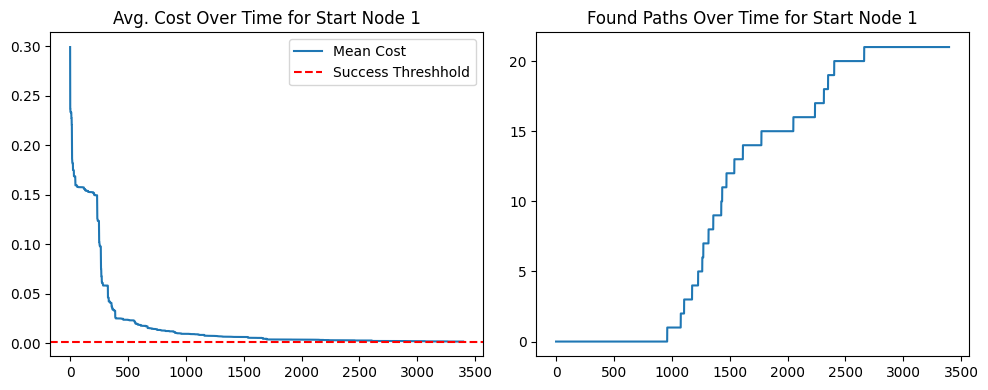

In [3]:
si = 1 if look_at_specific_start_idx == -1 else look_at_specific_start_idx

costs_over_time = []
for i, node in tqdm(enumerate(trees[si])):

    costs = []
    
    for target_idx in range(tree_count):
        cost = cost_computation(trees[target_idx][0], node, q_mask, cost_max_method)
        if i == 0 or costs_over_time[i-1][target_idx] > cost:
            costs.append(cost)
        else:
            costs.append(costs_over_time[i-1][target_idx])

    costs_over_time.append(costs)

# Subtract 1 because it also contains a cost against itself
mean_cost_over_time = [sum(costs)/(len(costs)-1) for costs in costs_over_time]
found_paths_over_time = [len([1 for c in costs if c < ERROR_THRESH])-1 for costs in costs_over_time]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title(f"Avg. Cost Over Time for Start Node {si}")
axes[0].plot(mean_cost_over_time, label="Mean Cost")

if cfg.RRT.end_idx != -1:
    cost_for_target_over_time = [costs[cfg.RRT.end_idx] for costs in costs_over_time]
    axes[0].plot(cost_for_target_over_time, label=f"Target {cfg.RRT.end_idx}")

axes[0].axhline(y=ERROR_THRESH, color="red", linestyle="--", label="Success Threshhold")
axes[0].legend()

axes[1].set_title(f"Found Paths Over Time for Start Node {si}")
axes[1].plot(found_paths_over_time)

plt.tight_layout()
plt.show()

## Expansion Analysis

In [4]:
si = 1 if look_at_specific_start_idx == -1 else look_at_specific_start_idx

sum_grand_children = [0 for _ in trees[si]]
children_count = [0 for _ in trees[si]]
for node in tqdm(trees[si]):
    children_count[node["parent"]] += 1

for i, node in tqdm(enumerate(trees[si])):
    sum_grand_children[node["parent"]] += children_count[i]

avg_grand_children = [sum_grand_children[i] / children_count[i] if children_count[i] != 0 else 0 for i in range(len(trees[si]))]
indices = sorted(range(len(children_count)), key=lambda i: children_count[i], reverse=True)
children_count.sort(reverse=True)
print(indices)
print(children_count)
print(avg_grand_children)

100%|██████████| 3397/3397 [00:00<00:00, 7420859.73it/s]
3397it [00:00, 6661080.27it/s]

[1221, 3019, 1038, 592, 0, 1273, 553, 6, 392, 580, 346, 250, 1216, 254, 740, 582, 2538, 2689, 750, 458, 1876, 550, 1611, 1266, 2975, 19, 810, 503, 1117, 1252, 27, 45, 52, 236, 237, 270, 1197, 1319, 1488, 1752, 2312, 2531, 70, 106, 110, 383, 457, 481, 634, 664, 677, 753, 1228, 1245, 1946, 362, 368, 559, 591, 1080, 1528, 1963, 2054, 2335, 3217, 77, 139, 235, 394, 441, 466, 1219, 1361, 1440, 1452, 1928, 1933, 2463, 2793, 13, 69, 140, 334, 581, 624, 1070, 1318, 1553, 2060, 2134, 2244, 2428, 444, 616, 756, 985, 997, 1229, 1365, 1898, 1922, 2110, 2200, 2284, 2613, 2651, 2861, 3256, 63, 256, 795, 1160, 1180, 1191, 1220, 1261, 1463, 1465, 1574, 1603, 1767, 1961, 1978, 2213, 2241, 2274, 2849, 20, 166, 182, 234, 399, 717, 727, 752, 1016, 1108, 1195, 1386, 1622, 1727, 1848, 1891, 2114, 2181, 2481, 2526, 2537, 2833, 24, 171, 439, 557, 649, 813, 1035, 1230, 1279, 1385, 1509, 1732, 1835, 2056, 2378, 2972, 251, 343, 654, 743, 744, 971, 1142, 1146, 1426, 1841, 1905, 2161, 2256, 2273, 2354, 2373, 2462,

## Costs for all config pairs (without clustering)

Generating Adjacency Map...


100%|██████████| 26/26 [00:00<00:00, 237.05it/s]


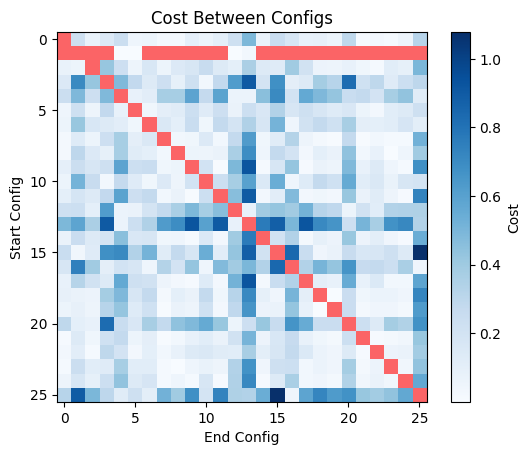

Min cost for all:  2.9648937181899134e-05
Start config: 1
End config:  16


In [5]:
min_costs, top_nodes = generate_adj_map(trees, q_mask, cost_max_method=cost_max_method)
min_costs = np.array(min_costs)

AdjMap(min_costs, ERROR_THRESH, min_costs.max())

min_costs_copy = min_costs.copy()
np.fill_diagonal(min_costs_copy, np.inf)
min_index = np.unravel_index(np.argmin(min_costs_copy), min_costs_copy.shape)
min_cost = min_costs_copy[min_index]

print("Min cost for all: ", min_cost)
print("Start config:", int(min_index[0]))
print("End config: ", int(min_index[1]))

del min_costs_copy

## Found paths count

In [6]:
path_counts = []
end_nodes = []

for i in tqdm(range(tree_count)):

    tree_path_count = [0 for _ in range(tree_count)]
    tree_end_nodes = [[] for _ in range(tree_count)]
    
    for n, node in enumerate(trees[i]):
        for j in range(tree_count):
            node_cost = cost_computation(trees[j][0], node, q_mask, cost_max_method)
            if i != j and node_cost < ERROR_THRESH:
                tree_path_count[j] += 1
                tree_end_nodes[j].append(n)
    
    path_counts.append(tree_path_count)
    end_nodes.append(tree_end_nodes)

path_counts = np.array(path_counts)

100%|██████████| 26/26 [00:00<00:00, 220.27it/s]


/home/denis/.local/lib/python3.12/site-packages/numpy/_core/numeric.py:442: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


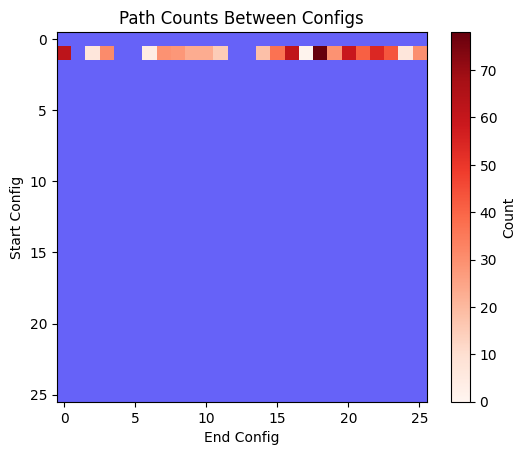

Raw max path found count: 78, mean: 1.0059171597633136, std: 6.69606175999962


In [7]:
fig, ax = plt.subplots()

im = ax.imshow(path_counts, cmap="Reds", interpolation="nearest", vmin=0, vmax=path_counts.max())

green_cmap = ListedColormap(["blue"])
overlay = ax.imshow(np.full_like(path_counts, np.nan), cmap=green_cmap, interpolation="nearest", alpha=0.6)
im.set_data(path_counts)
mask = path_counts == 0
overlay.set_data(np.where(mask, 1, np.nan))

plt.colorbar(im, ax=ax, label="Count")
ax.set_title("Path Counts Between Configs")
ax.set_xlabel("End Config")
ax.set_ylabel("Start Config")

plt.show()

print(f"Raw max path found count: {path_counts.max()}, mean: {path_counts.mean()}, std: {path_counts.std()}")

## Measuring Diversity in Found Paths

In [8]:
path_diffs_all = []
full_paths = [[[] for _ in range(tree_count)] for _ in range(tree_count)]

for si in tqdm(range(tree_count)):
    for ei in range(tree_count):
        
        if path_counts[si][ei] == 0:
            continue

        # Load paths
        paths = []
        for end_node in end_nodes[si][ei]:
            fp = build_path(trees[si], end_node)
            paths.append(fp)
            
        path_count = len(paths)
        path_diffs = [[-1 for _ in range(path_count)] for _ in range(path_count)]
        full_paths[si][ei] = paths

        for i, path_a in enumerate(paths):
            for j, path_b in enumerate(paths):
                
                if path_diffs[j][i] == -1:
                    
                    path_diffs[i][j] = 0.0
                    longest_route = max(len(path_a), len(path_b))
                    for n in range(longest_route):
                        na = -1 if n >= len(path_a) else n
                        nb = -1 if n >= len(path_b) else n
                        
                        e = (path_a[na]["state"][1] - path_b[nb]["state"][1]) * q_mask
                        path_diffs[i][j] += np.sqrt(e.T @ e)
                    
                    path_diffs[i][j] /= longest_route
    
                else:
                    path_diffs[i][j] = path_diffs[j][i]

        path_diffs = np.array(path_diffs)
        path_diffs_all.append((path_diffs, si, ei))

100%|██████████| 26/26 [00:00<00:00, 68.12it/s]


100%|██████████| 26/26 [00:00<00:00, 293.24it/s]


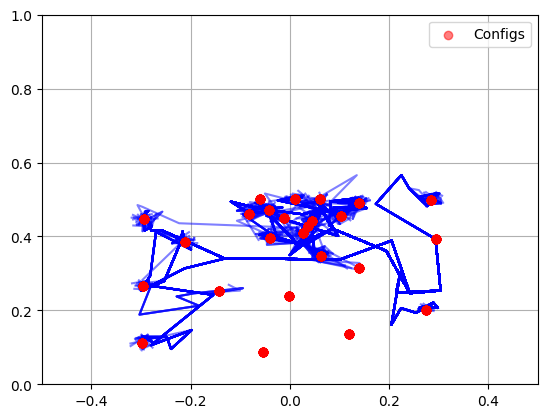

In [9]:
config_poses_x = []
config_poses_y = []

for i in tqdm(range(tree_count)):
    for j in range(tree_count):
        for path in full_paths[i][j]:
            x = [p["state"][1][0] for p in path]
            y = [p["state"][1][1] for p in path]
            plt.plot(x, y, c="blue", alpha=.5)
        
        config_poses_x.append(trees[i][0]["state"][1][0])
        config_poses_y.append(trees[i][0]["state"][1][1])
                

plt.grid(True)
plt.xlim(-0.5, 0.5)
plt.ylim(0.0, 1.0)
plt.scatter(config_poses_x, config_poses_y, c="red", alpha=.5, label="Configs", zorder=3)
plt.legend()

plt.show()

In [10]:
if len(path_diffs_all) and False:
    max_rows = 4
    
    nrows = len(path_diffs_all) if len(path_diffs_all) < max_rows else max_rows
    ncols = int(np.ceil(len(path_diffs_all) / max_rows))

    fig, ax = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    ax = ax.flatten()
    
    for i, (path_diff, si, ei) in enumerate(path_diffs_all):
        im = ax[i].imshow(path_diff, cmap="Greens", interpolation="nearest", vmin=path_diff.min(), vmax=path_diff.max())

        cmap = ListedColormap(["red"])
        overlay = ax[i].imshow(np.full_like(path_diff, np.nan), cmap=cmap, interpolation="nearest", alpha=1.)
        im.set_data(path_diff)
        mask = path_diff < path_diff_thresh
        overlay.set_data(np.where(mask, 1, np.nan))

        # plt.colorbar(im, ax=ax[i], label="Diff")
        ax[i].set_title(f"Start idx {si} and End idx {ei}")
        ax[i].set_xlabel("Path idx")
        ax[i].set_ylabel("Path idx")

    plt.tight_layout()
    plt.savefig("path_similarities")
    pass

In [11]:
path_diffs_mat = [[[] for _ in range(tree_count)] for _ in range(tree_count)]
for pda in path_diffs_all:
    path_diffs_mat[pda[1]][pda[2]] = pda[0]

real_path_counts = []
trees_paths_idxs = []

for i in range(tree_count):

    tree_path_count = [0 for _ in range(tree_count)]
    tree_paths = [[] for _ in range(tree_count)]
    
    for j in range(tree_count):
        
        if i != j:
            path_count = len(path_diffs_mat[i][j])
            for p_a in range(path_count):
                special = True
                for p_b in tree_paths[j]:
                    if path_diffs_mat[i][j][p_a][p_b] < path_diff_thresh:
                        special = False
                        break
                    
                if special:
                    tree_path_count[j] += 1
                    tree_paths[j].append(p_a)
    
    real_path_counts.append(tree_path_count)
    trees_paths_idxs.append(tree_paths)

real_path_counts = np.array(real_path_counts)

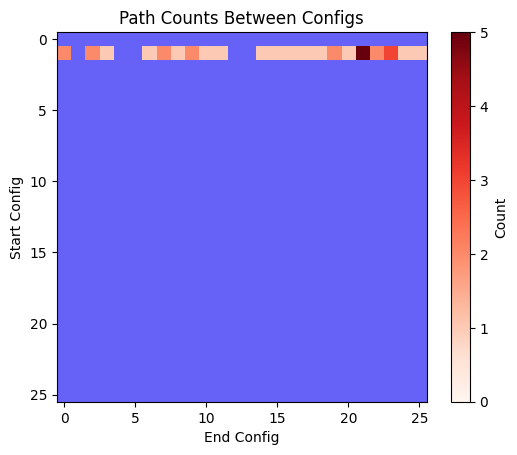

Real max path found count: 5, mean: 0.04881656804733728, std: 0.3203849691900296


In [12]:
fig, ax = plt.subplots()

im = ax.imshow(real_path_counts, cmap="Reds", interpolation="nearest", vmin=0, vmax=real_path_counts.max())

green_cmap = ListedColormap(["blue"])
overlay = ax.imshow(np.full_like(real_path_counts, np.nan), cmap=green_cmap, interpolation="nearest", alpha=0.6)
im.set_data(real_path_counts)
mask = real_path_counts == 0
overlay.set_data(np.where(mask, 1, np.nan))

plt.colorbar(im, ax=ax, label="Count")
ax.set_title("Path Counts Between Configs")
ax.set_xlabel("End Config")
ax.set_ylabel("Start Config")

plt.show()

print(f"Real max path found count: {real_path_counts.max()}, mean: {real_path_counts.mean()}, std: {real_path_counts.std()}")

In [13]:
trees_paths_idxs_flatten = []
for i in range(tree_count):
    for j in range(tree_count):
        if i != j and len(trees_paths_idxs[i][j]) > 3:
            trees_paths_idxs_flatten.append((trees_paths_idxs[i][j], i, j))

print(f"Total config pairs with diverse paths: {len(trees_paths_idxs_flatten)}")

# TODO: Use PCA for the analysis?
if len(trees_paths_idxs_flatten) and False:
    max_rows = 2
    
    nrows = len(trees_paths_idxs_flatten) if len(trees_paths_idxs_flatten) < max_rows else max_rows
    ncols = int(np.ceil(len(trees_paths_idxs_flatten) / max_rows))

    fig, ax = plt.subplots(ncols, nrows, figsize=(nrows * 5, ncols * 5))
    ax = ax.flatten()
    
    for i, (path_ids, si, ei) in tqdm(enumerate(trees_paths_idxs_flatten)):
        for j, path_idx in enumerate(path_ids):
            path = full_paths[si][ei][path_idx]
            x = [p["state"][1][0] for p in path]
            y = [p["state"][1][1] for p in path]
            if j == 0:
                ax[i].scatter([x[0]], [y[0]], label="Start", c="red")
                ax[i].scatter([x[-1]], [y[-1]], label="End", c="green")
            else:
                ax[i].scatter([x[0]], [y[0]], c="red")
                ax[i].scatter([x[-1]], [y[-1]], c="green")
                
            if j < 4:
                ax[i].plot(x, y, label=f"Path {j}", alpha=0.5)
            elif j == 4:
                ax[i].plot(x, y, label=f"(Total {len(path_ids)})", alpha=0.5)
        ax[i].legend()
        ax[i].grid(True)
        # ax[i].axis("equal")
        ax[i].set_xlim(-0.5, 0.5)
        ax[i].set_ylim(0.0, 1.0)

    plt.tight_layout()
    plt.show()

Total config pairs with diverse paths: 1


## Clustering

In [14]:
colors = [-1 for _ in range(tree_count)]

max_color_idx = 0
for i in range(tree_count):
        
    if colors[i] == -1:
        colors[i] = max_color_idx
        max_color_idx += 1
        
        for j in range(tree_count):
            if i != j and min_costs[i][j] <= ERROR_THRESH:
                if colors[j] != -1:
                    c = colors[j]
                    for k in range(tree_count):
                        if colors[k] == c:
                            colors[k] = colors[i]
                else:
                    colors[j] = colors[i]

groups = []
for c in colors:
    if not c in groups:
        groups.append(c)

group_sizes = [0 for _ in groups]
for c in colors:
    group_sizes[groups.index(c)] += 1

# print(colors)
# print(groups)
print("Group Count: ", len(groups))
print("Group Sizes: ", group_sizes)

Group Count:  5
Group Sizes:  [22, 1, 1, 1, 1]


## Looking at specific start and end configurations

Mean costs for start config 1: 0.0018670643877765729, (Min: 2.9648937181899134e-05, Max 0.03219508742697495)


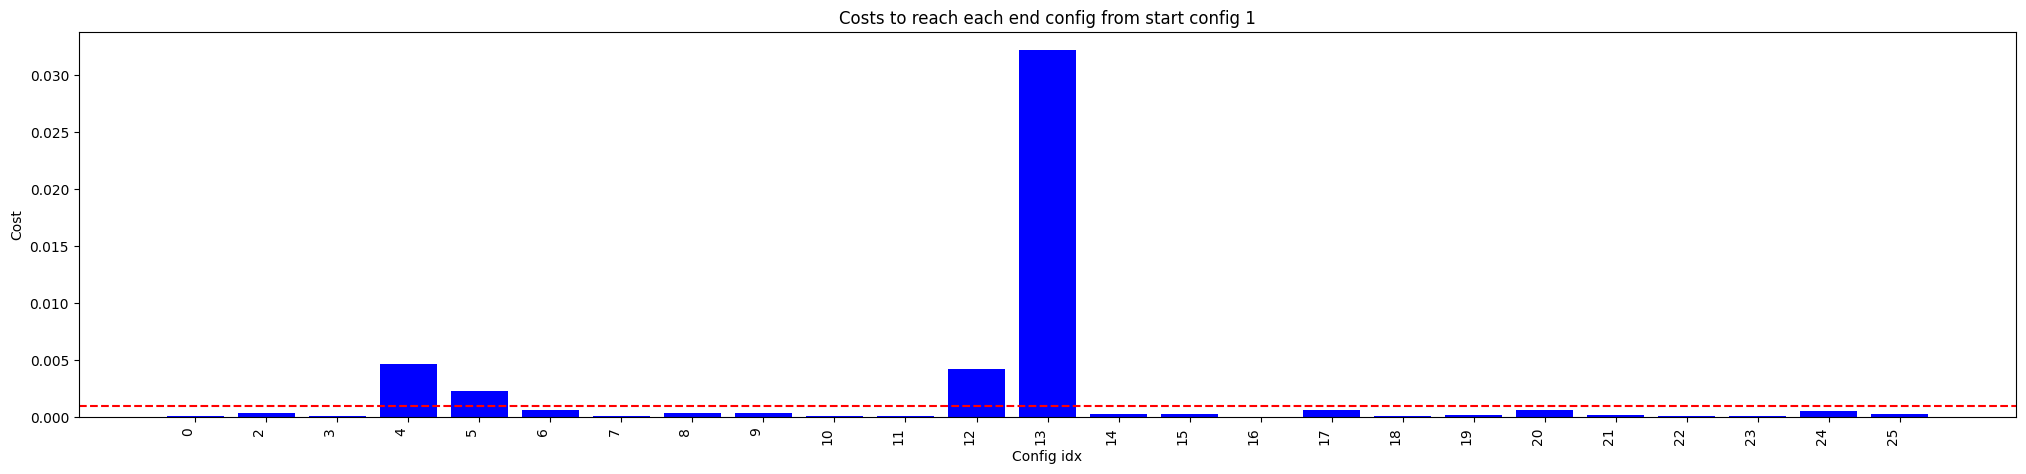

In [15]:
start_idx = look_at_specific_start_idx
end_idx = look_at_specific_end_idx

if look_at_specific_start_idx != -1:
    costs = [min_costs[start_idx][i] for i in range(tree_count) if start_idx != i]
    print(f"Mean costs for start config {start_idx}: {sum(costs)/tree_count}, (Min: {min(costs)}, Max {max(costs)})")
    labels = [str(i) for i in range(tree_count) if i != start_idx]
    
    highlight_labels = {str(end_idx)}
    colors = ["red" if label in highlight_labels else "blue" for label in labels]
    plt.figure(figsize=(25, 5))
    plt.bar(labels, costs, color=colors)
    plt.xticks(rotation=90, ha="right")
    plt.axhline(y=ERROR_THRESH, color="red", linestyle="--")
    plt.title(f"Costs to reach each end config from start config {start_idx}")
    plt.xlabel("Config idx")
    plt.ylabel("Cost")
    plt.show()

    if end_idx != -1:
        print(f"Cost for target {end_idx} with start {start_idx}: {costs[end_idx]}")

## Collecting top paths

In [16]:
traj_pairs, end_nodes, top_costs = get_feasible_paths(
                min_costs, top_nodes, look_at_specific_start_idx, look_at_specific_end_idx, ERROR_THRESH)

top_paths = []
top_paths_start = []
top_paths_goal = []
for i, path_data in enumerate(traj_pairs):

    start_idx = path_data[0]
    end_idx = path_data[1]
    if start_idx == end_idx: continue
    
    tree = trees[start_idx]
    
    path = build_path(tree, end_nodes[i])

    top_paths.append(path)
    top_paths_start.append(start_idx)
    top_paths_goal.append(end_idx)

target_counts = []
for i, path in enumerate(top_paths):
    goal_idx = top_paths_goal[i]
    target_counts.append(0)
    for node in path:
        if goal_idx == node["target_config_idx"]:
            target_counts[-1] += 1

percs = [float(np.round(c/len(top_paths[i])*100)) for i, c in enumerate(target_counts)]
percs.sort()
percs.reverse()

possible_paths = tree_count**2 - tree_count
print("Top costs: ", [float(c) for c in top_costs])
print("Found Trajectories Count: ", len(top_paths), " of ", possible_paths)
if look_at_specific_start_idx == -1:
    print("When considering full graph: ", sum([v**2 for v in group_sizes]) - tree_count, " of ", possible_paths)

if not top_paths:
    print("No trajectories found!")

else:
    print("Percentage of reached config used as target: ", percs)
    print("Avg. use of reached config as target: ", sum(percs)/len(percs))

    path_lens = [len(p) for p in top_paths]

    # print("Path lens: [", end="")
    # for i in range(len(top_paths)):
    #     end = "]\n" if i == len(top_paths)-1 else ", "
    #     print(f"{path_lens[i]} ({top_paths_start[i]}, {top_paths_goal[i]})", end=end)

    path_lens_copy = path_lens.copy()
    path_lens_copy.sort()
    path_lens_copy.reverse()
    print("Path lengths: ", path_lens_copy)
    print("Avg. Path length: ", sum(path_lens_copy)/len(path_lens_copy))

Top costs:  [0.00012448171569255168, 0.00031329666997423263, 0.00011918159463470543, 0.0005964057508794437, 4.1762548859535326e-05, 0.00031192702076915423, 0.0003500750119633786, 9.506750474599507e-05, 0.00012427857441787873, 0.0002784891364597506, 0.00023067739704126888, 2.9648937181899134e-05, 0.0006187894630585651, 7.180307690781726e-05, 0.0001709175840923285, 0.0006166278194218554, 0.0001916344760397184, 0.00011105098935559189, 6.538907589171997e-05, 0.0005196991123986036, 0.00025715612893873434]
Found Trajectories Count:  21  of  650
Percentage of reached config used as target:  [75.0, 53.0, 50.0, 47.0, 44.0, 40.0, 40.0, 35.0, 29.0, 27.0, 23.0, 20.0, 18.0, 17.0, 15.0, 12.0, 11.0, 0.0, 0.0, 0.0, 0.0]
Avg. use of reached config as target:  26.476190476190474
Path lengths:  [19, 18, 17, 17, 15, 15, 15, 14, 14, 13, 13, 13, 12, 12, 12, 11, 11, 10, 9, 8, 8]
Avg. Path length:  13.142857142857142


## Sample a single path

In [17]:
path = []
min_path_len = 10

if not top_paths:
    print("No good paths no analyse!")

else:
    valid_path_idxs = [i for i, l in enumerate(path_lens) if l >= min_path_len]

    # path_idx = top_paths_goal.index(cfg.RRT.end_idx)
    path_idx = np.random.choice(valid_path_idxs)
    path = top_paths[path_idx]
    start_idx = top_paths_start[path_idx]
    end_idx = top_paths_goal[path_idx]
    e_vec = trees[end_idx][0]["state"][1] - path[-1]["state"][1]

    print("---- Sampled Path Data ----")
    print("Target config ids: ", [n["target_config_idx"] for n in path])
    print("Start idx: ", start_idx)
    print("End idx: ", end_idx)
    print("Cost: ", top_costs[path_idx])
    print("Error vec: ", e_vec)
    print("Error vec (with mask): ", e_vec * q_mask)
    print("Sampled Path Length: ", len(path))

---- Sampled Path Data ----
Target config ids:  [-1, np.int64(13), np.int64(6), np.int64(0), np.int64(7), np.int64(18), np.int64(24), np.int64(19), np.int64(18), np.int64(18), np.int64(18), np.int64(19)]
Start idx:  1
End idx:  19
Cost:  0.0001709175840923285
Error vec:  [ 0.0090376   0.00529822  0.0034845   0.00187427  0.0058957   0.00327938
  0.31195208  0.31836341  0.82947243 -0.12871648]
Error vec (with mask):  [ 0.0090376   0.00529822  0.0034845   0.00187427  0.0058957   0.00327938
  0.          0.          0.         -0.        ]
Sampled Path Length:  12


Playing path with length 12


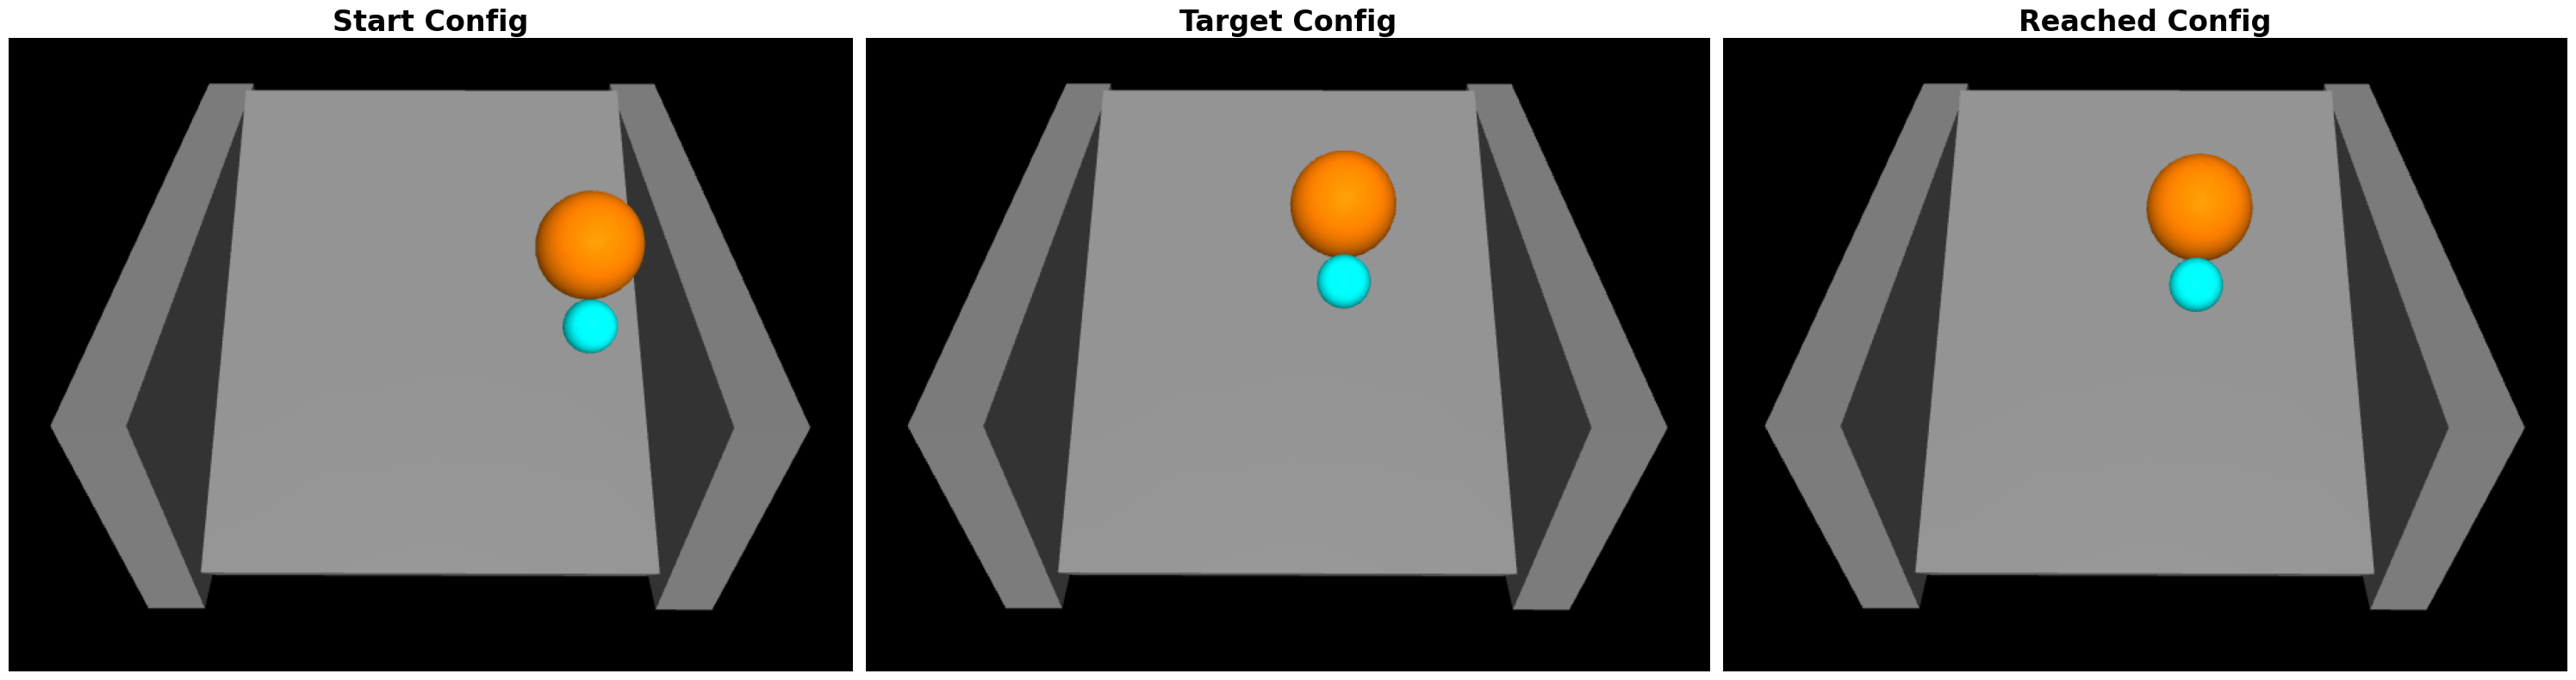

In [18]:
if path:
    start_state = trees[start_idx][0]["state"][1]
    target_state = trees[end_idx][0]["state"][1]
    sim = MjSim(
        mujoco_xml, tau_sim=sim_cfg.tau_sim, interpolate=sim_cfg.interpolate_actions,
        joints_are_same_as_ctrl=sim_cfg.joints_are_same_as_ctrl, view=False, use_spline_ref=sim_cfg.use_spline_ref
    )
    play_path(path, sim, start_state, target_state, tau_action=sim_cfg.tau_action, camera=cfg.RRT.sim.camera, reset_state=True)

In [ ]:
import h5py as h5
from explore.utils.vis import play_path_mppi


def load_h5_to_dict(h5obj):
    result = {}
    for key, item in h5obj.items():
        if isinstance(item, h5.Dataset):
            result[key] = item[()]  # load into memory
        elif isinstance(item, h5.Group):
            result[key] = load_h5_to_dict(item)
    return result
with h5.File("../results4.h5", "r") as f:
    data = load_h5_to_dict(f)

# Load the same configs file used during generation
with h5.File("../" + cfg.configs_path, "r") as f:
    configs = f["qpos"][:]
    configs_ctrl = f["ctrl"][:]

sim = MjSim(
    mujoco_xml, tau_sim=sim_cfg.tau_sim, interpolate=False,  # interpolate=False is critical
    joints_are_same_as_ctrl=sim_cfg.joints_are_same_as_ctrl, 
    view=True, 
    use_spline_ref=False  # also False, we apply raw controls directly
)

for key, value in data.items():
    print(f"Trajectory {key}:")
    traj = value['trajectory']           # shape (N, nu)
    start_idx = int(value['start_idx'])
    end_idx = int(value['end_idx'])

    start_qpos = configs[start_idx]      # exact same source as generation
    start_ctrl = configs_ctrl[start_idx] # exact same source as generation

    print(f"traj shape: {traj.shape}, start_qpos: {start_qpos}, start_ctrl: {start_ctrl}")

    visualize_path_mppi(traj, sim, start_qpos, start_ctrl=start_ctrl)
    

Trajectory target_1_0:
traj shape: (1880, 3), start_qpos: [ 0.293974    0.392953    0.0698645   0.29411     0.00419848  0.57049
  0.988738    0.0511224   0.0976581  -0.20528   ], start_ctrl: [0.293974  0.392953  0.0698645]
Visualizing MPPI path: 1880 steps
Rollout complete.
Trajectory target_1_2:
traj shape: (620, 3), start_qpos: [ 0.293974    0.392953    0.0698645   0.29411     0.00419848  0.57049
  0.988738    0.0511224   0.0976581  -0.20528   ], start_ctrl: [0.293974  0.392953  0.0698645]
Visualizing MPPI path: 620 steps
Rollout complete.
Trajectory target_1_3:
traj shape: (2000, 3), start_qpos: [ 0.293974    0.392953    0.0698645   0.29411     0.00419848  0.57049
  0.988738    0.0511224   0.0976581  -0.20528   ], start_ctrl: [0.293974  0.392953  0.0698645]
Visualizing MPPI path: 2000 steps
Rollout complete.
Trajectory target_1_4:
traj shape: (2000, 3), start_qpos: [ 0.293974    0.392953    0.0698645   0.29411     0.00419848  0.57049
  0.988738    0.0511224   0.0976581  -0.20528   ]

---- Sampled Path Data ----
Target config ids:  [-1, np.int64(13), np.int64(6), np.int64(0), np.int64(7), np.int64(22), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(11), np.int64(8), np.int64(0)]
Start idx:  1
End idx:  0
Cost:  0.00012448171569255168
Error vec:  [-8.83020622e-03 -5.80400206e-03  3.36405783e-03  9.81294506e-04
 -4.23817509e-04 -6.02734242e-04  9.39279609e-01  2.85472924e-01
  7.48519866e-01  6.50511801e-01]
Error vec (with mask):  [-0.00883021 -0.005804    0.00336406  0.00098129 -0.00042382 -0.00060273
  0.          0.          0.          0.        ]
Sampled Path Length:  14
Playing path with length 14
---- Sampled Path Data ----
Target config ids:  [-1, np.int64(13), np.int64(6), np.int64(0), np.int64(7), np.int64(18), np.int64(24), np.int64(19), np.int64(19), np.int64(20), np.int64(22), np.int64(22)]
Start idx:  1
End idx:  2
Cost:  0.00031329666997423263
Error vec:  [-0.00066867  0.00557555  0.01183938 -0.00332014  0.01006378  0.0054119

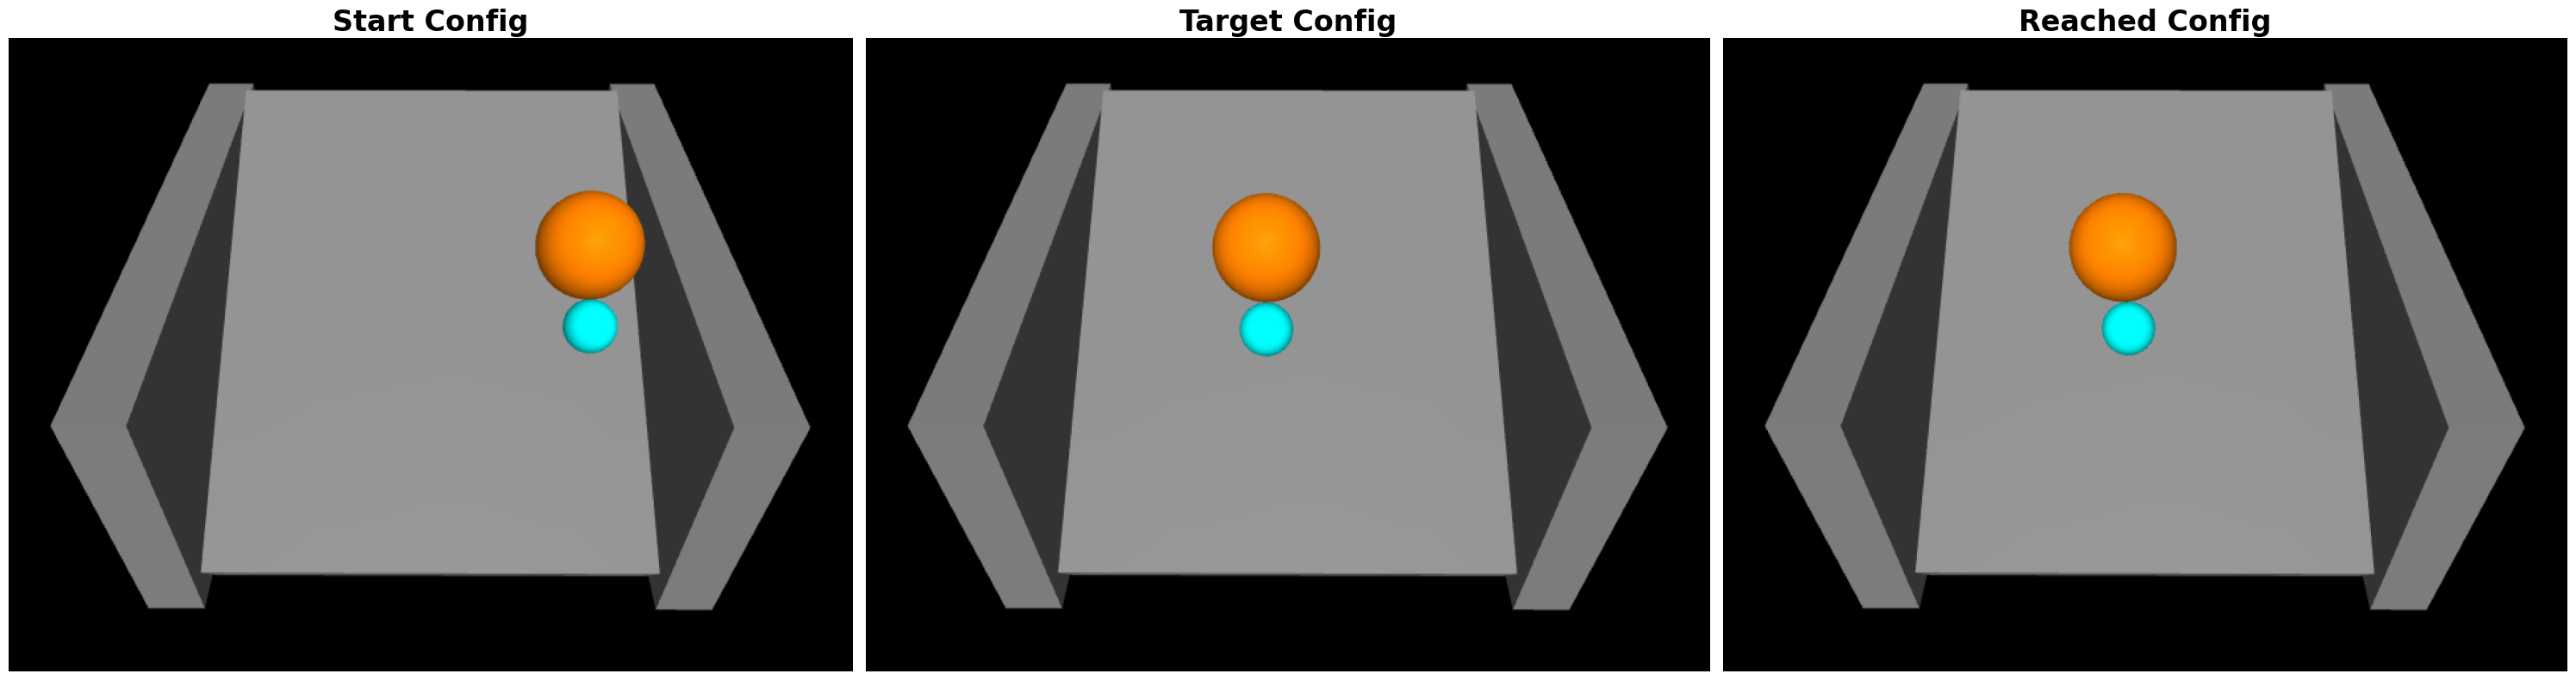

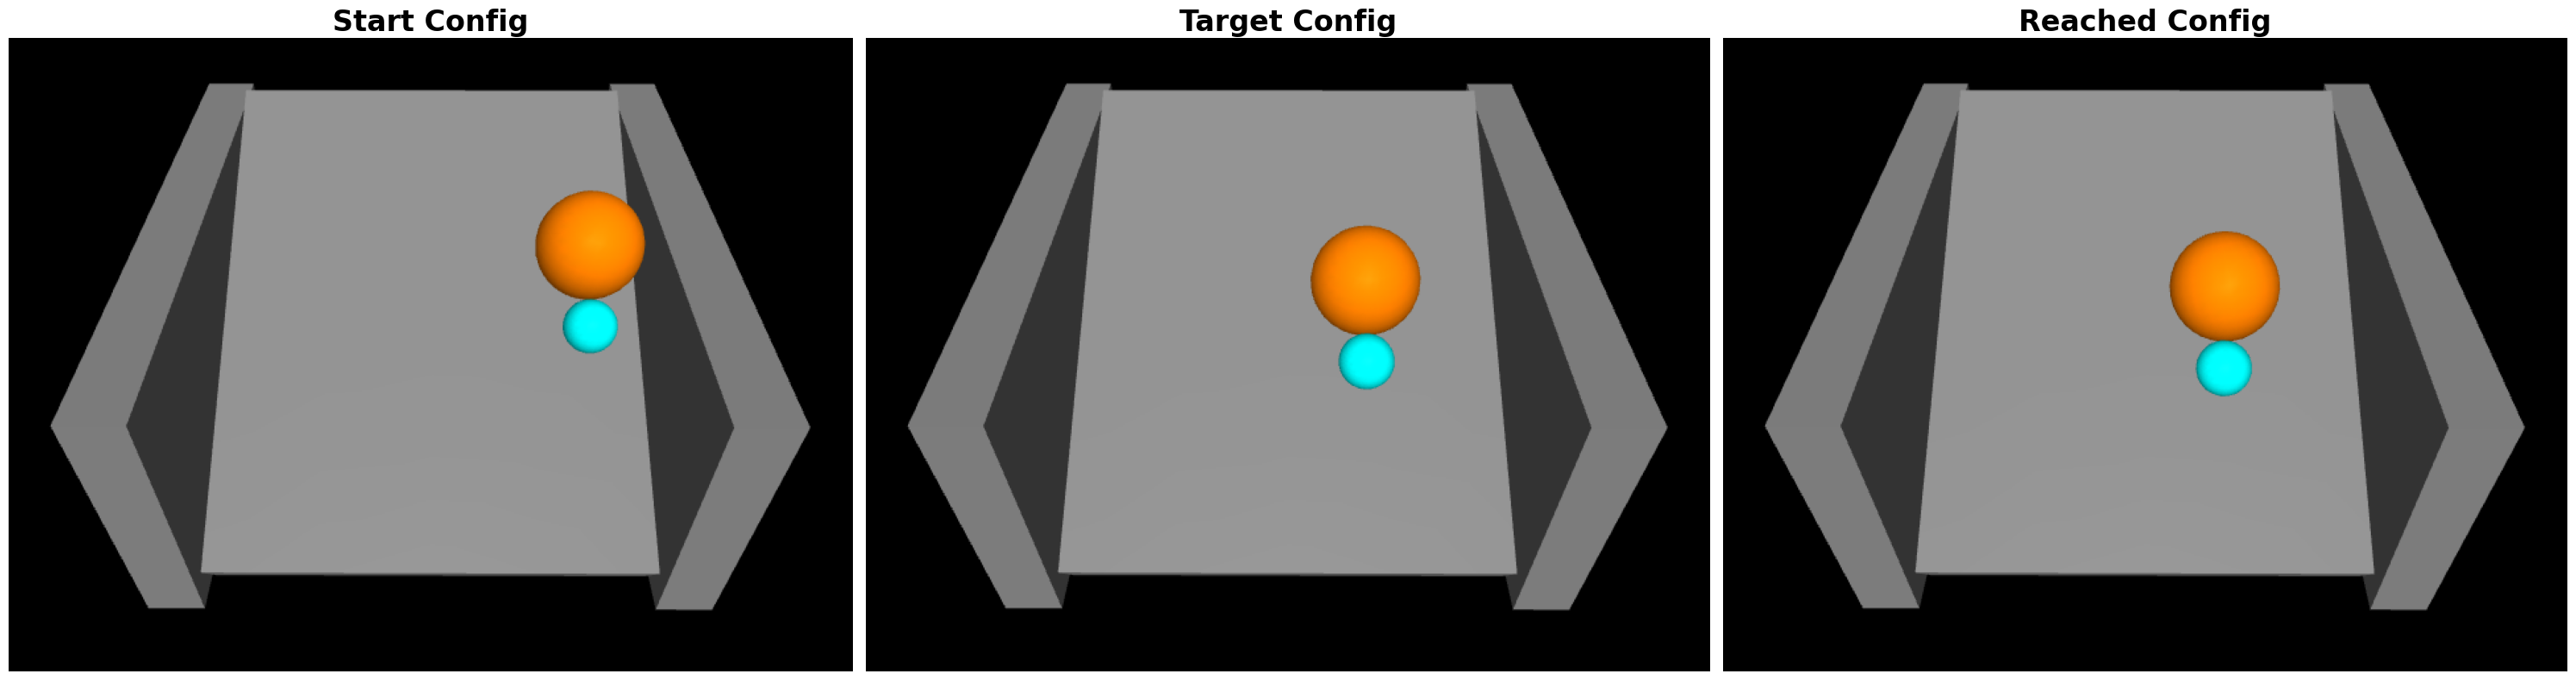

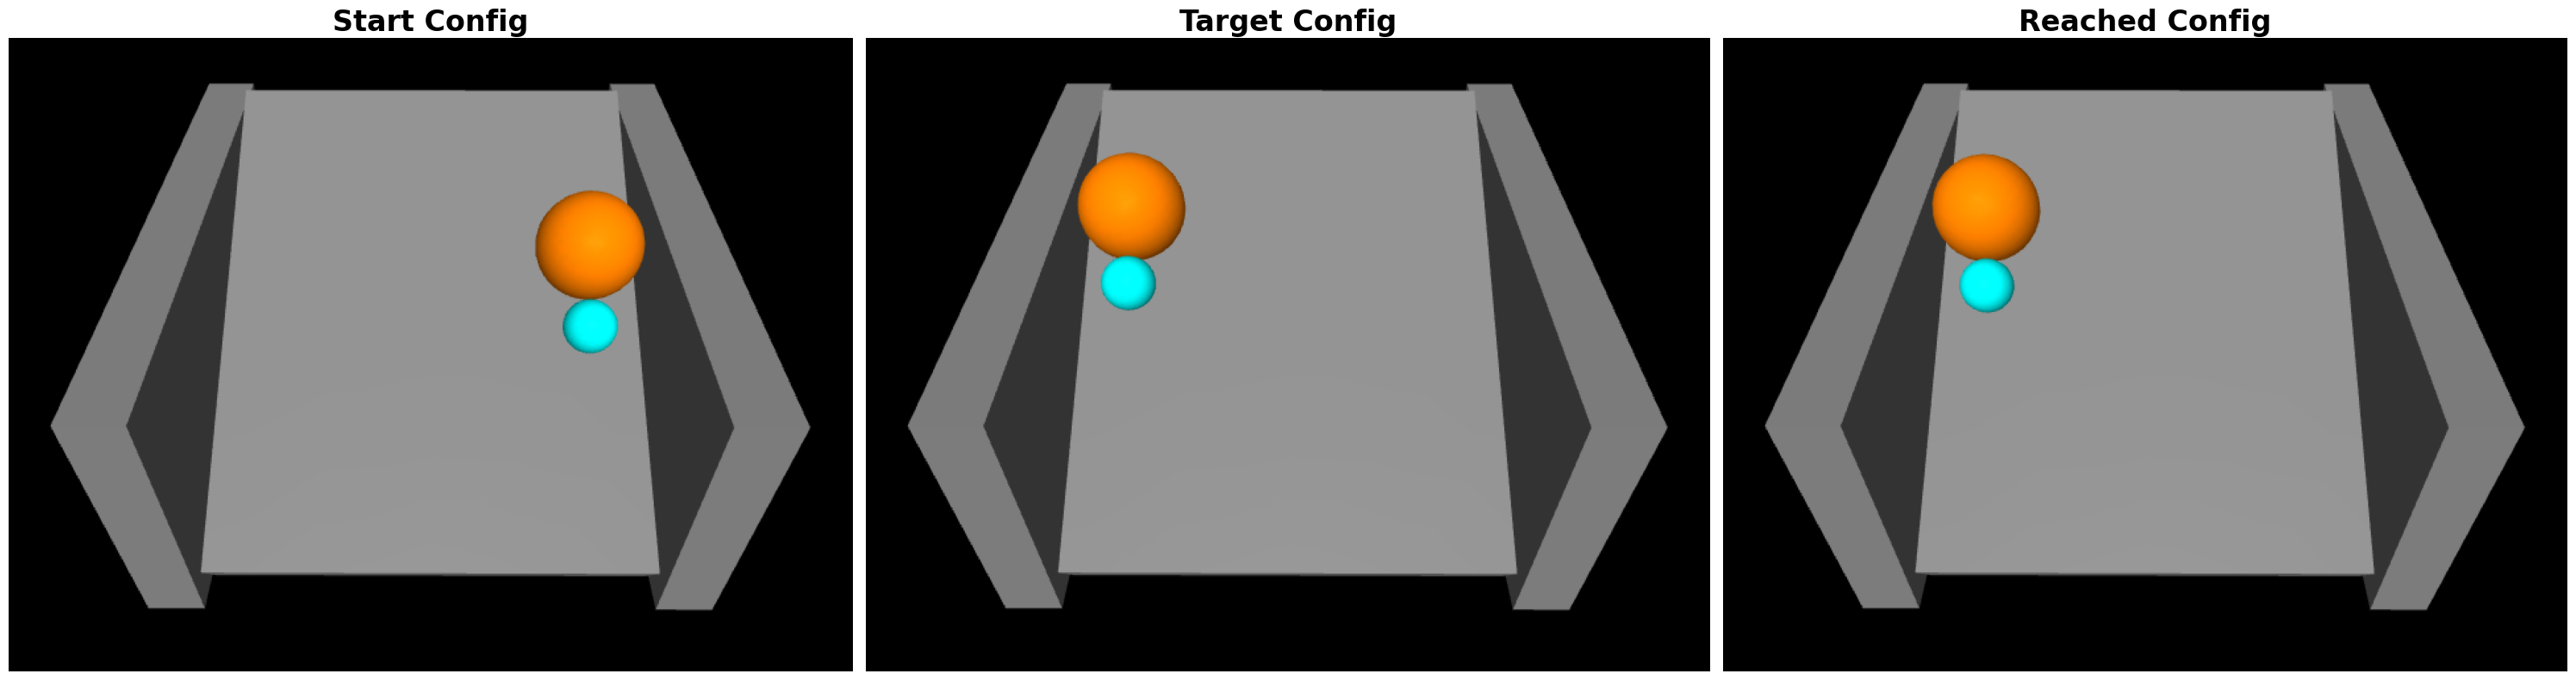

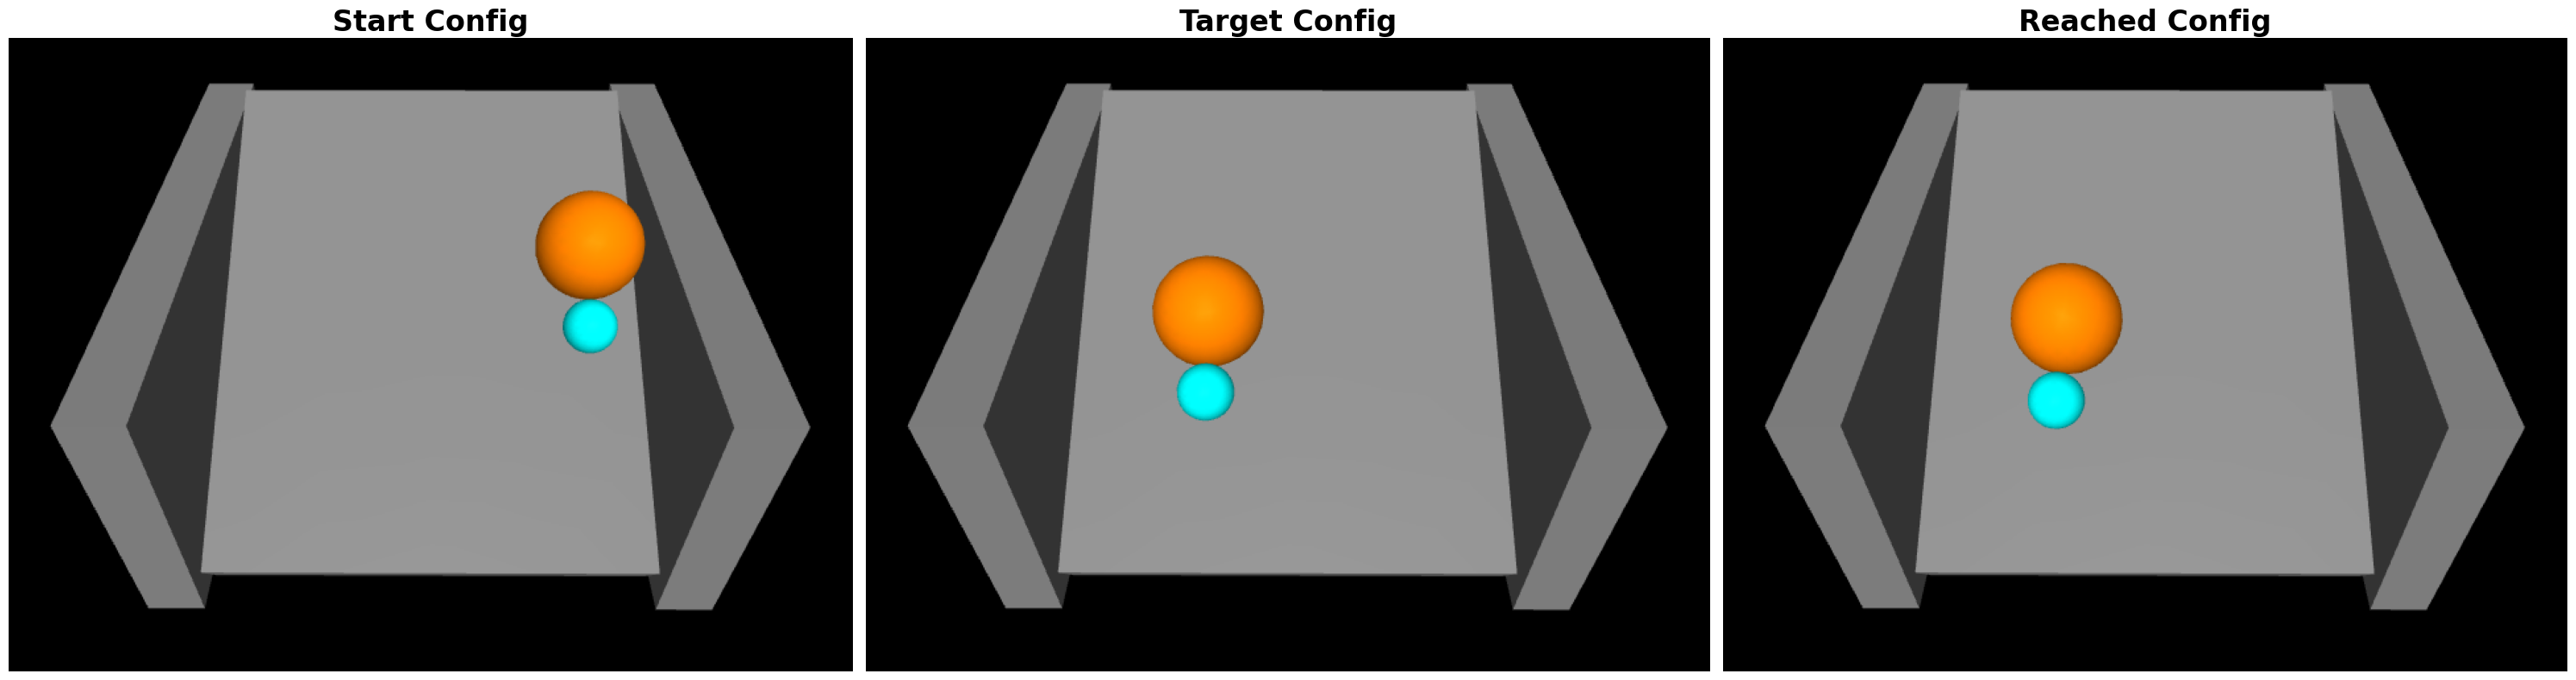

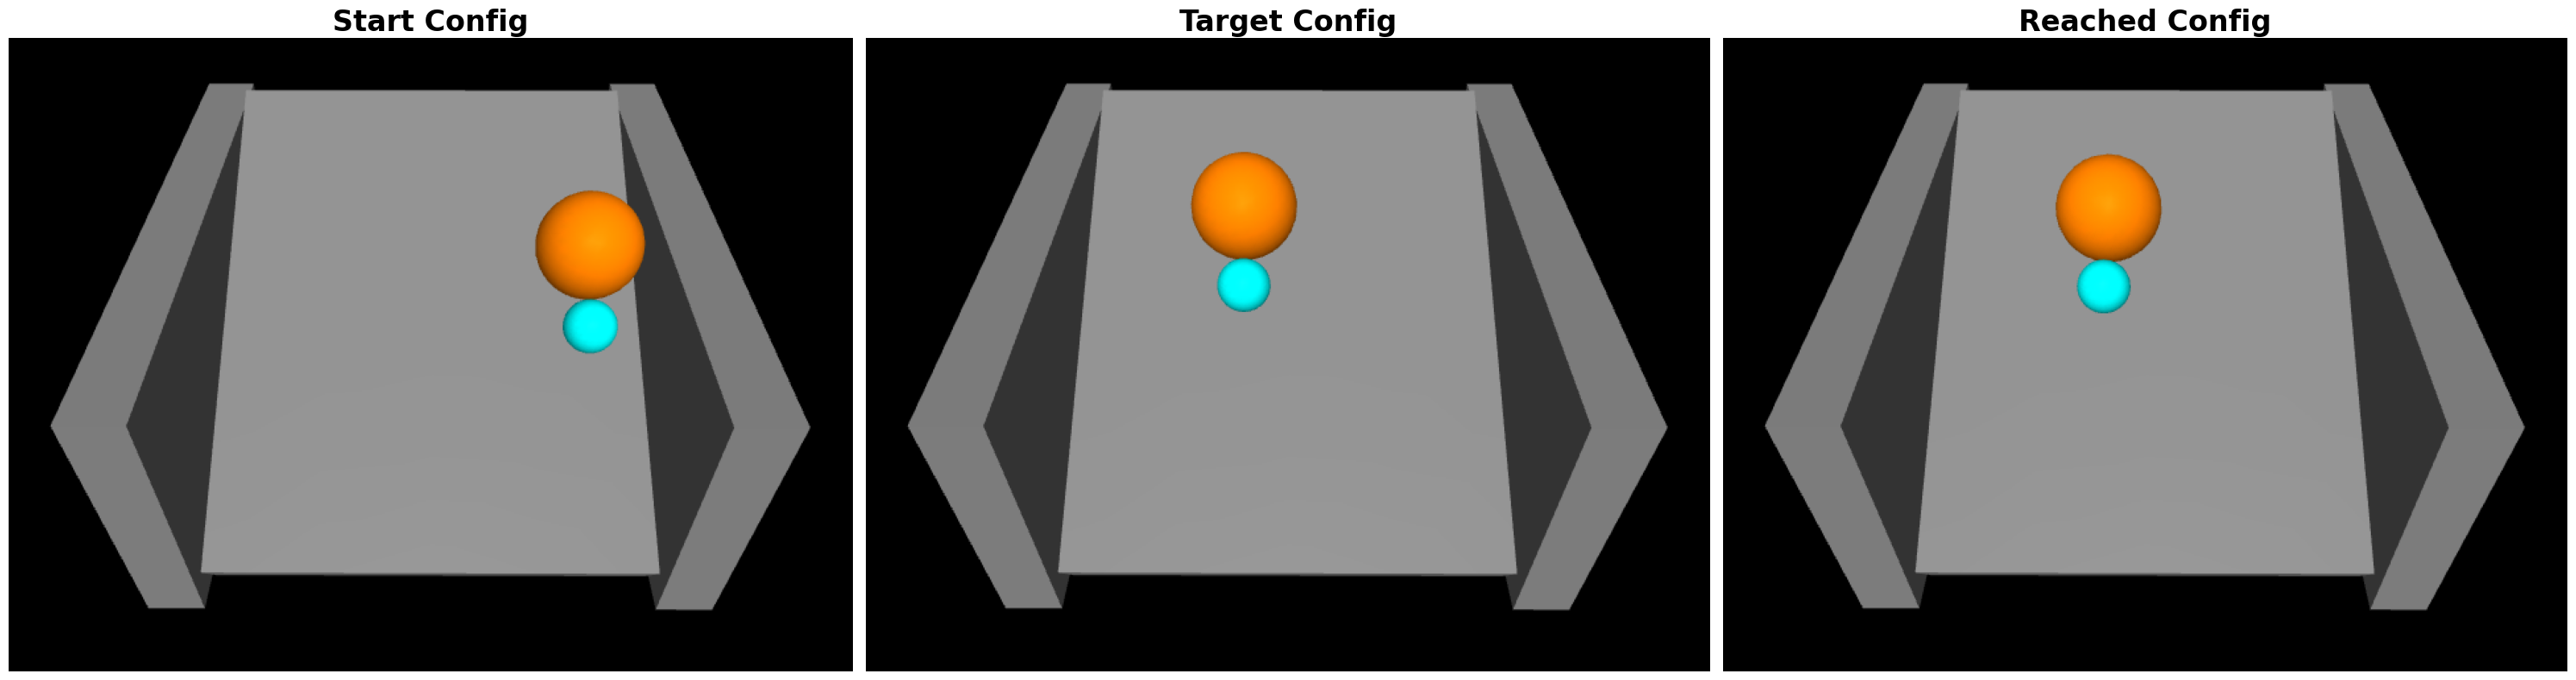

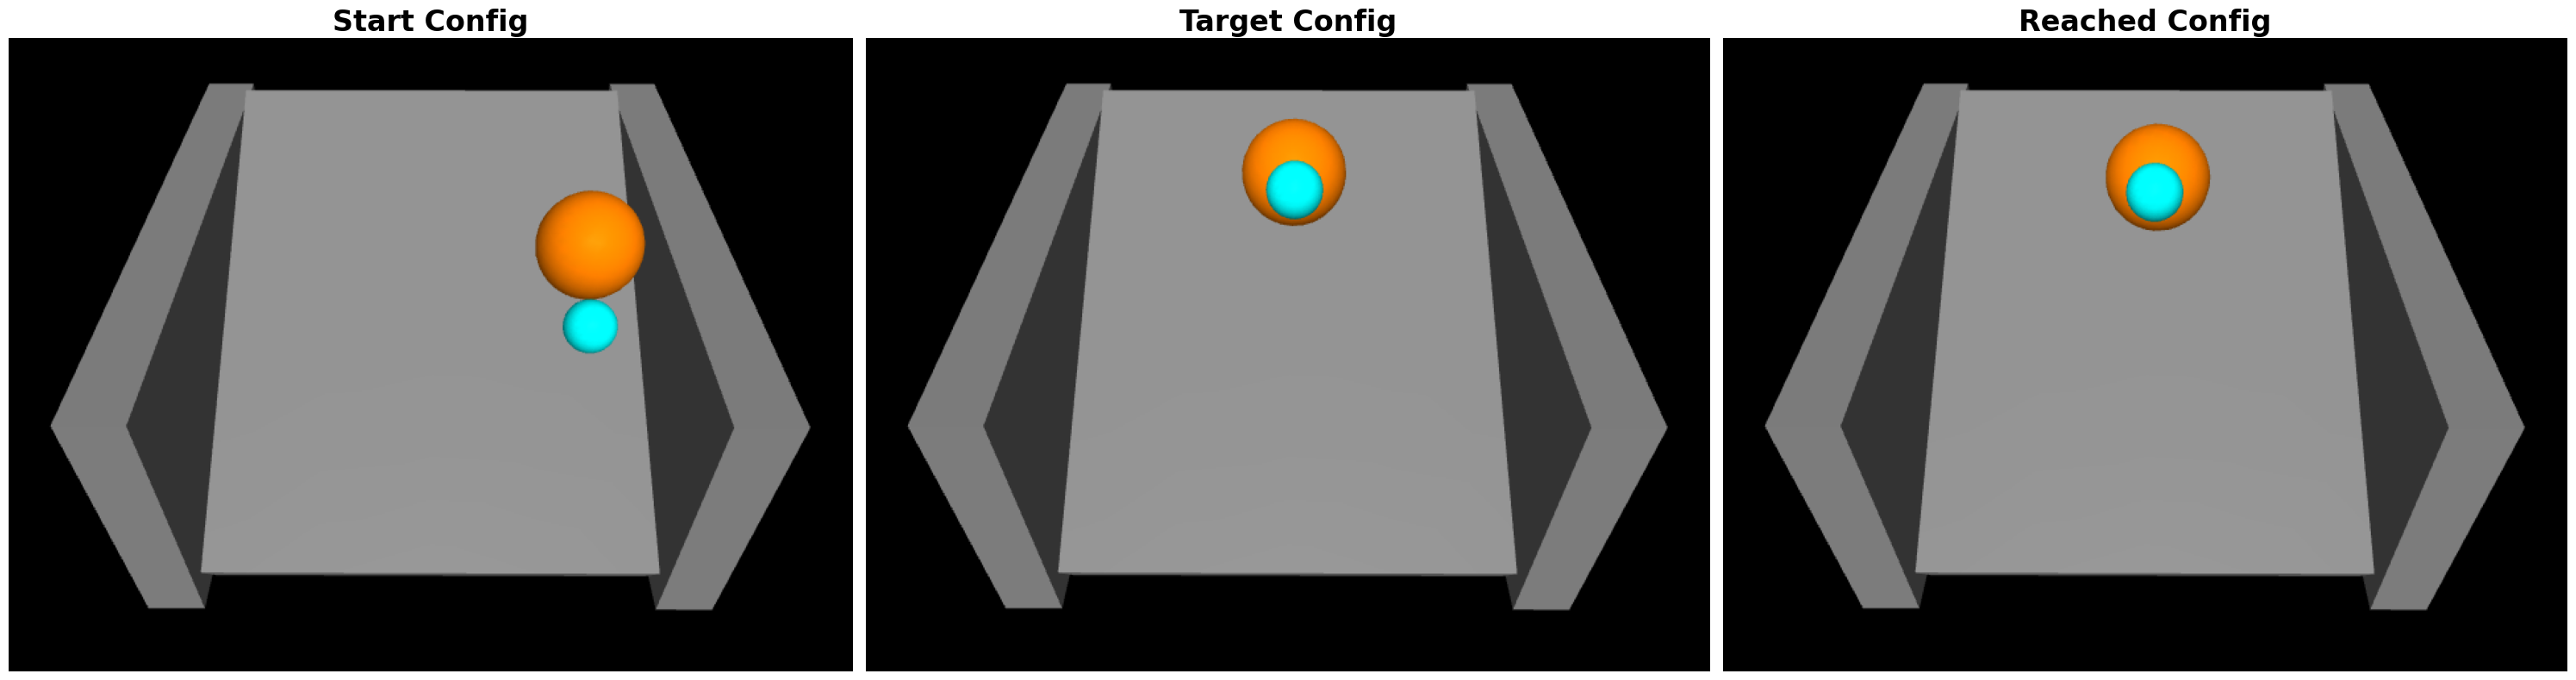

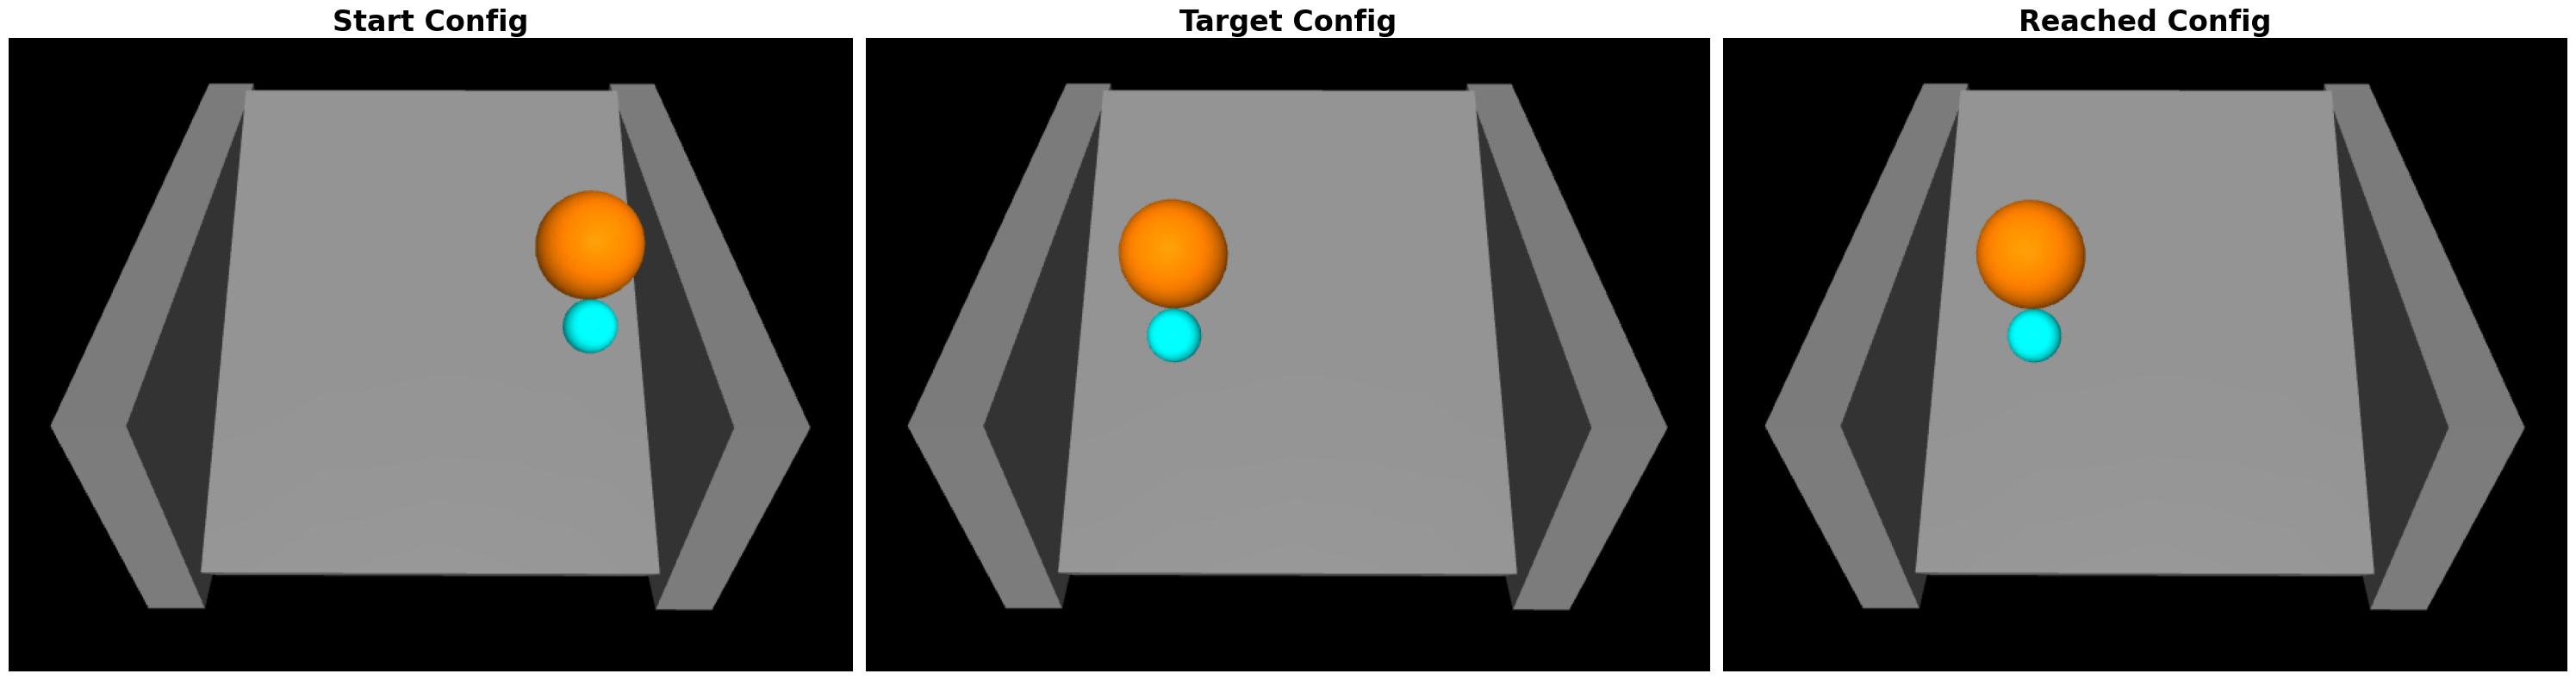

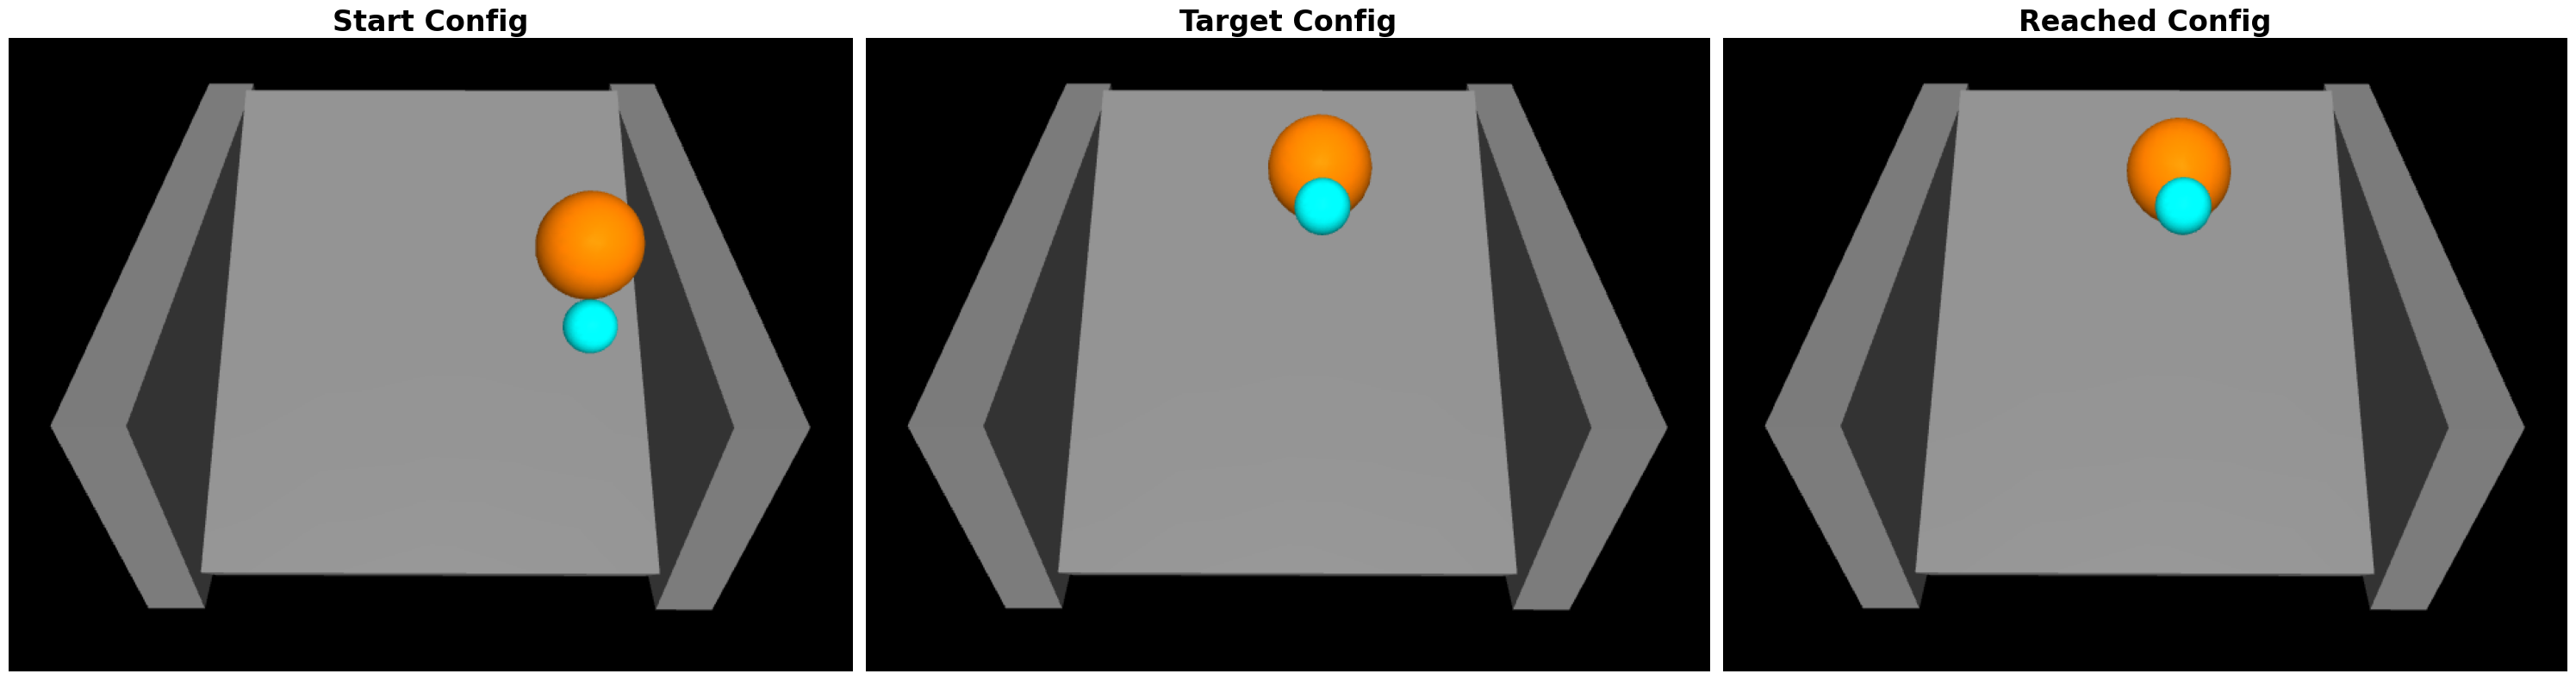

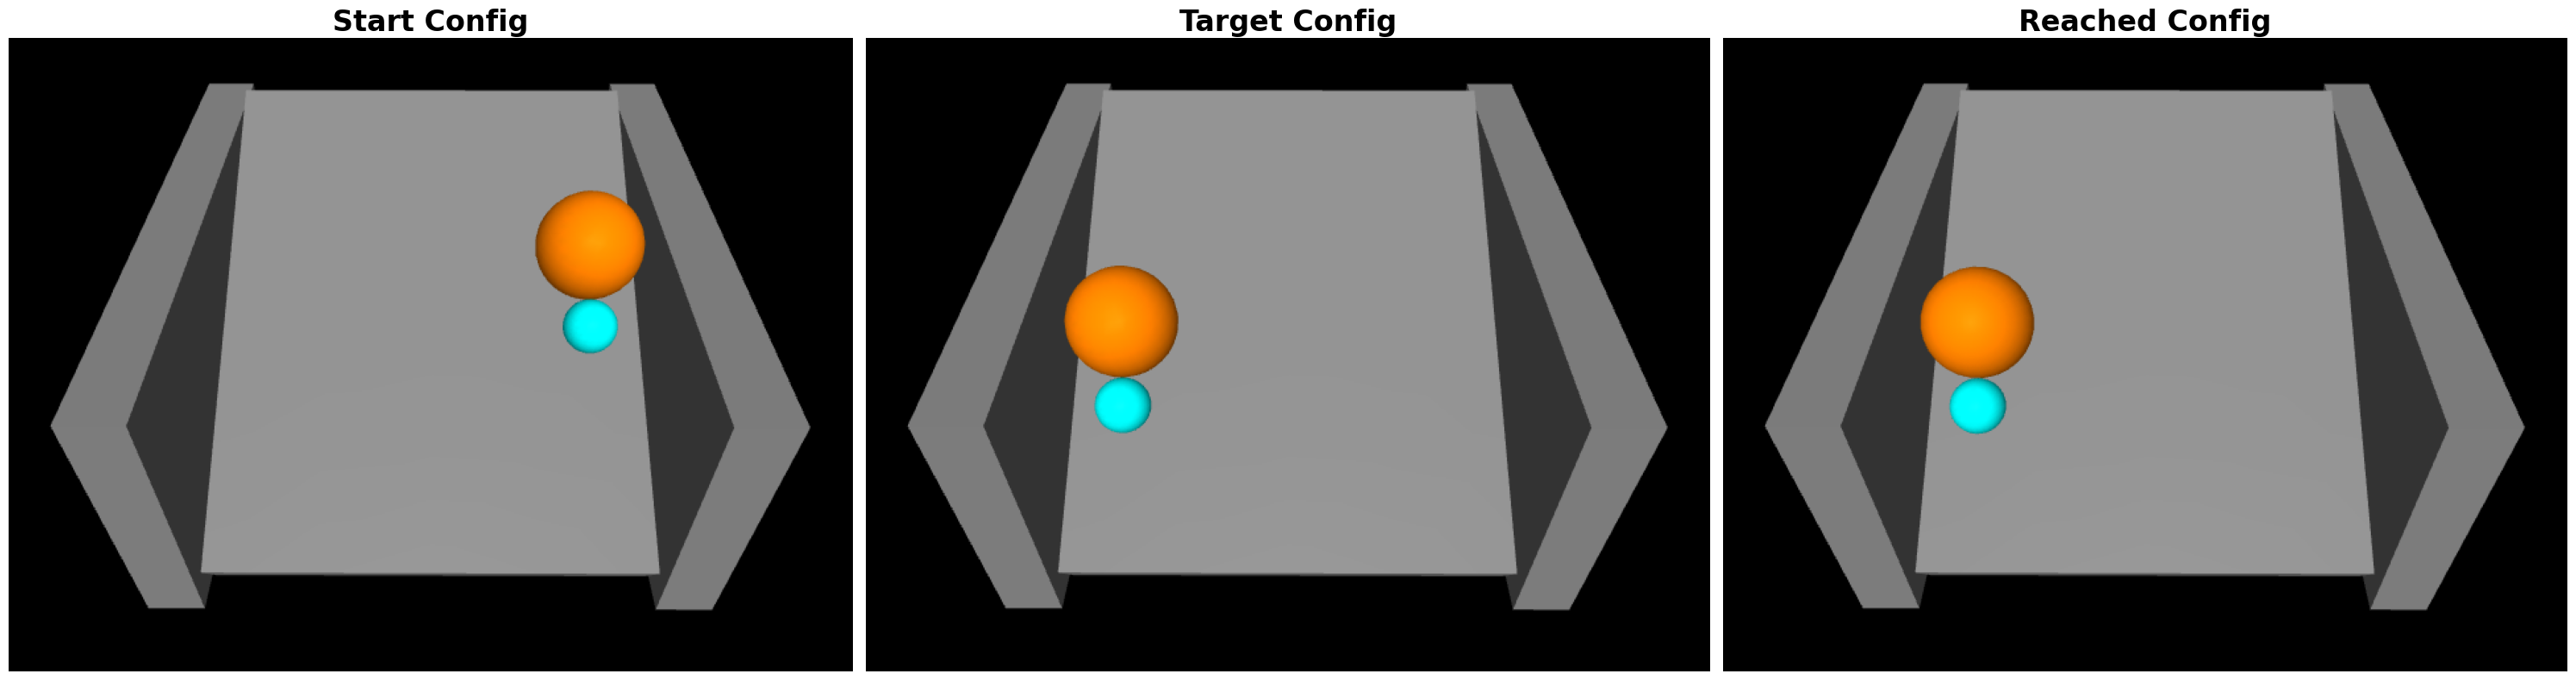

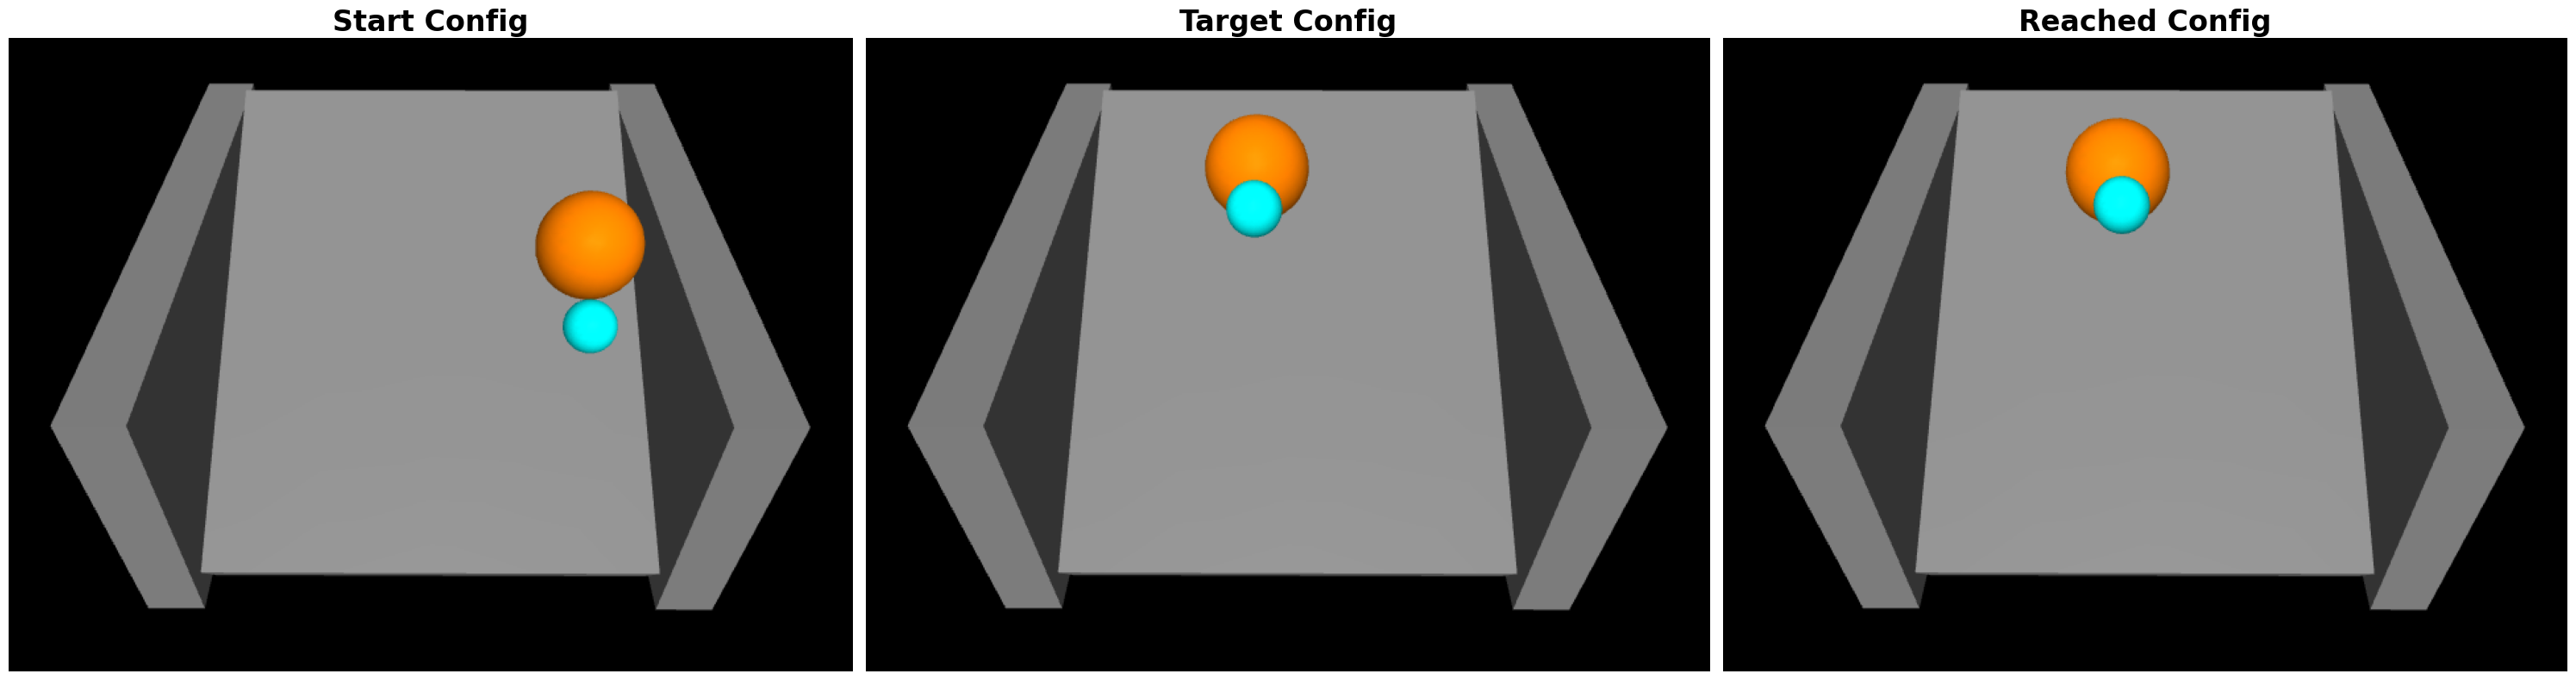

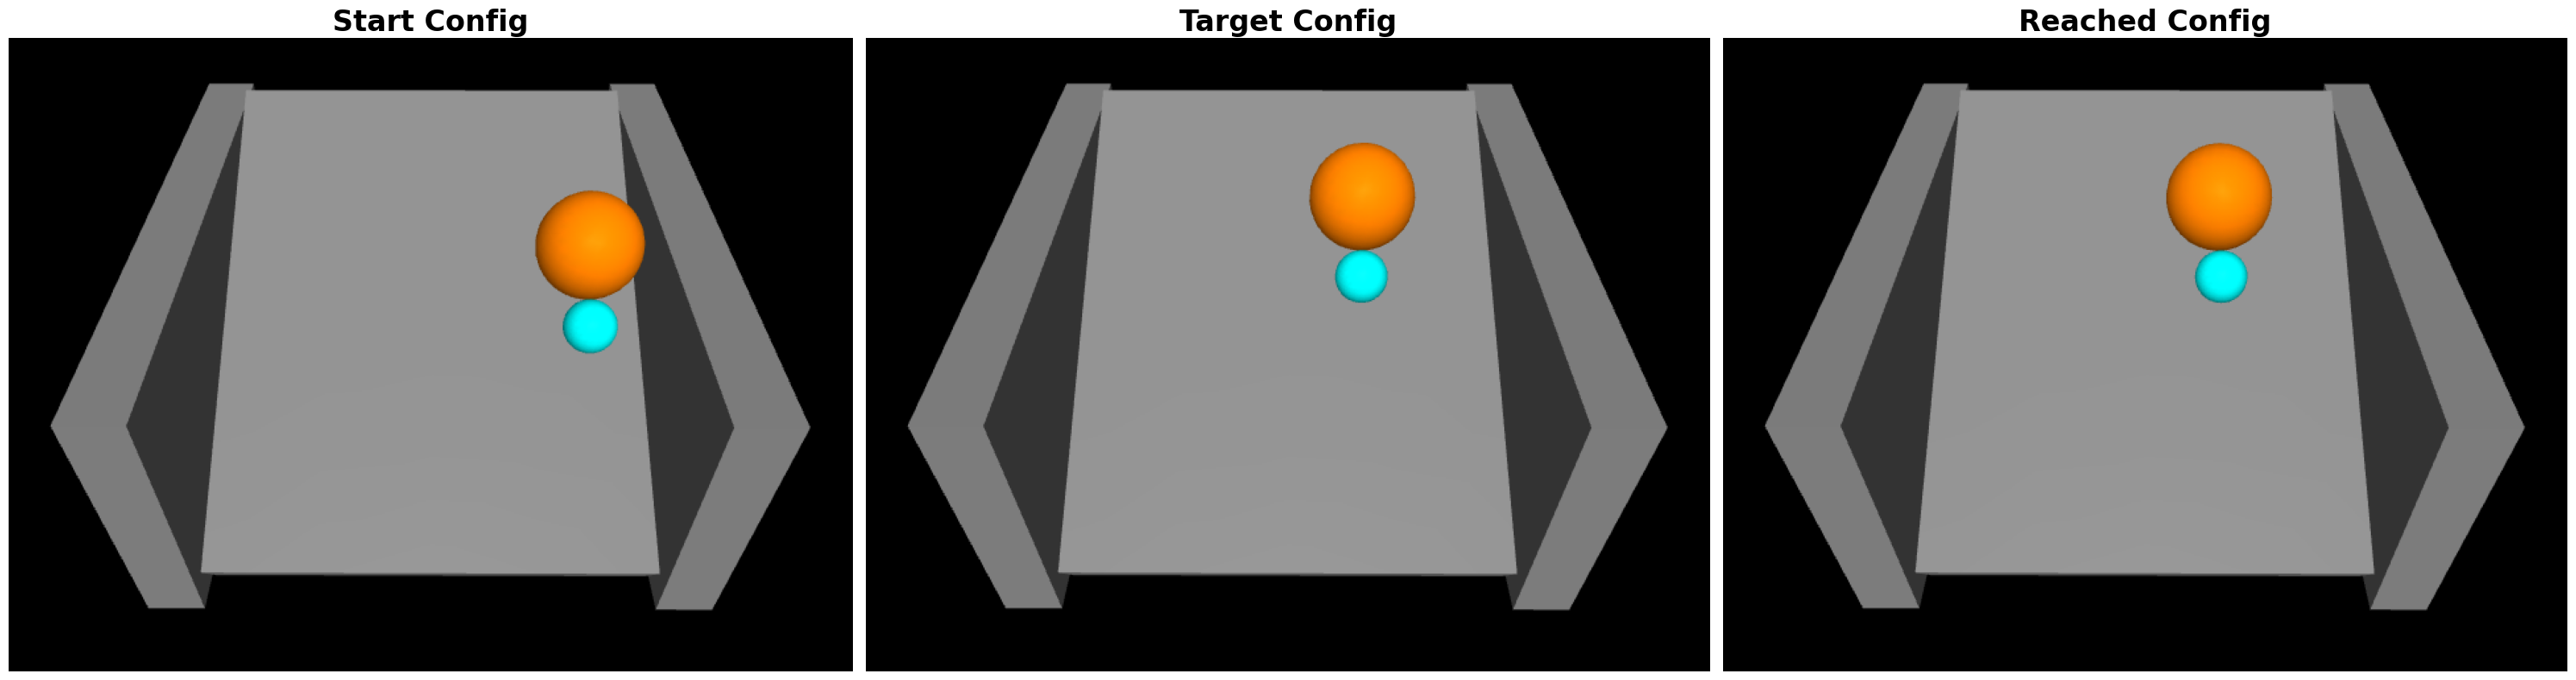

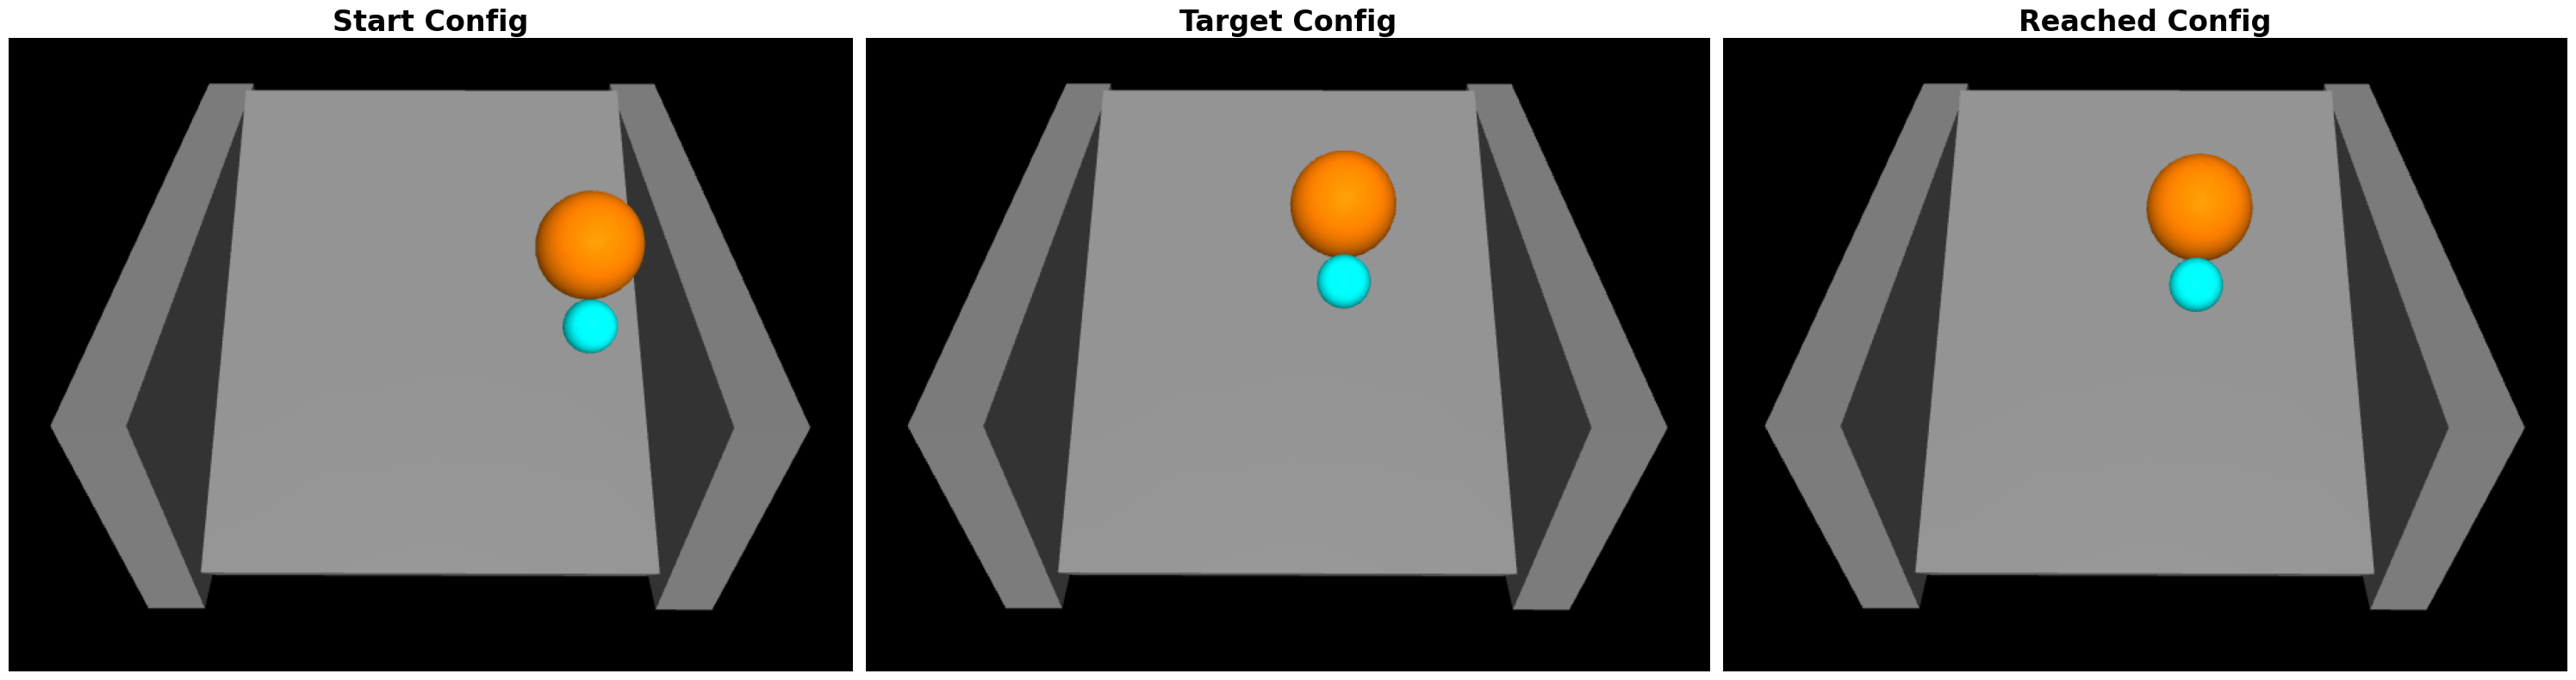

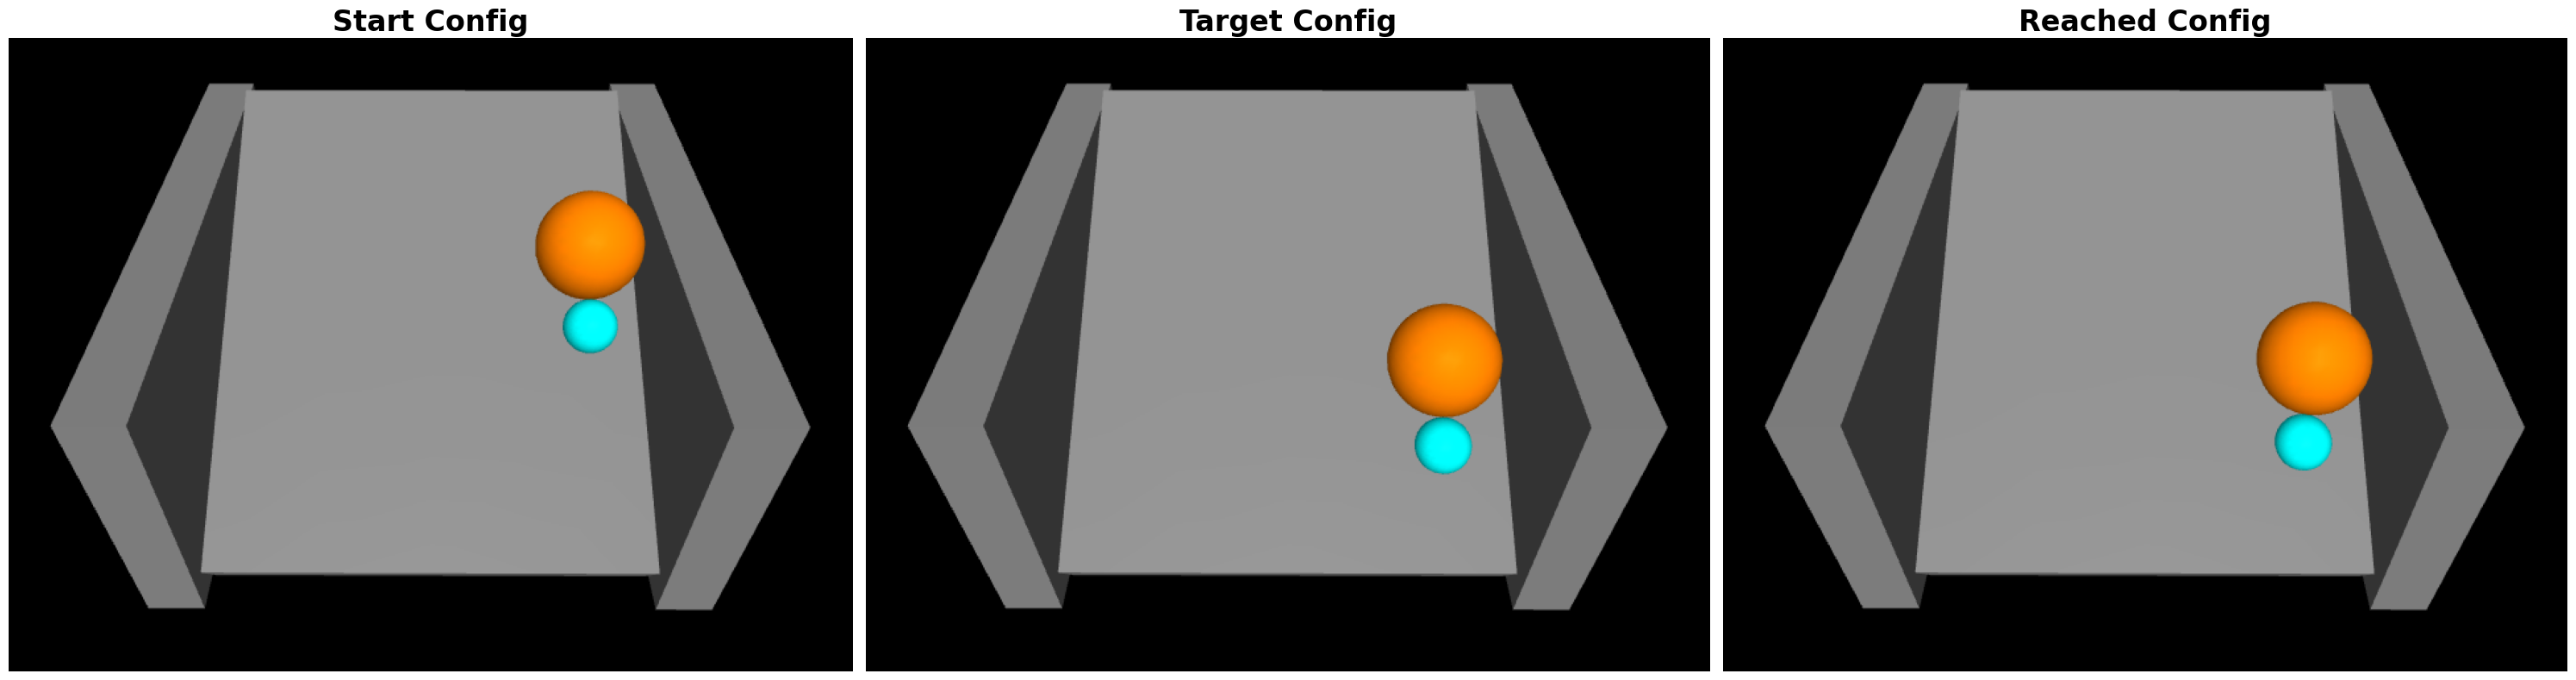

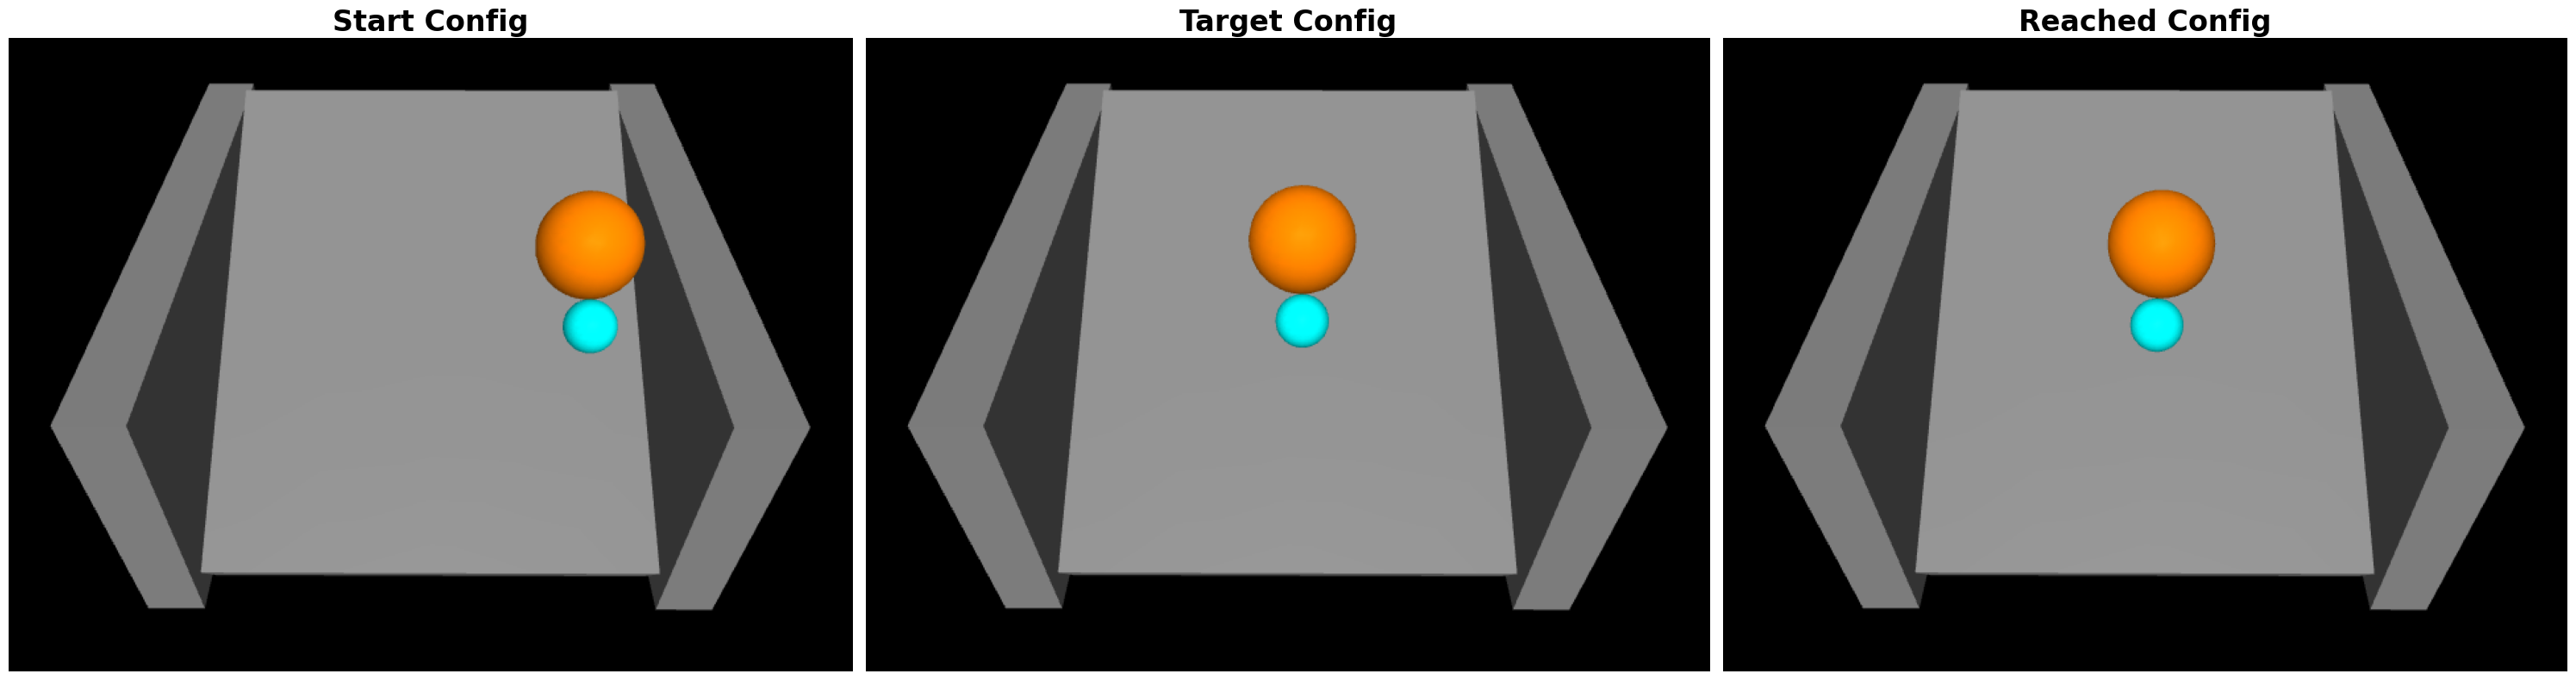

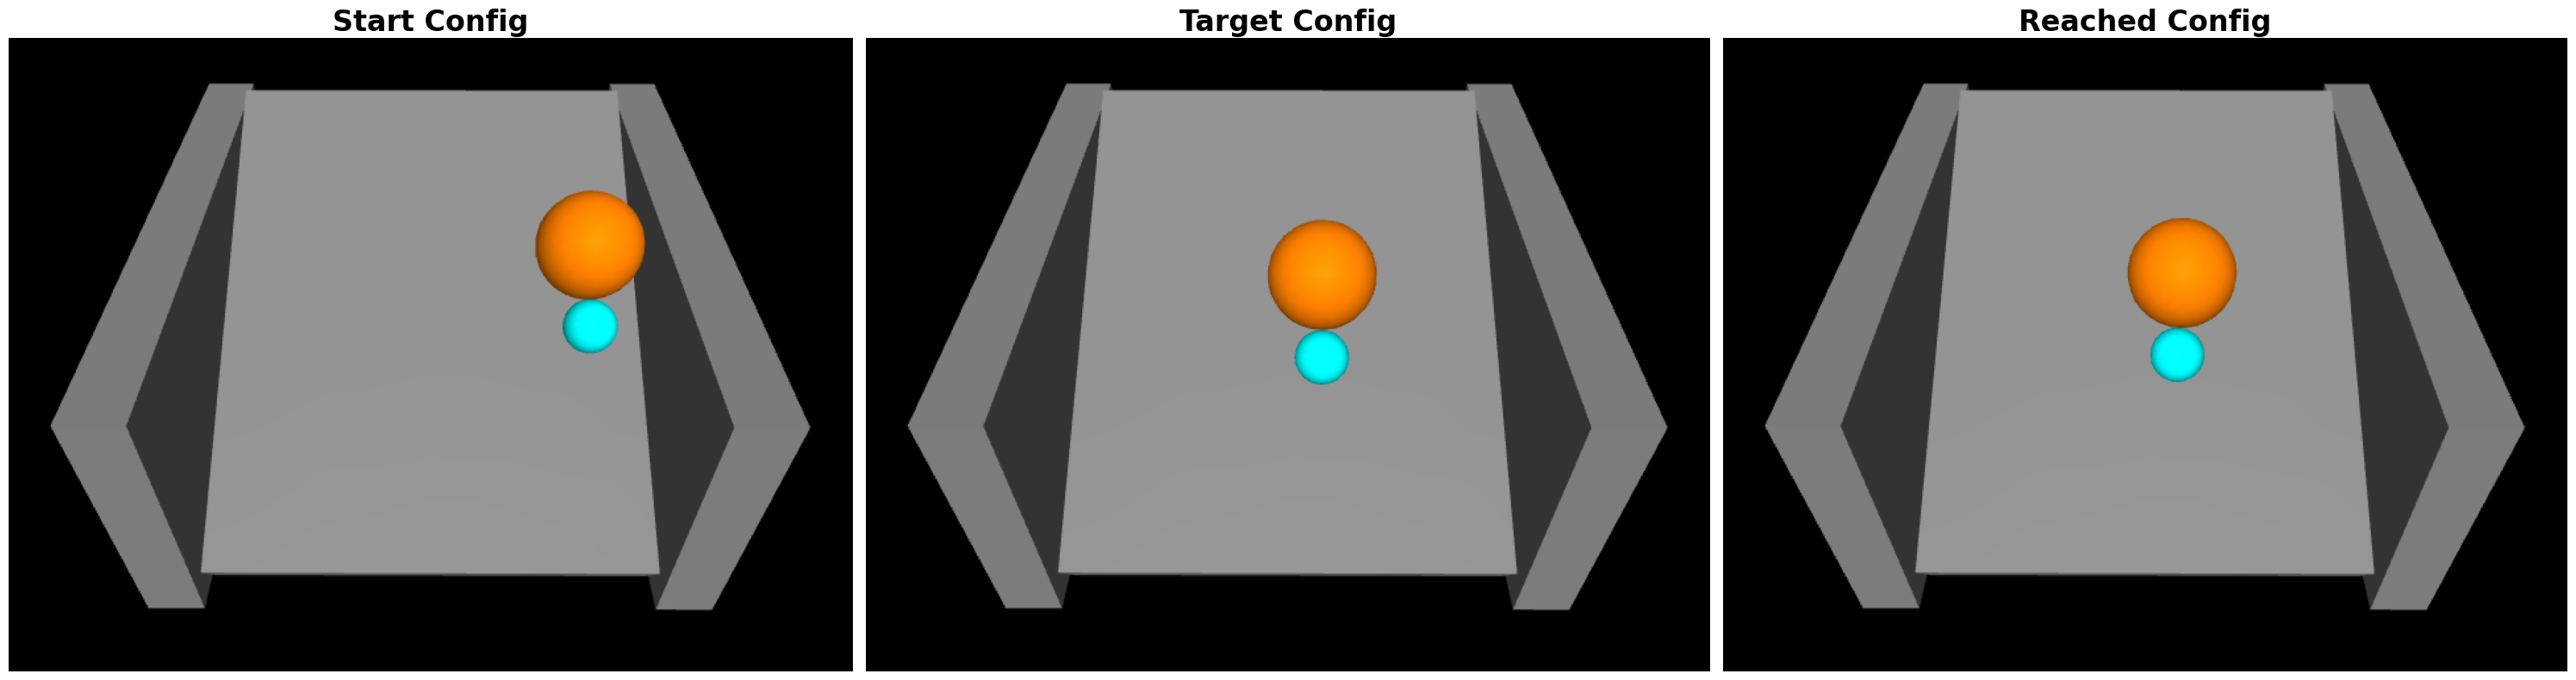

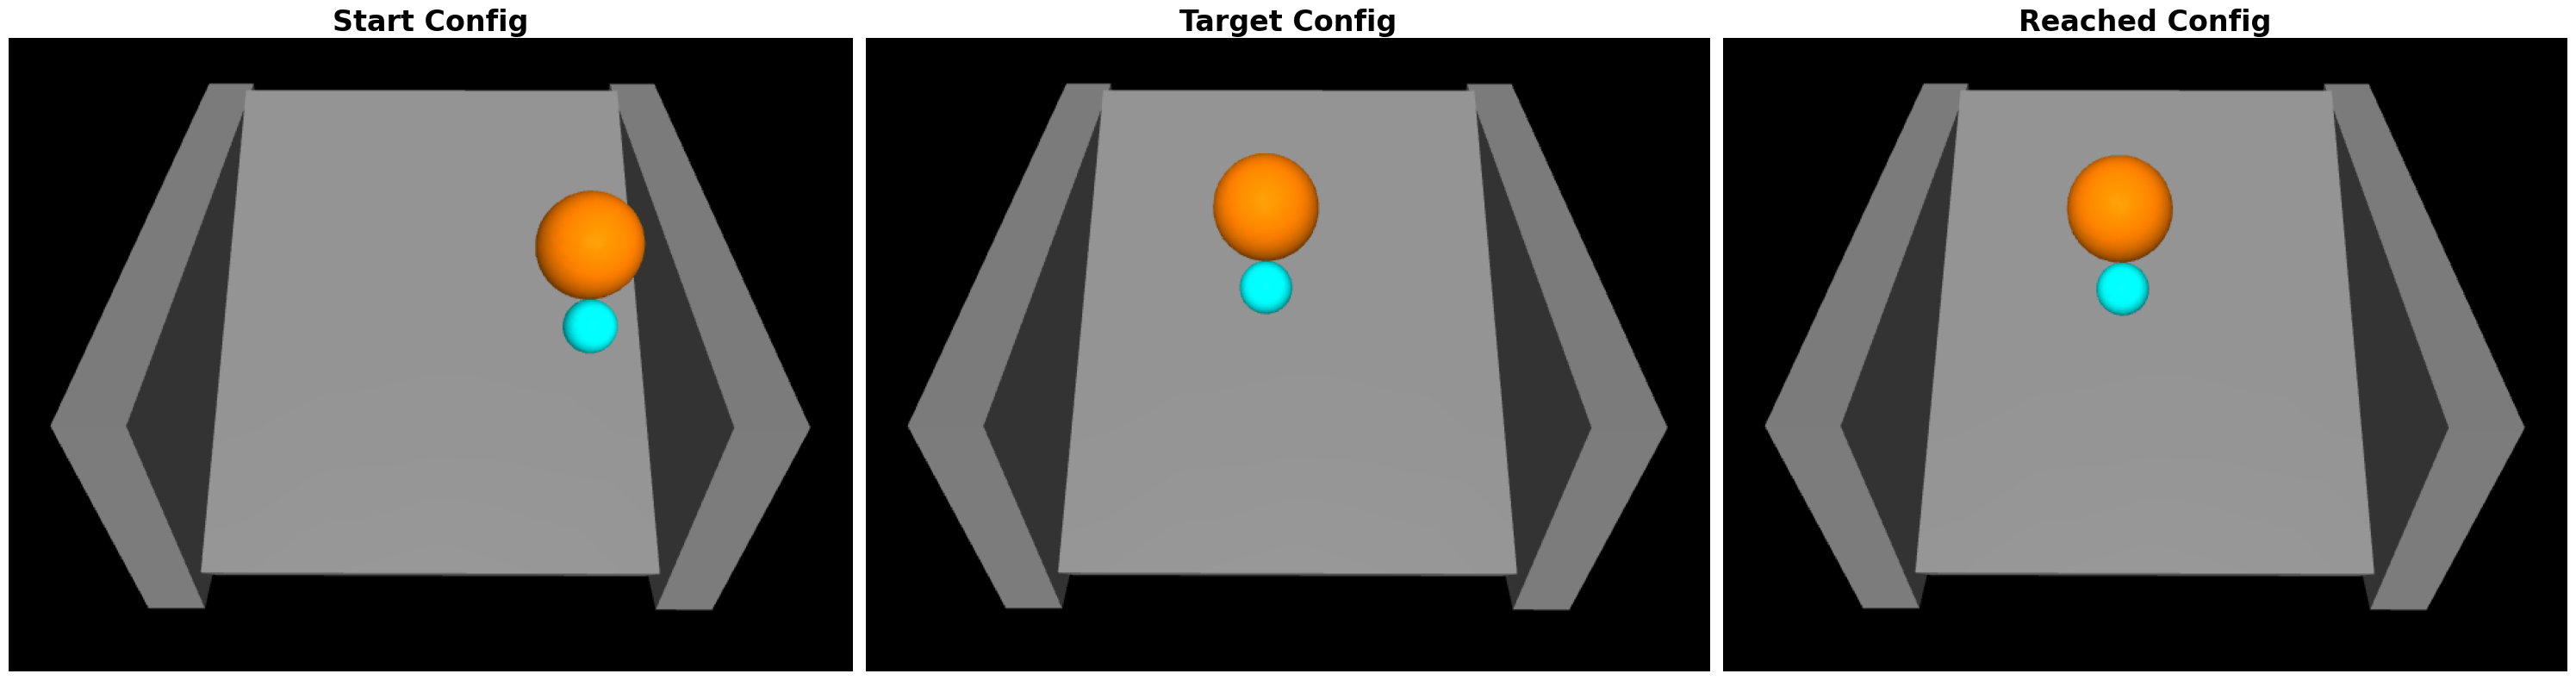

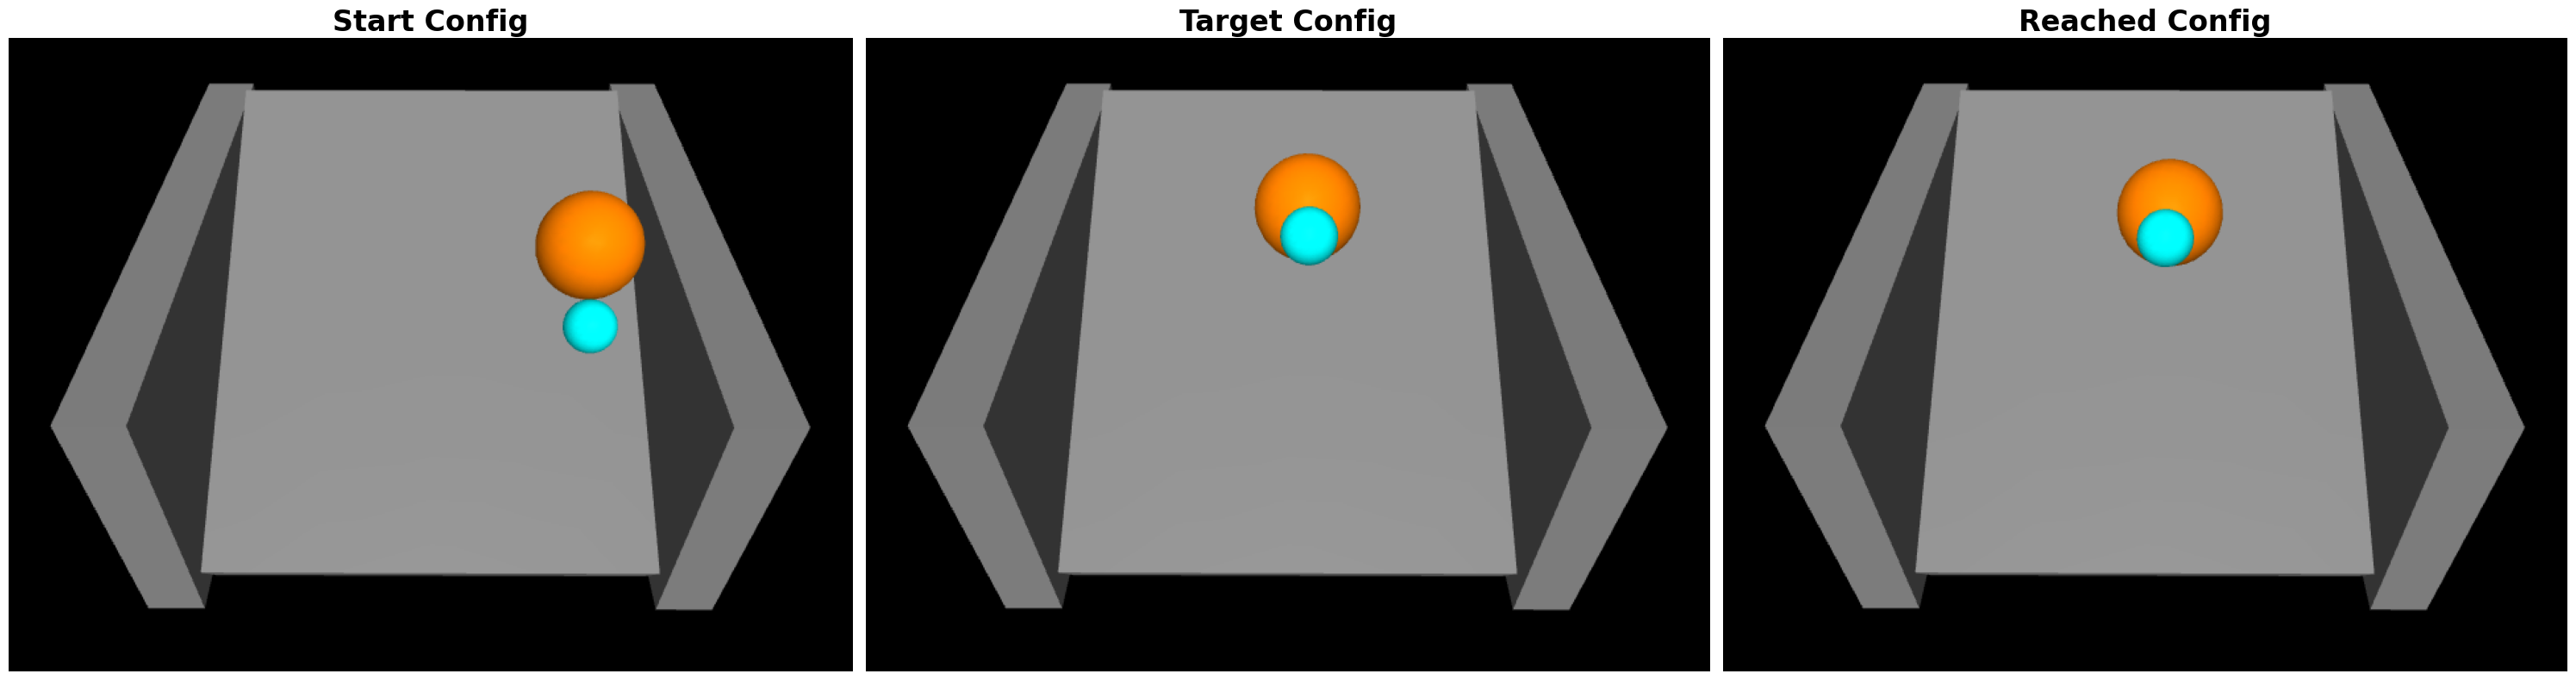

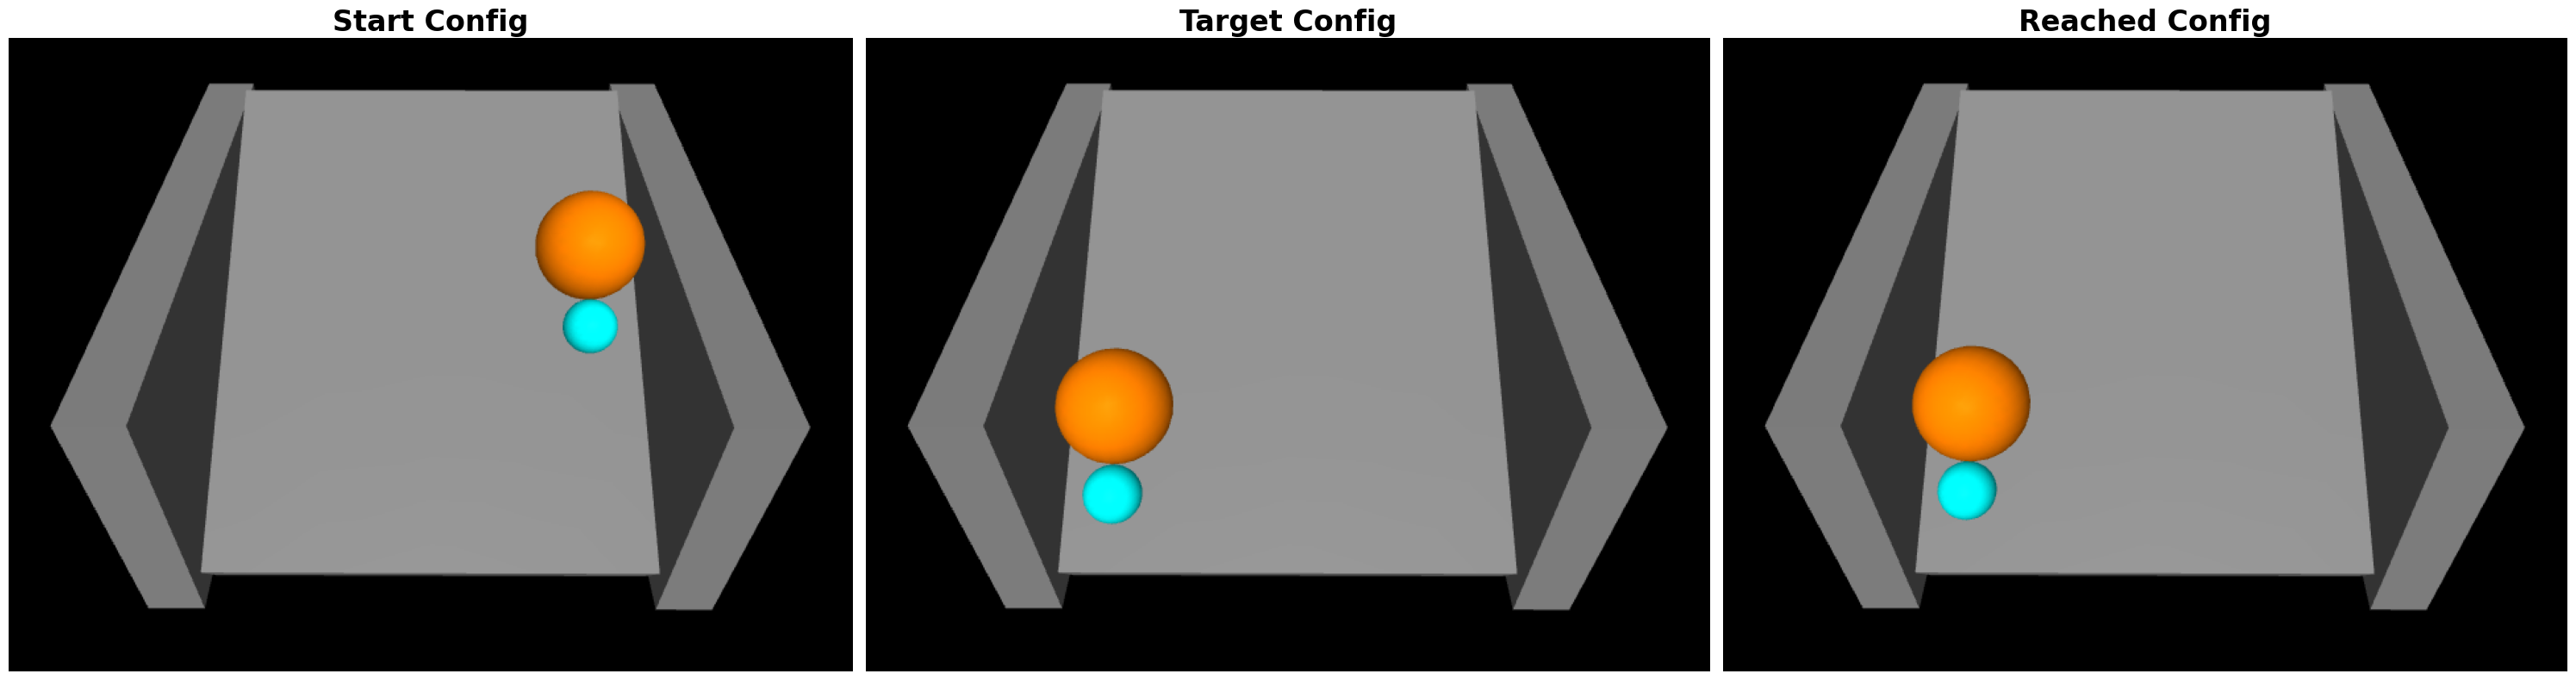

In [ ]:
if path:
    for i, path_idx in enumerate(valid_path_idxs):
        path = top_paths[path_idx]
        start_idx = top_paths_start[path_idx]
        end_idx = top_paths_goal[path_idx]
        e_vec = trees[end_idx][0]["state"][1] - path[-1]["state"][1]
        print("---- Sampled Path Data ----")
        print("Target config ids: ", [n["target_config_idx"] for n in path])
        print("Start idx: ", start_idx)
        print("End idx: ", end_idx)
        print("Cost: ", top_costs[path_idx])
        print("Error vec: ", e_vec)
        print("Error vec (with mask): ", e_vec * q_mask)
        print("Sampled Path Length: ", len(path))

        start_state = trees[start_idx][0]["state"][1]
        target_state = trees[end_idx][0]["state"][1]
        sim = MjSim(
            mujoco_xml, tau_sim=sim_cfg.tau_sim, interpolate=sim_cfg.interpolate_actions,
            joints_are_same_as_ctrl=sim_cfg.joints_are_same_as_ctrl, view=False, use_spline_ref=sim_cfg.use_spline_ref
        )
        play_path(path, sim, start_state, target_state, tau_action=sim_cfg.tau_action, camera=cfg.RRT.sim.camera, reset_state=True, save_intro_as=f"paths/intro{i}.png", save_as=f"paths/path{i}.gif")


---- Sampled Path Data ----
Target config ids:  [-1, np.int64(13), np.int64(6), np.int64(0), np.int64(7), np.int64(22), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(11), np.int64(8), np.int64(0)]
Start idx:  1
End idx:  0
Cost:  0.00012448171569255168
Error vec:  [-8.83020622e-03 -5.80400206e-03  3.36405783e-03  9.81294506e-04
 -4.23817509e-04 -6.02734242e-04  9.39279609e-01  2.85472924e-01
  7.48519866e-01  6.50511801e-01]
Error vec (with mask):  [-0.00883021 -0.005804    0.00336406  0.00098129 -0.00042382 -0.00060273
  0.          0.          0.          0.        ]
Sampled Path Length:  14
Playing path with length 14
---- Sampled Path Data ----
Target config ids:  [-1, np.int64(13), np.int64(6), np.int64(0), np.int64(7), np.int64(18), np.int64(24), np.int64(19), np.int64(19), np.int64(20), np.int64(22), np.int64(22)]
Start idx:  1
End idx:  2
Cost:  0.00031329666997423263
Error vec:  [-0.00066867  0.00557555  0.01183938 -0.00332014  0.01006378  0.0054119

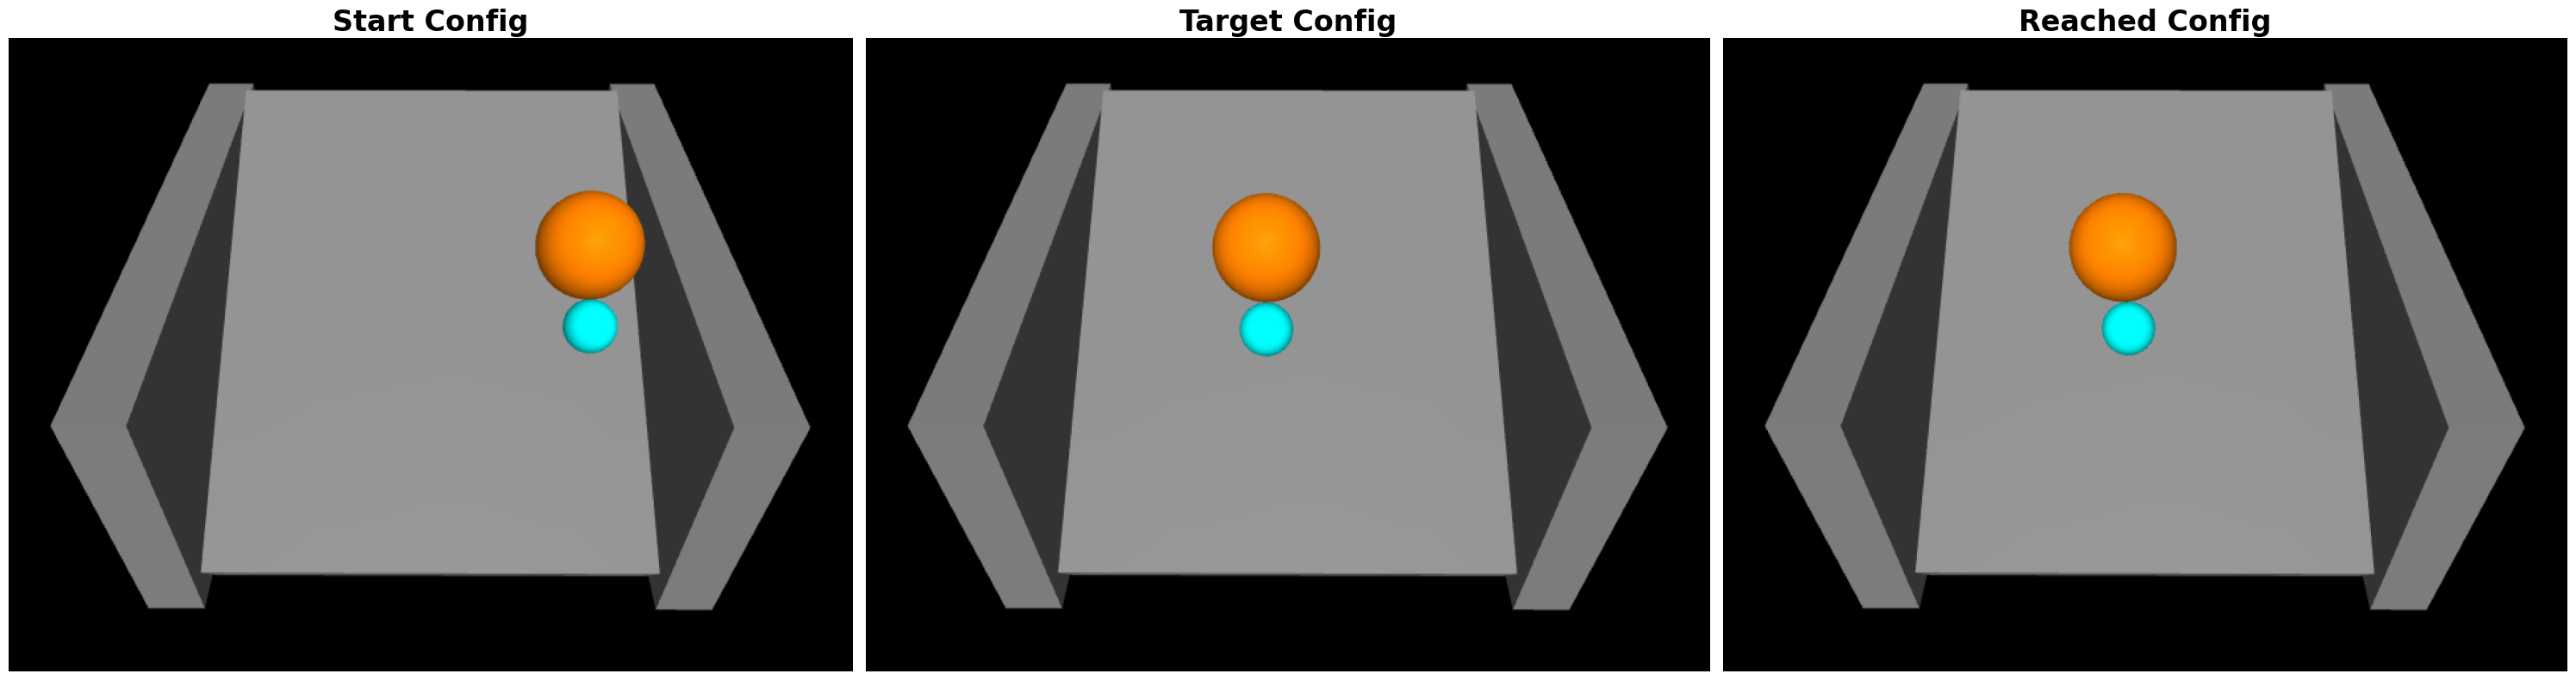

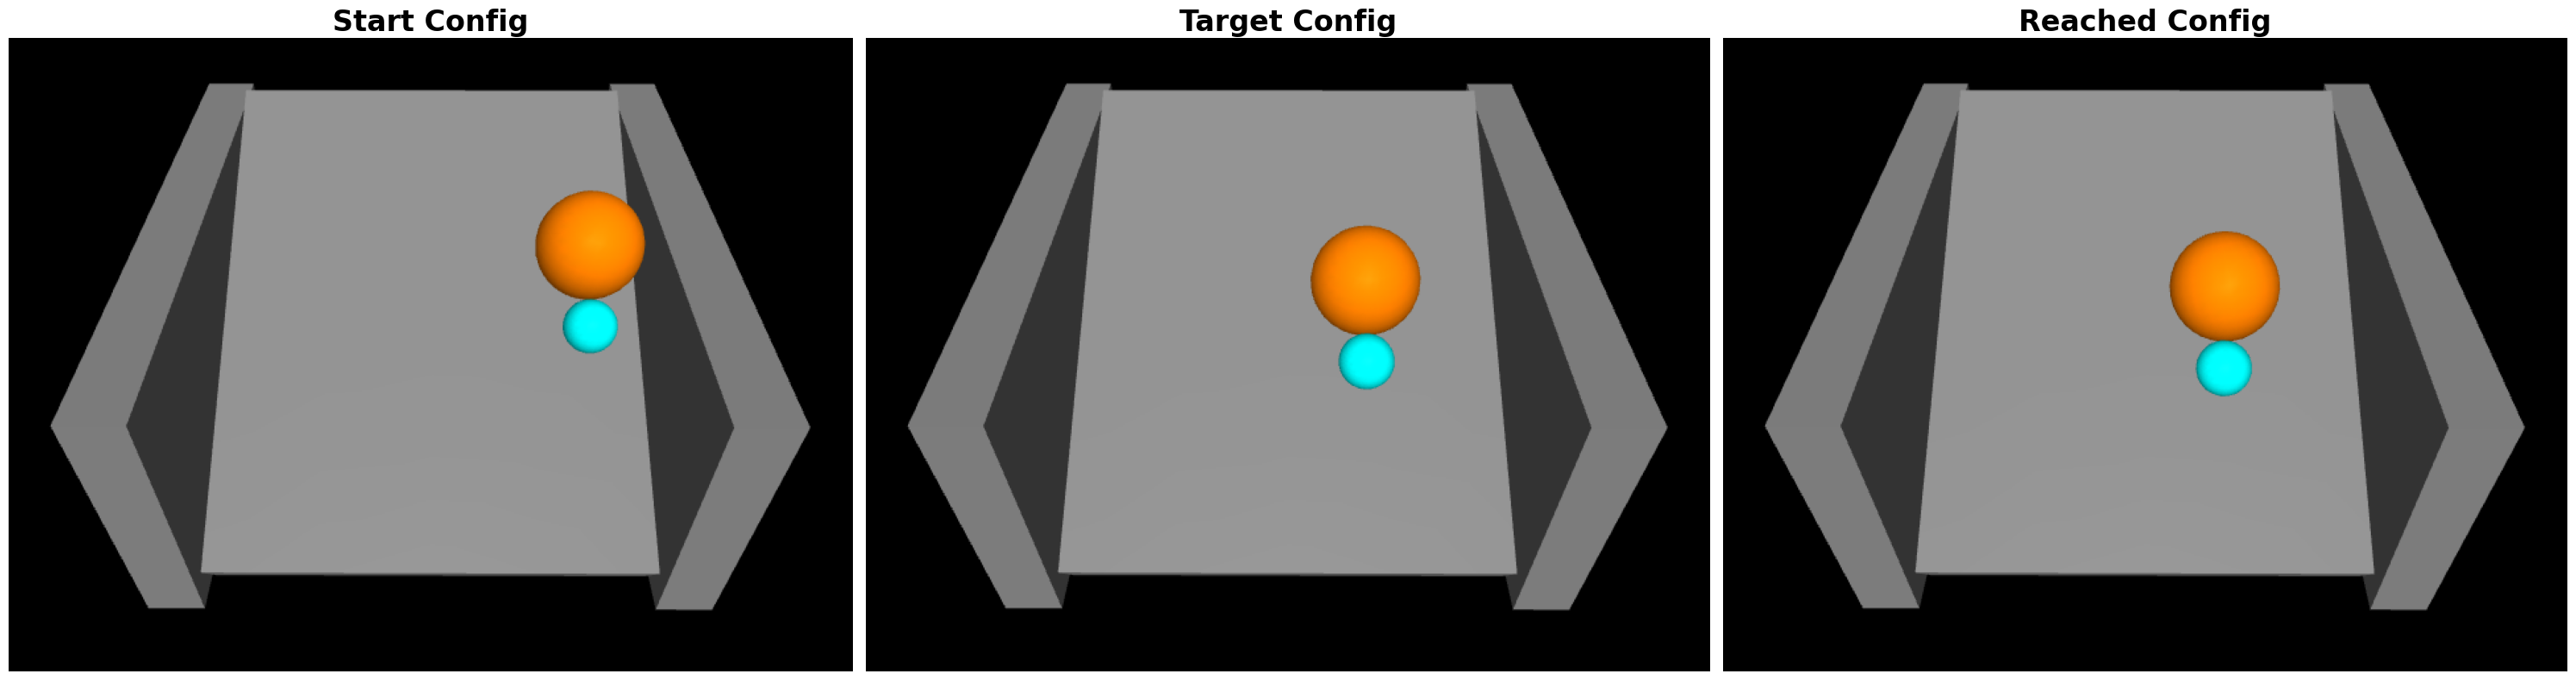

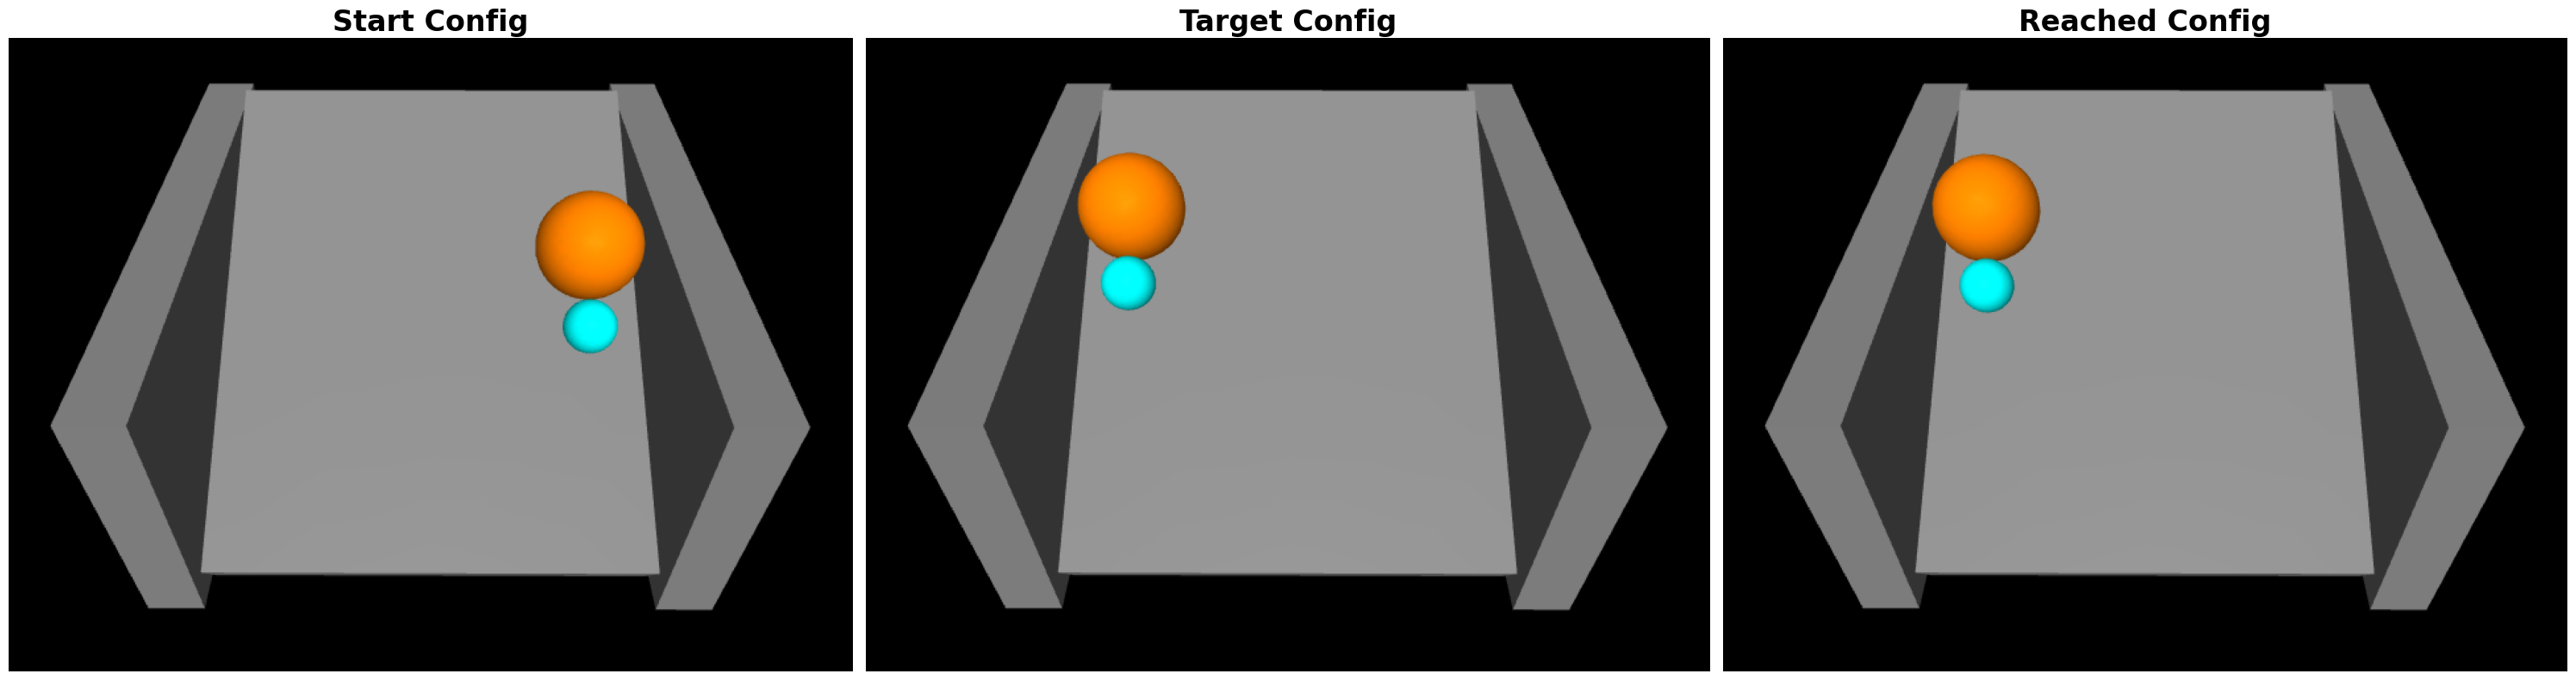

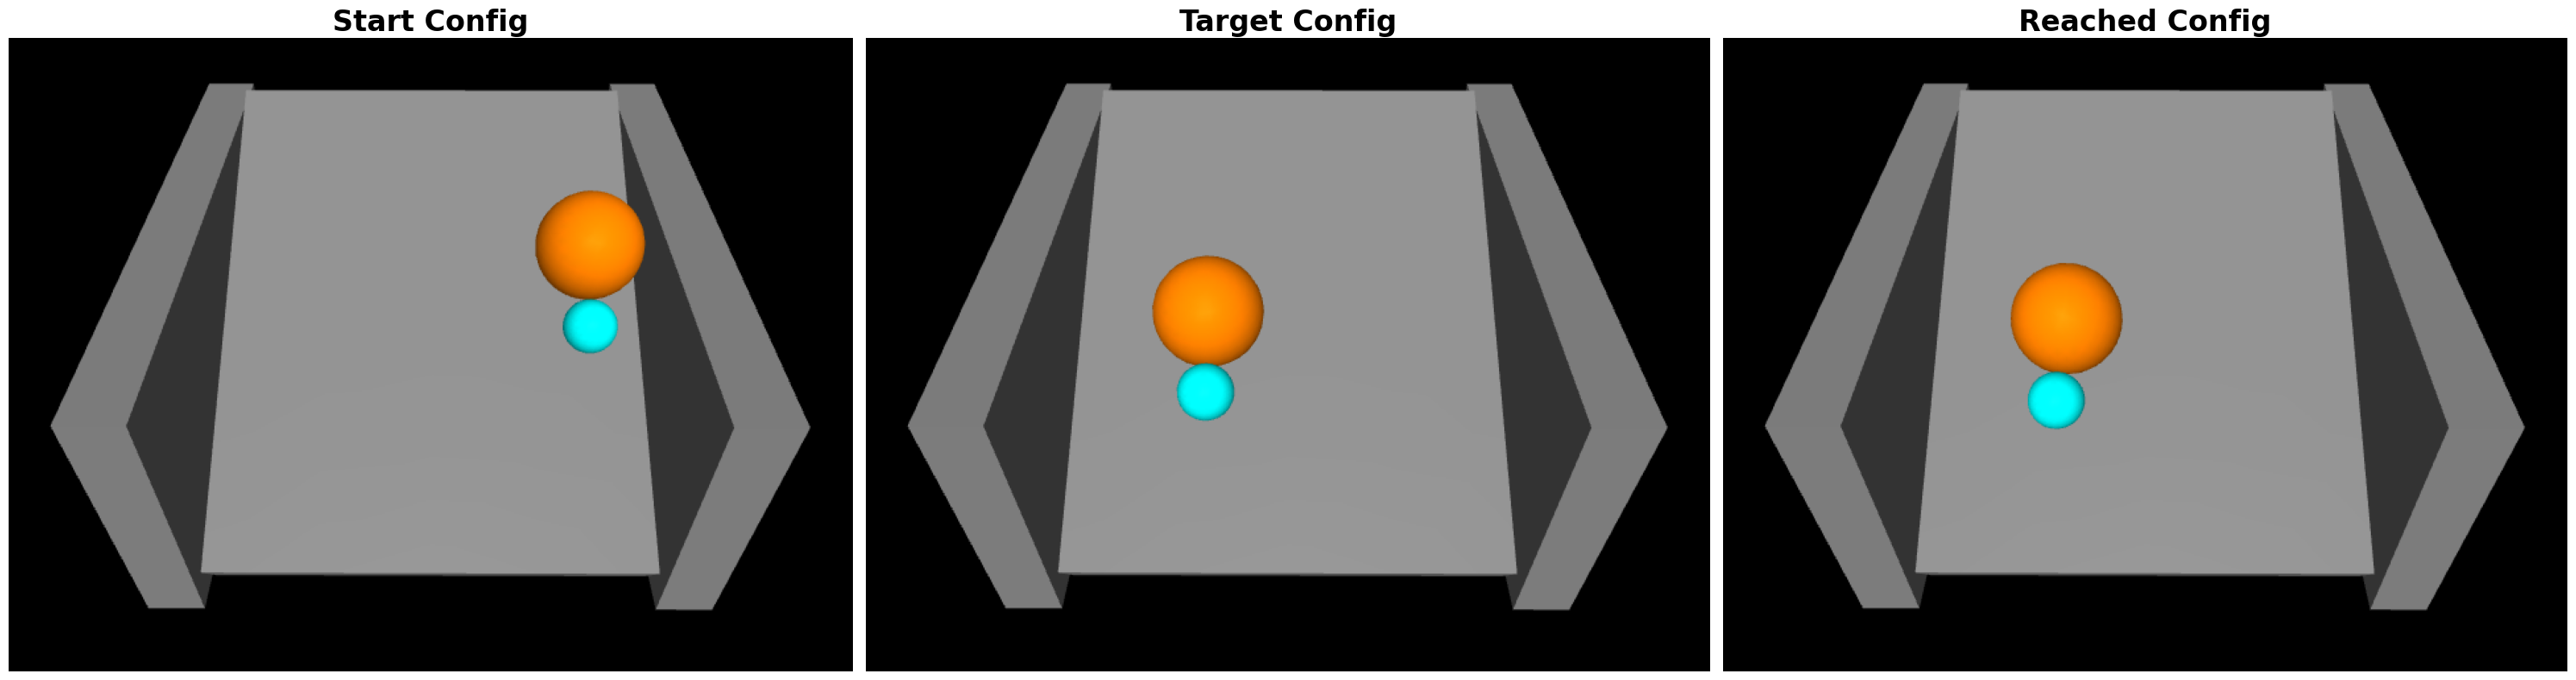

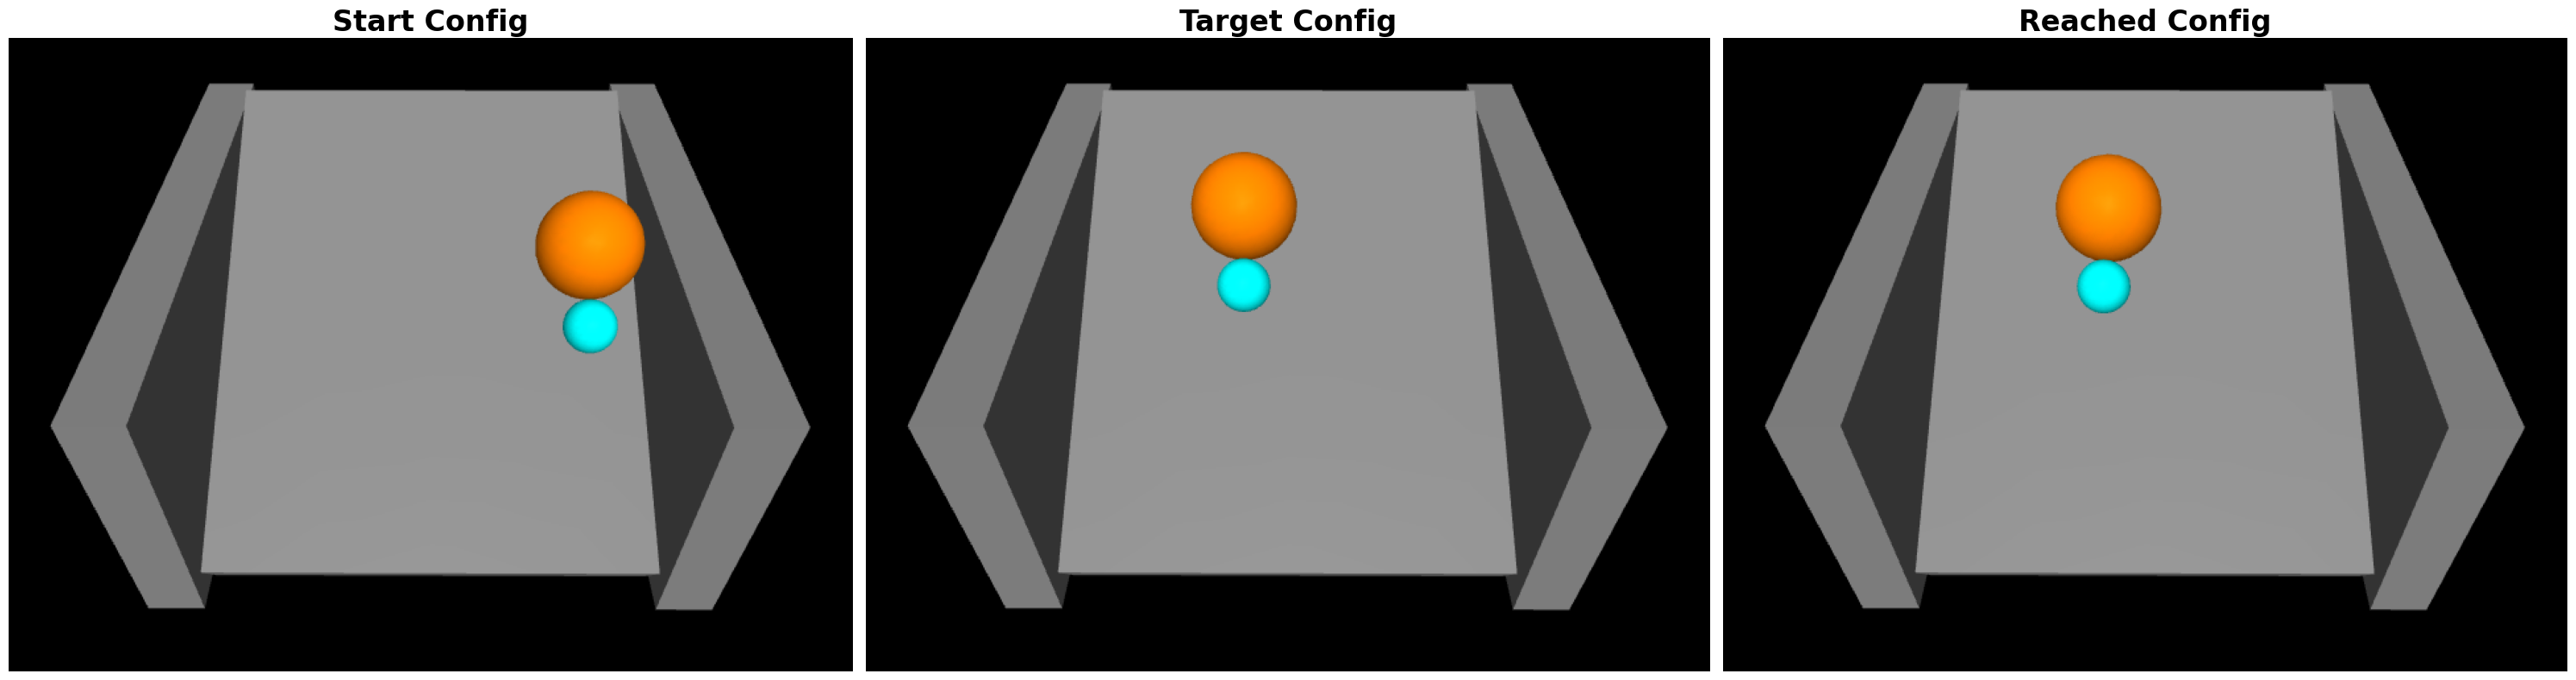

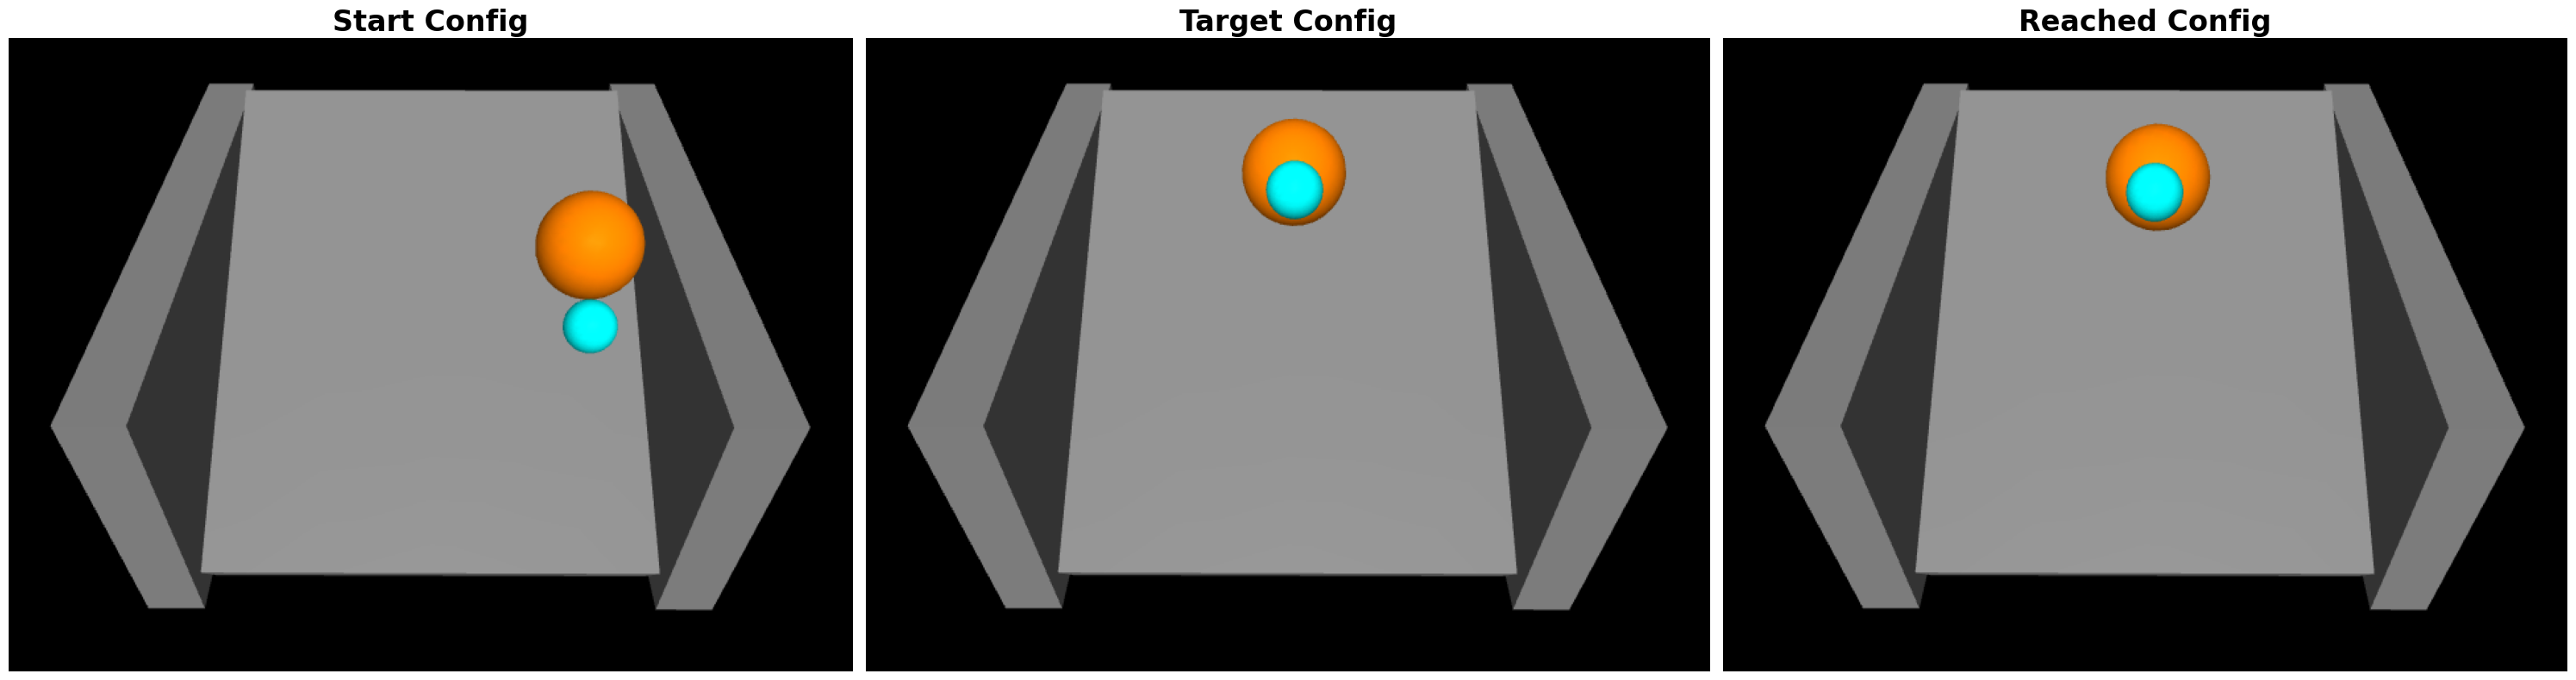

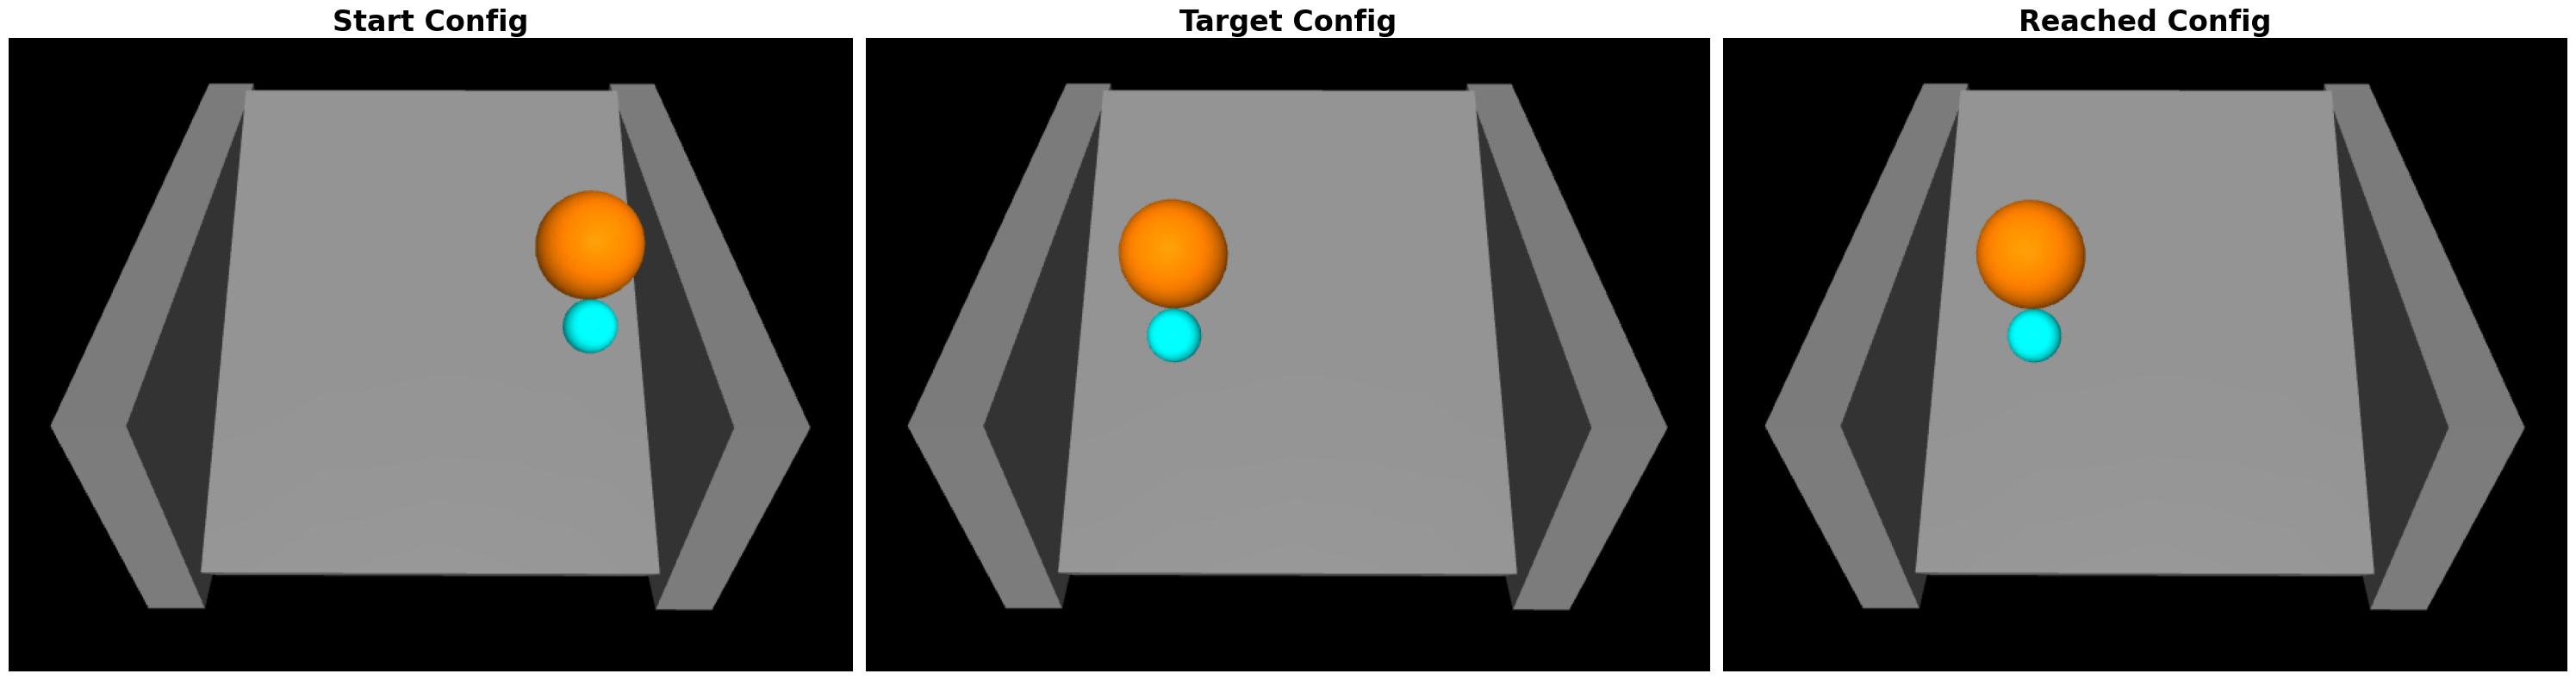

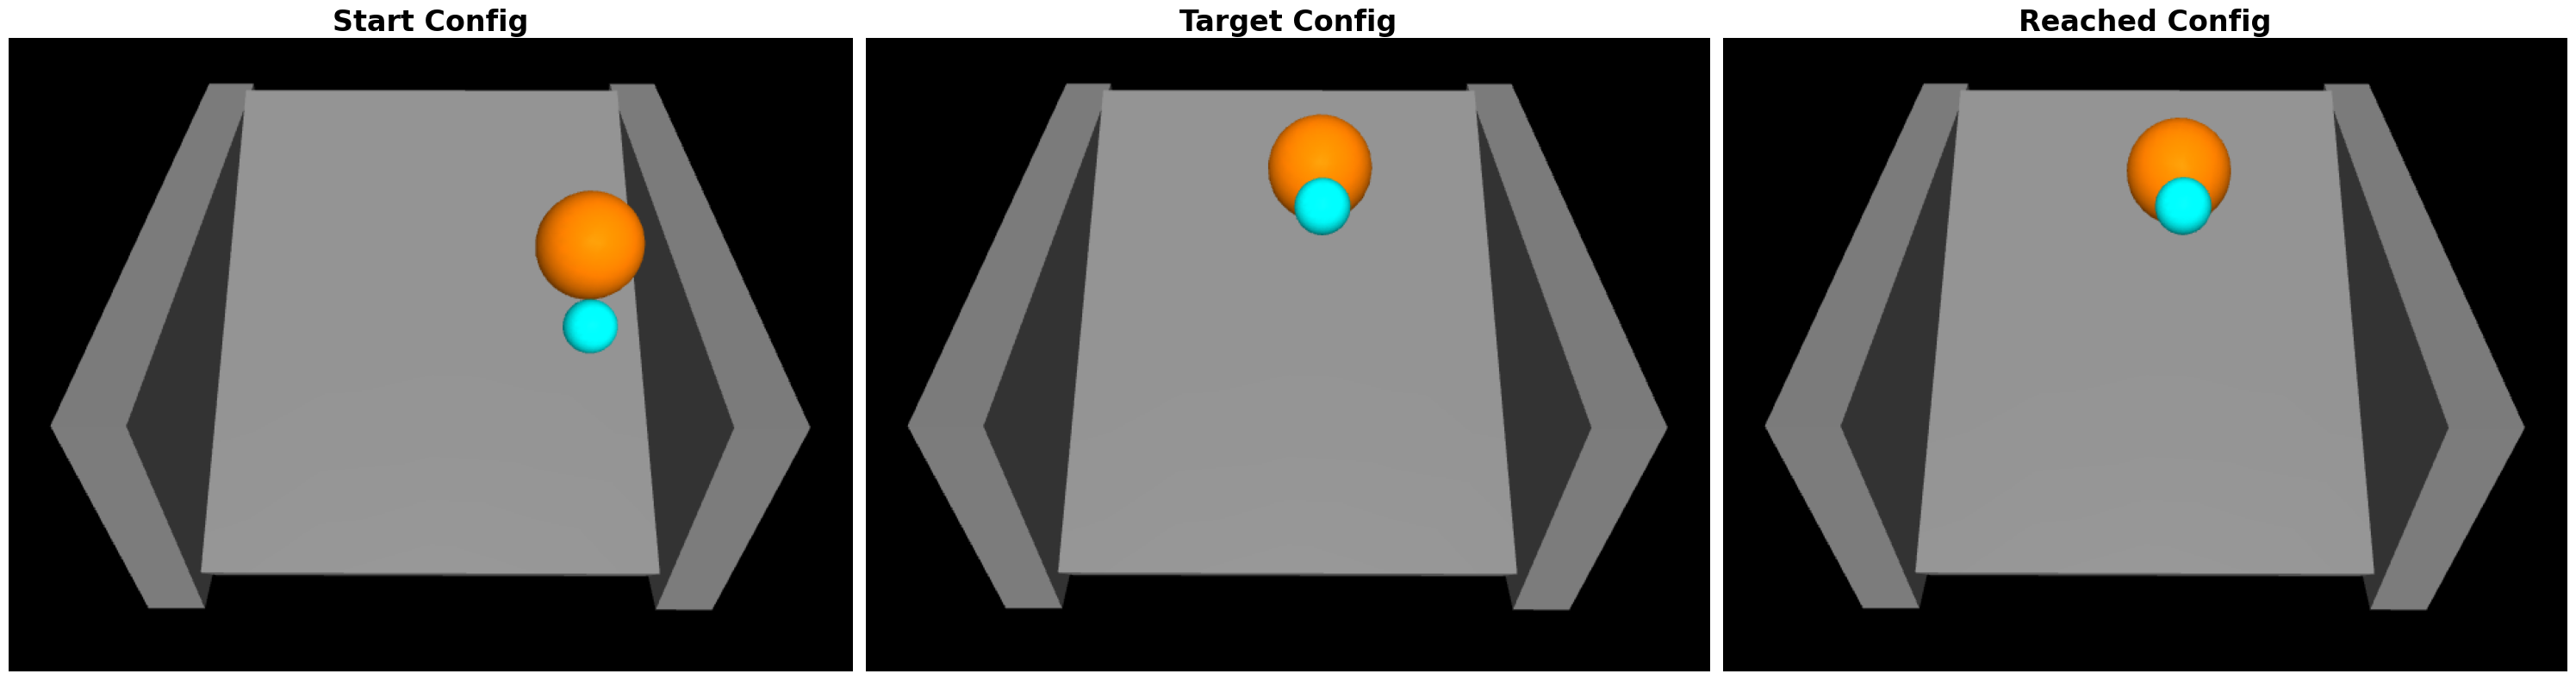

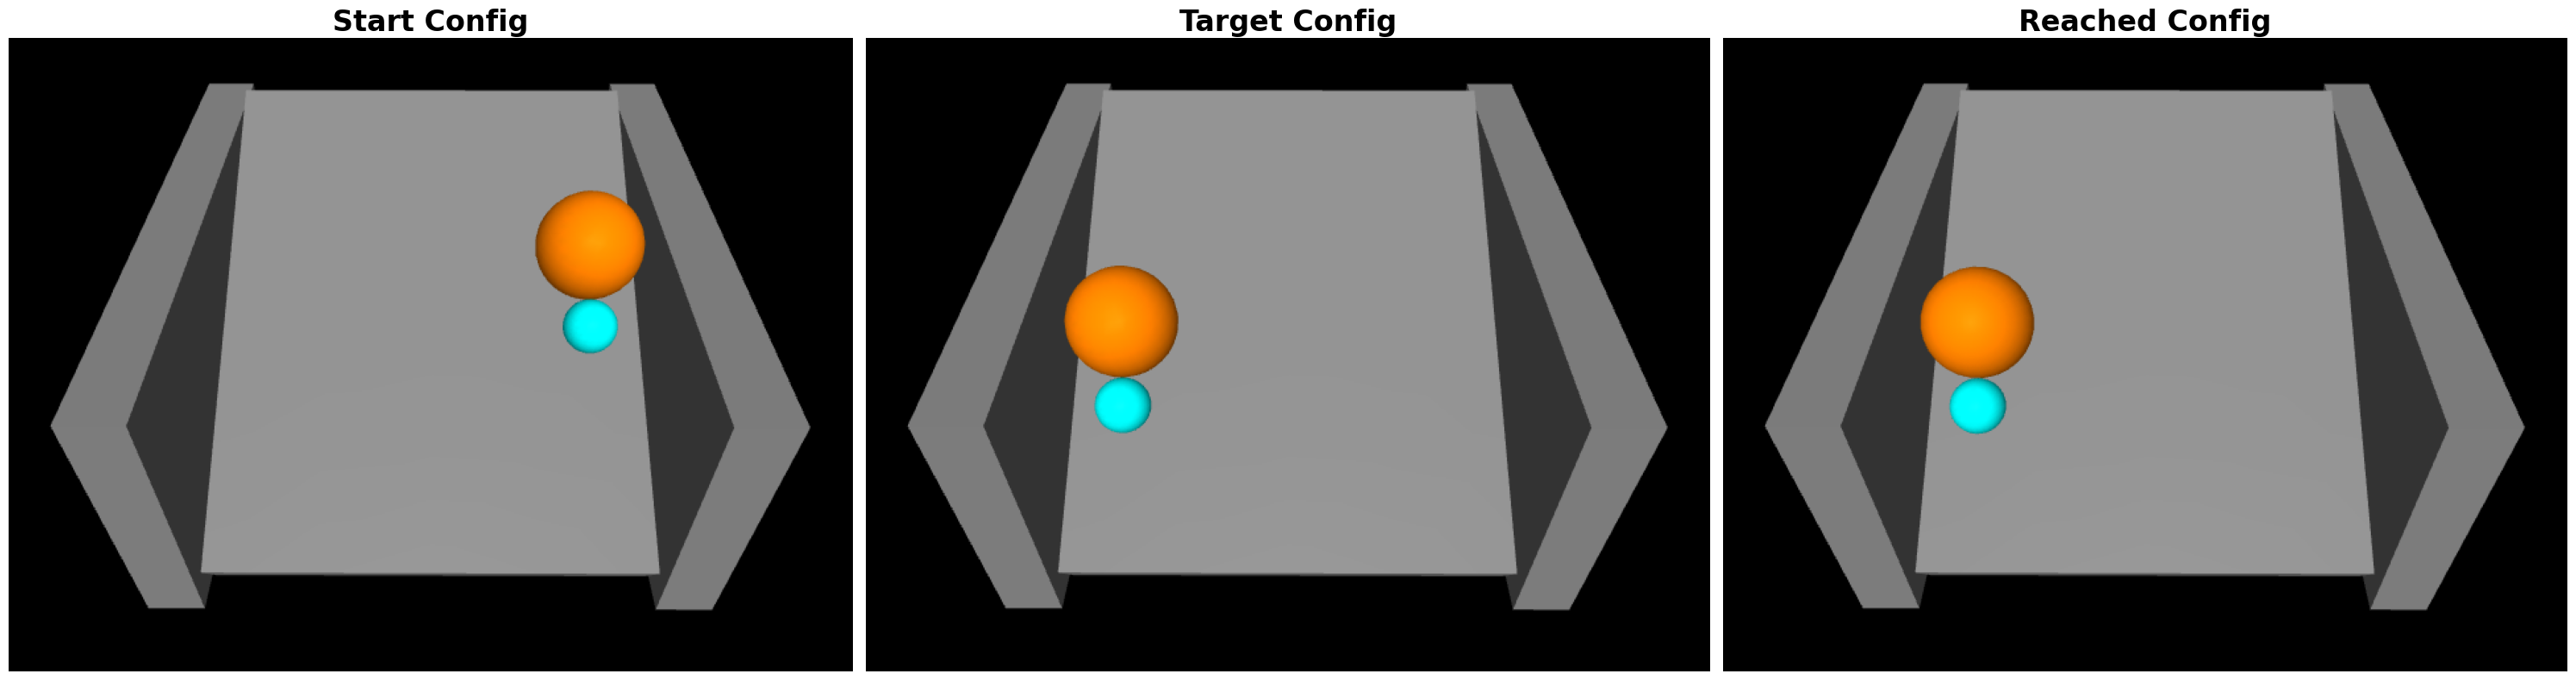

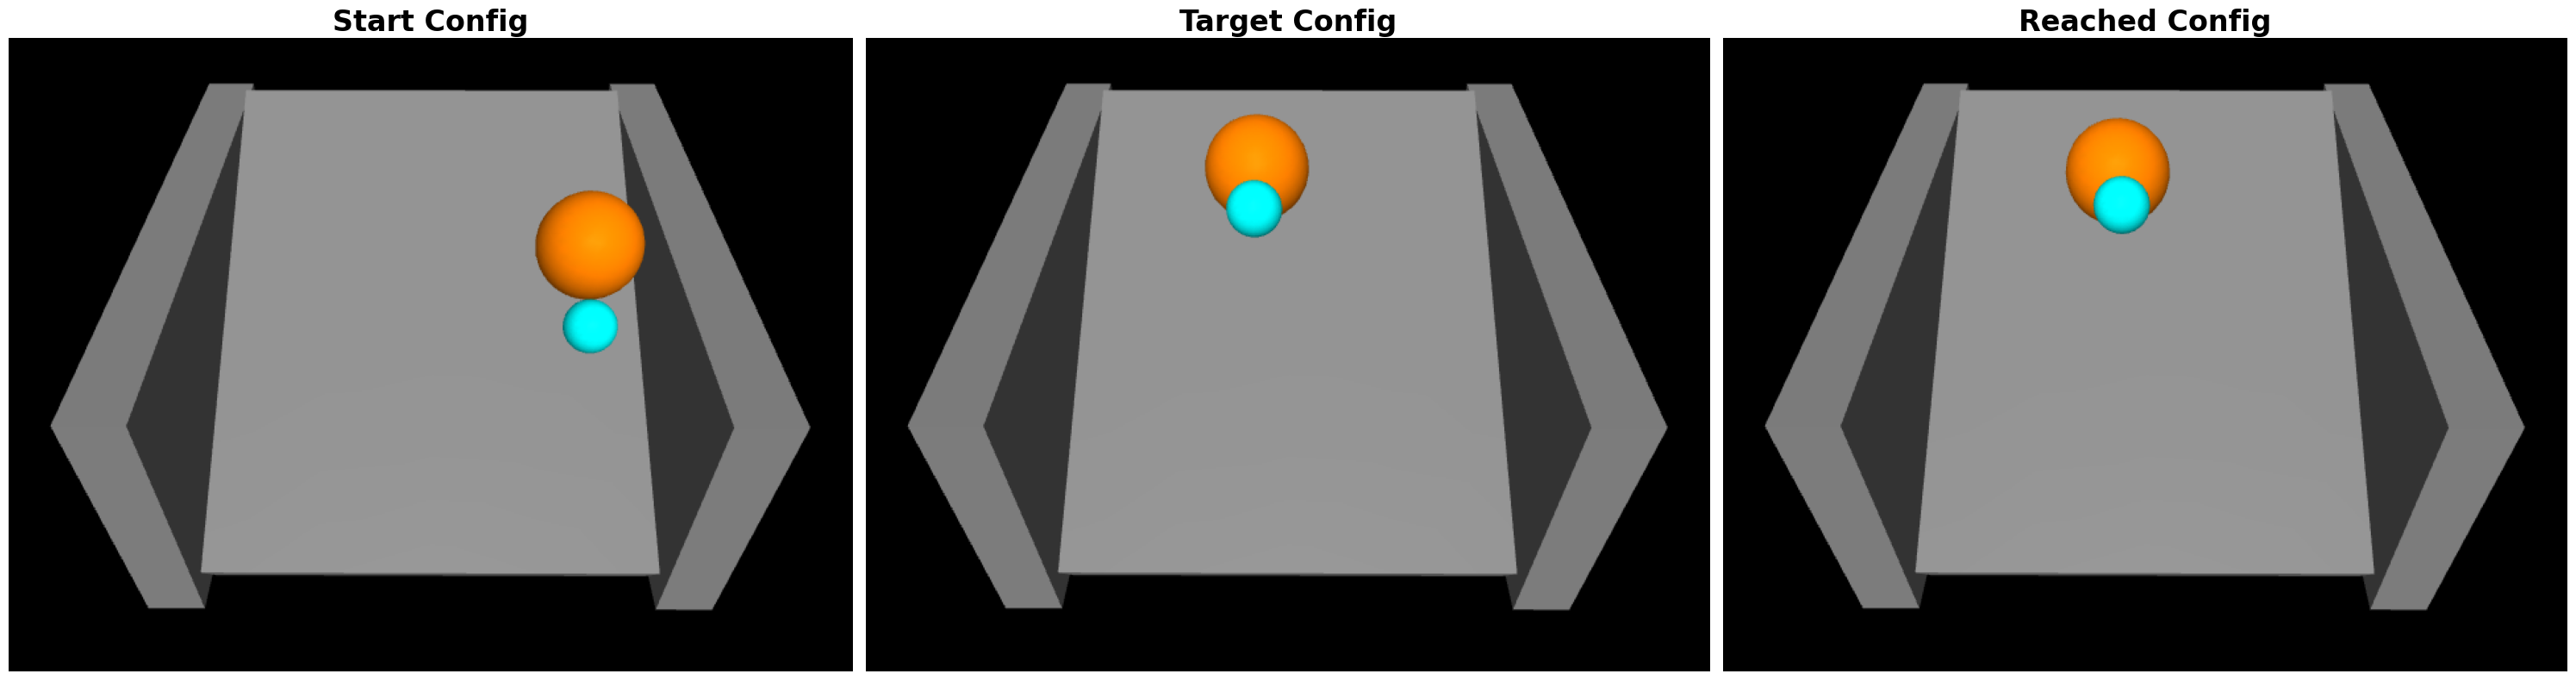

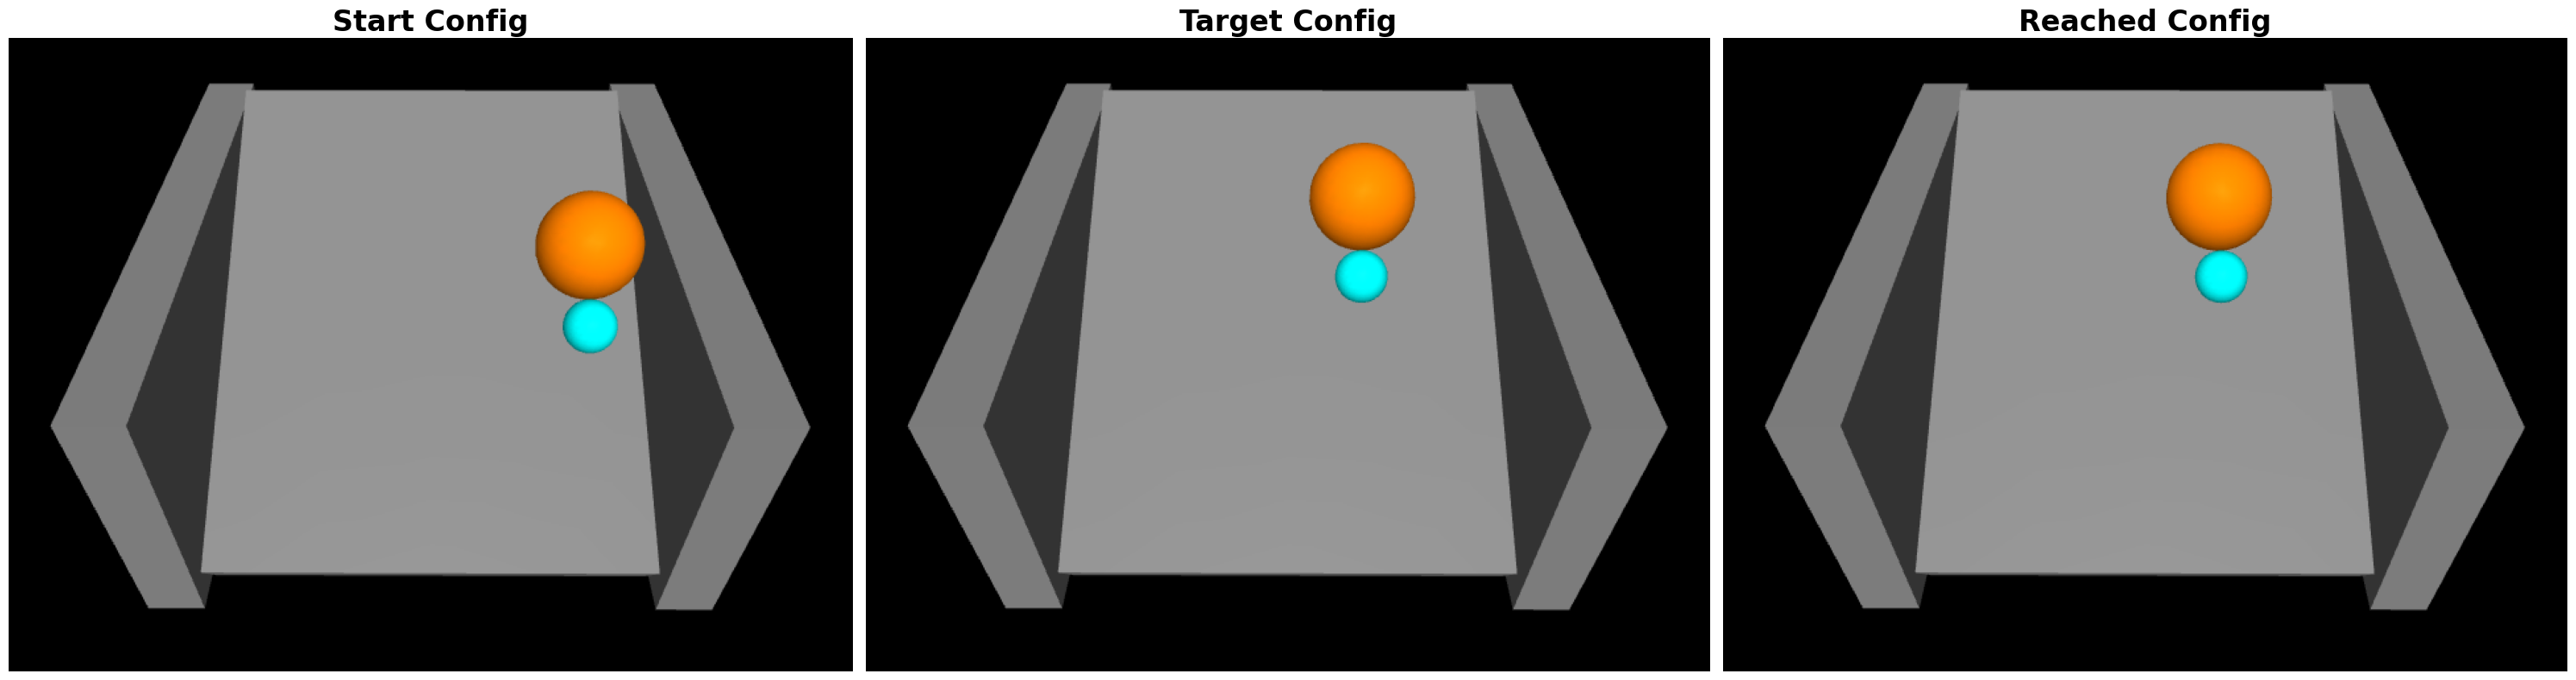

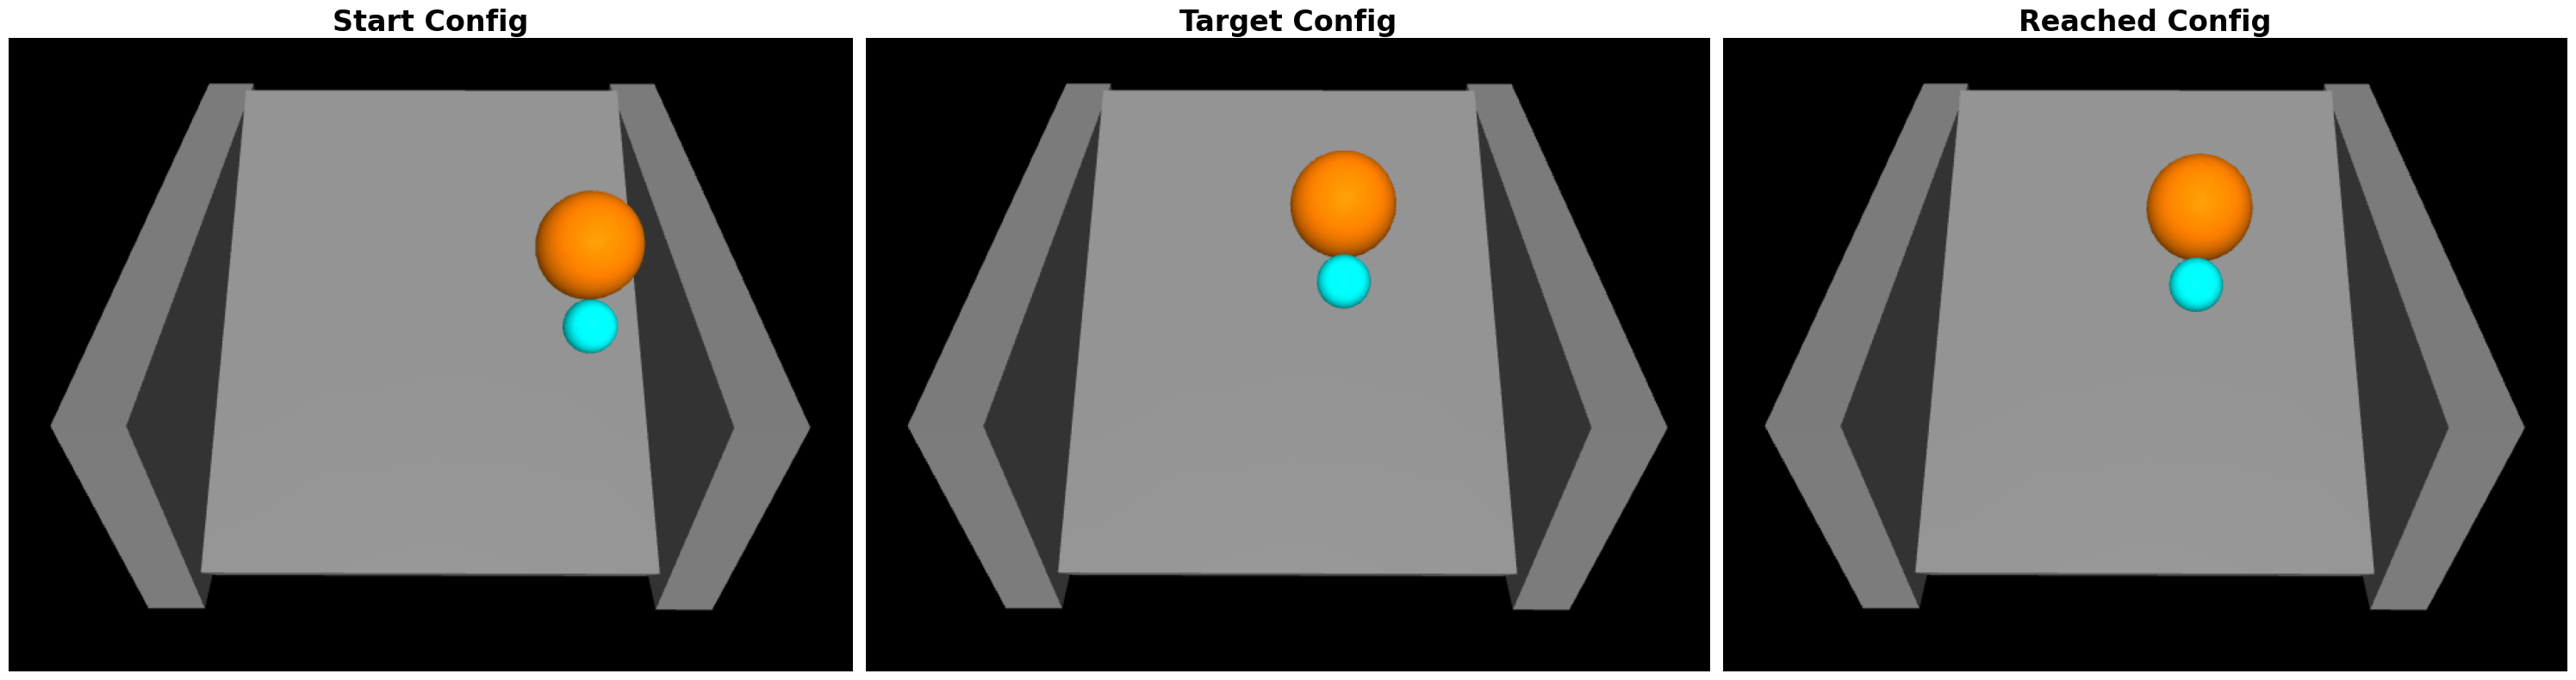

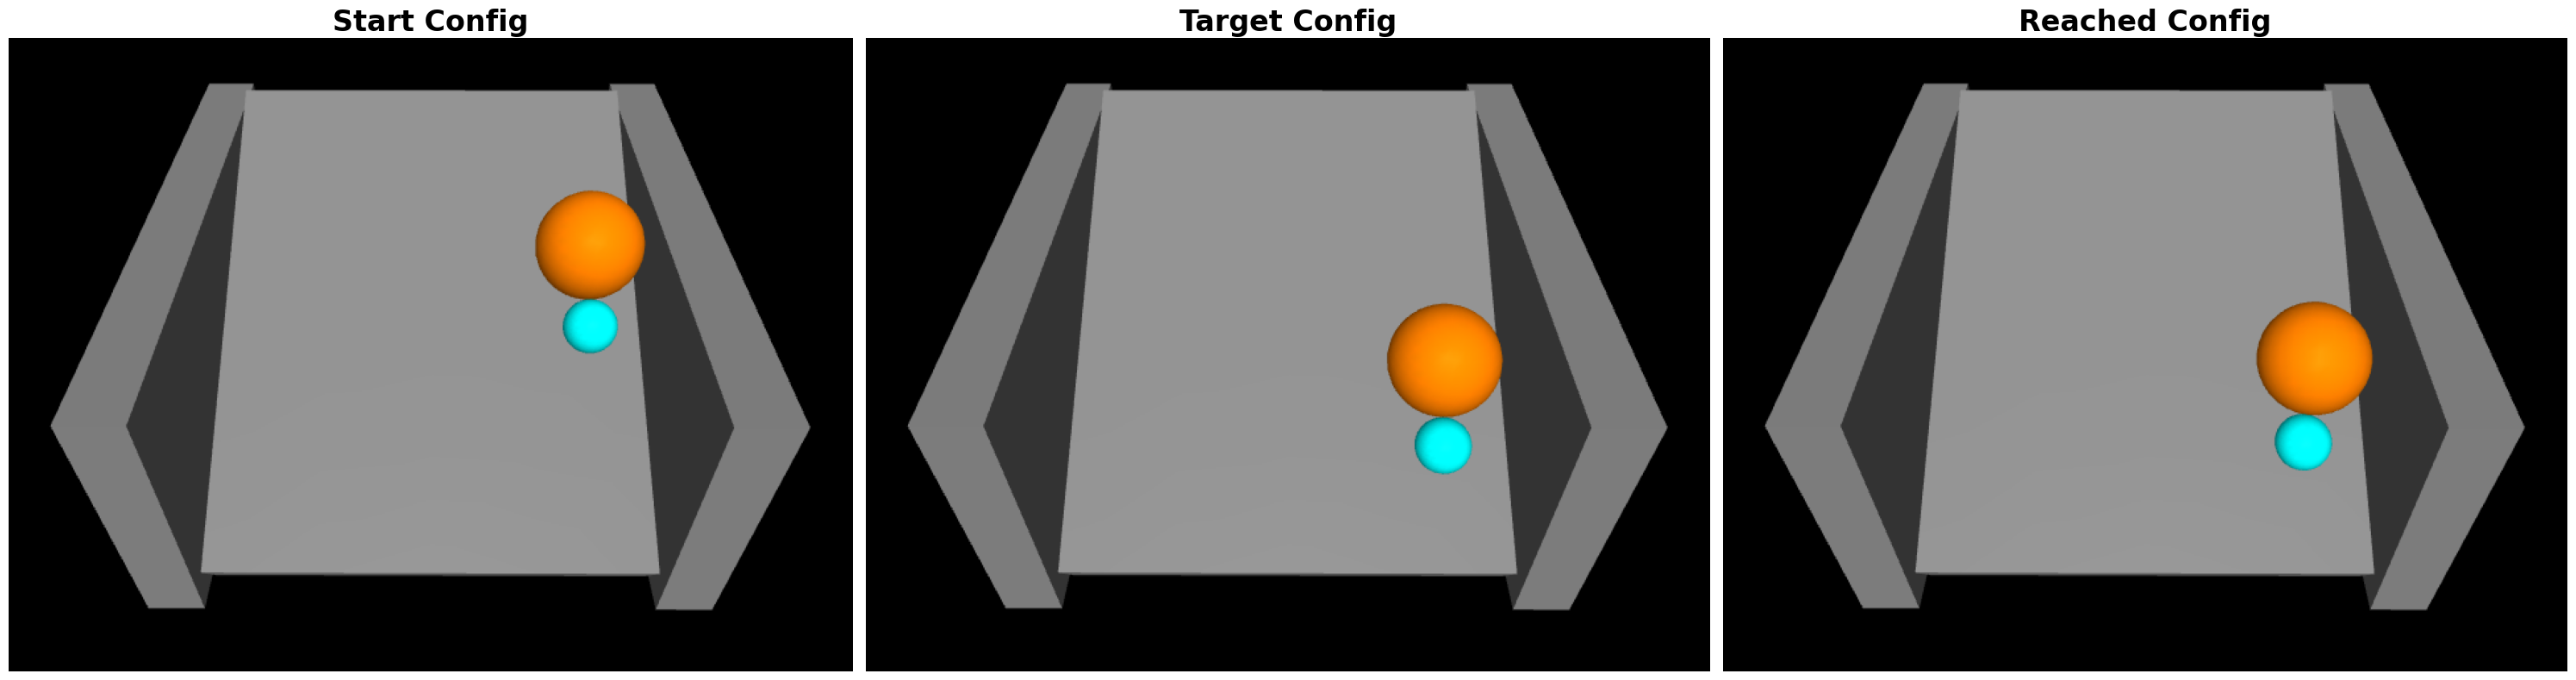

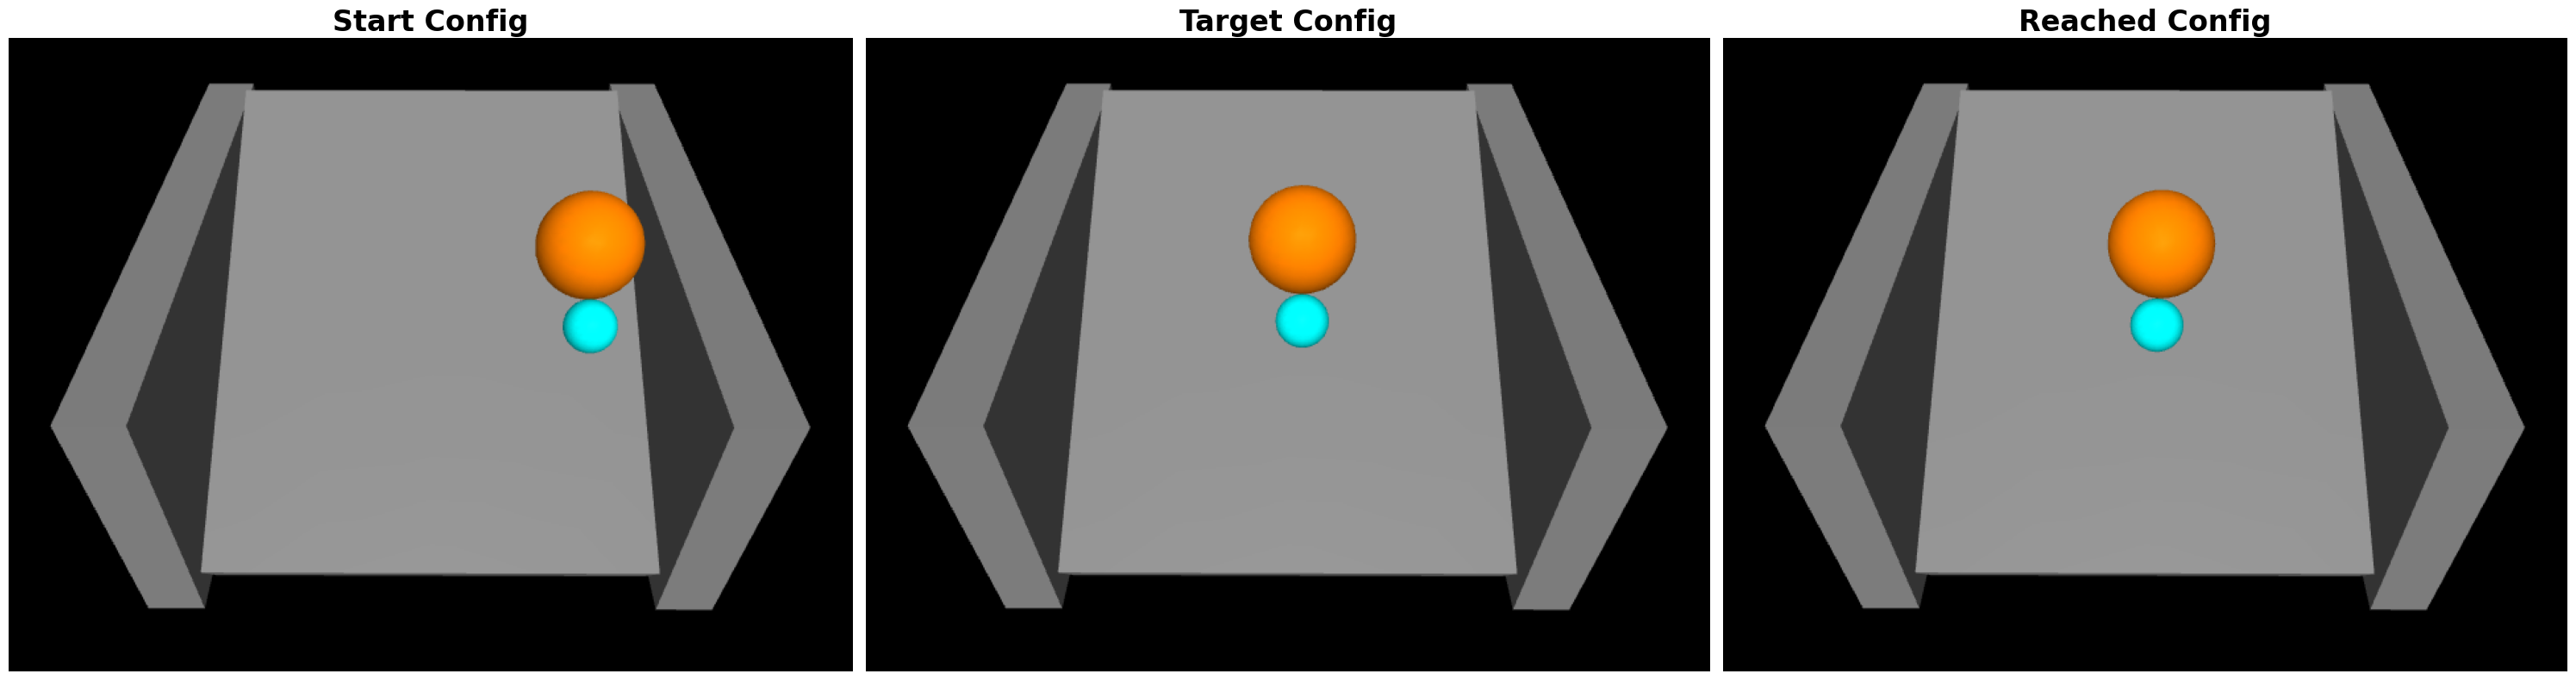

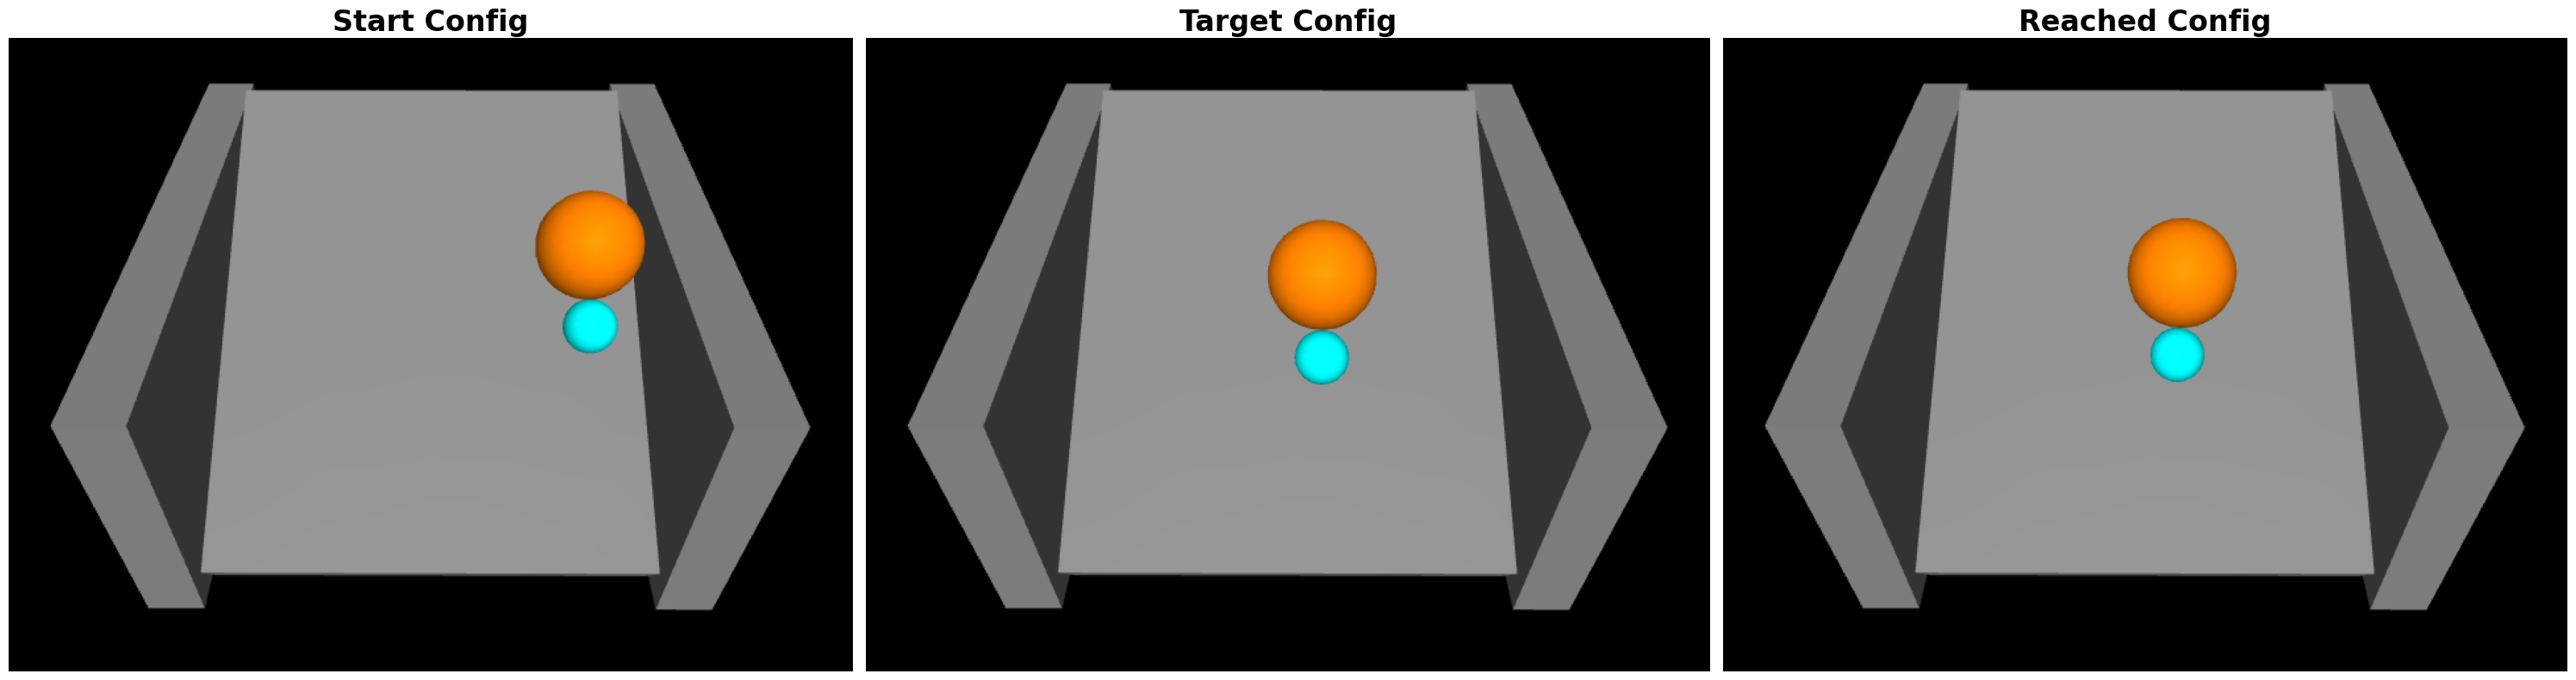

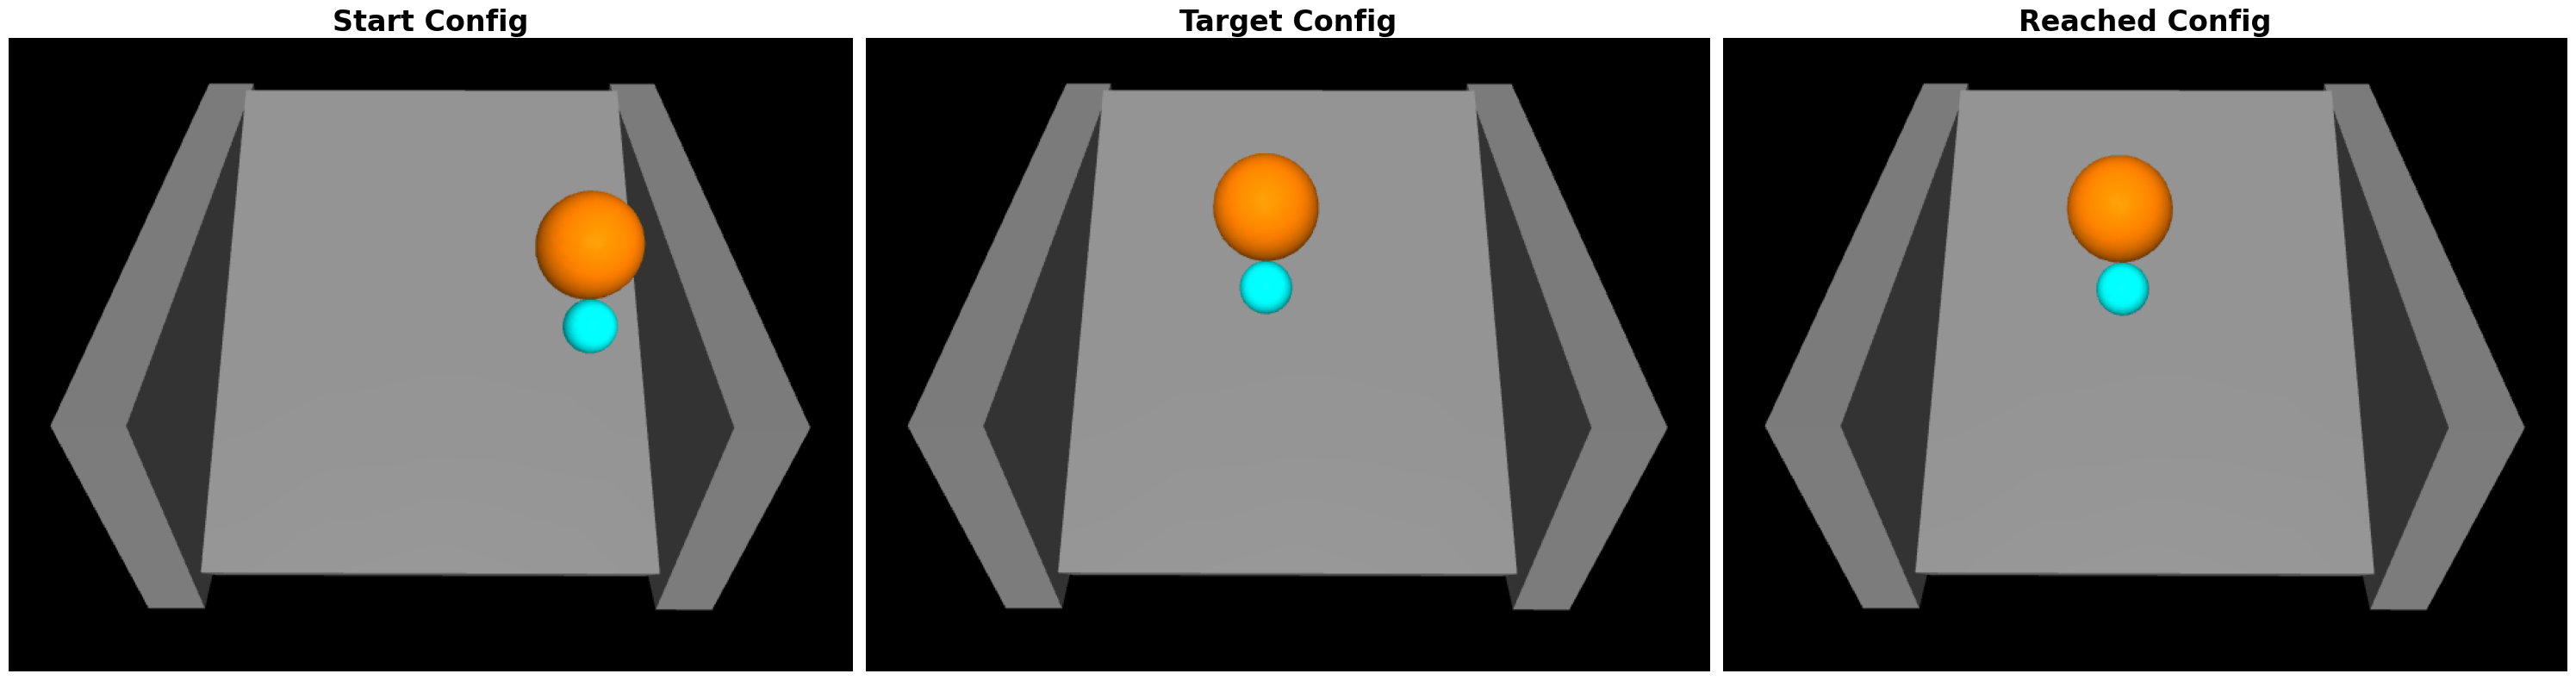

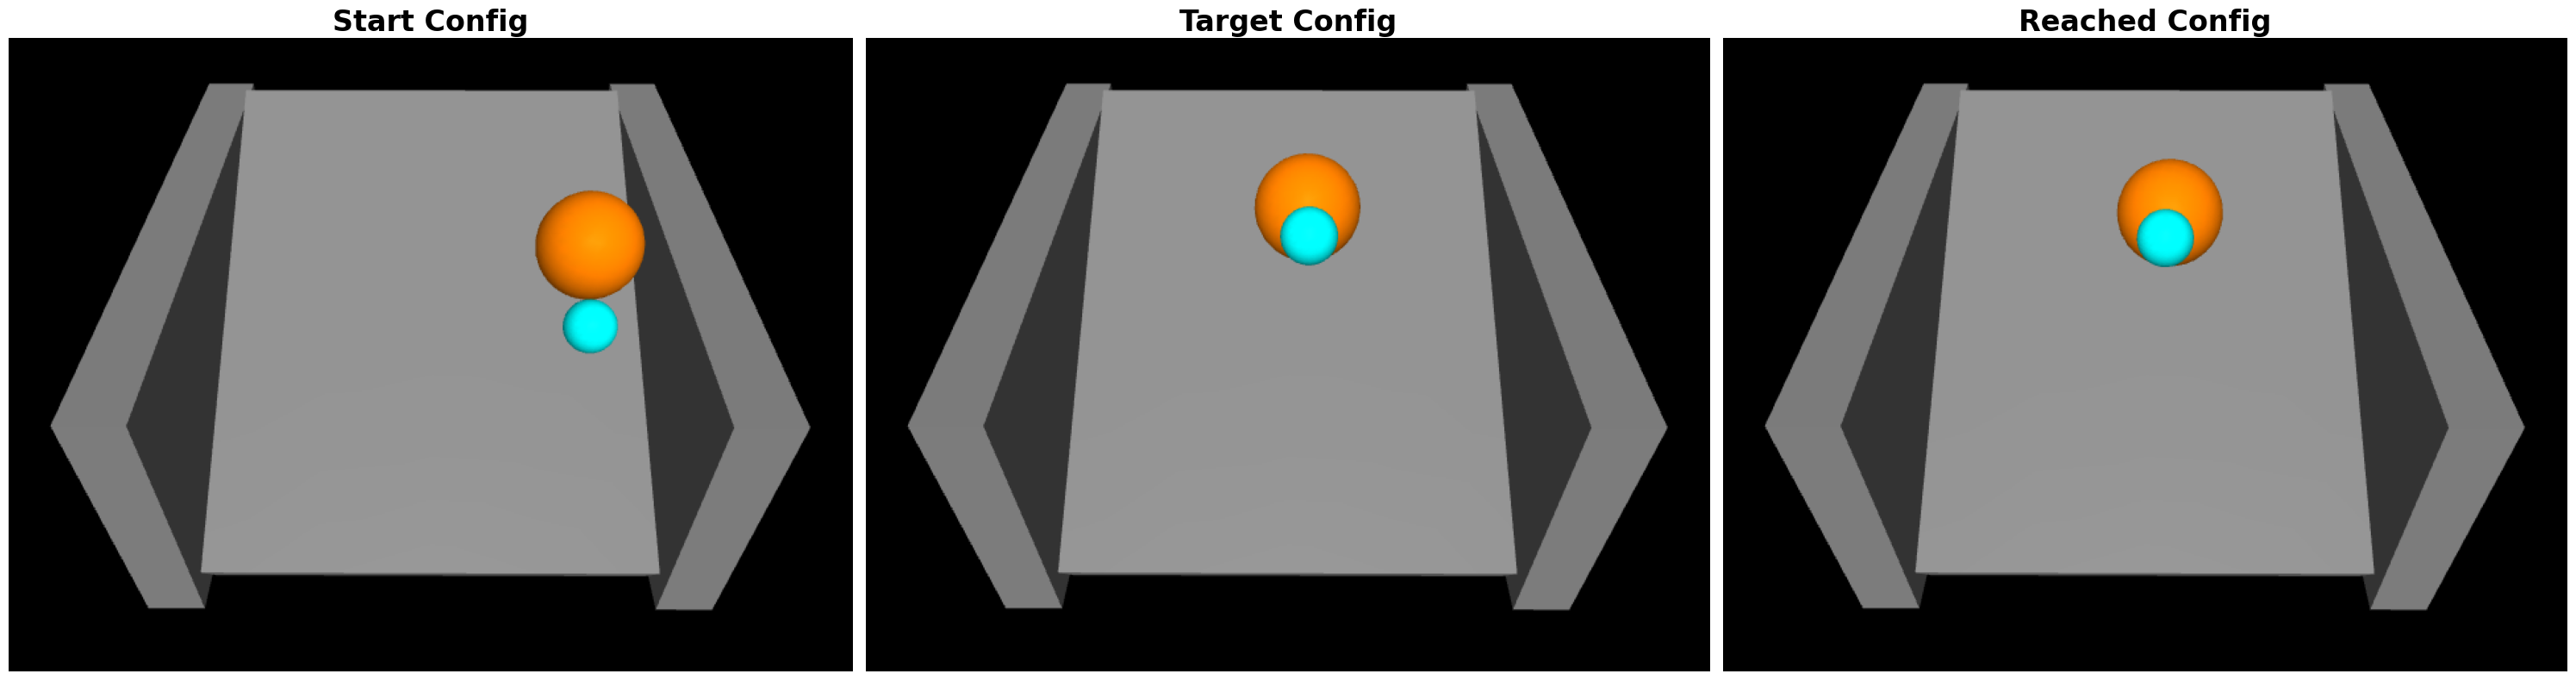

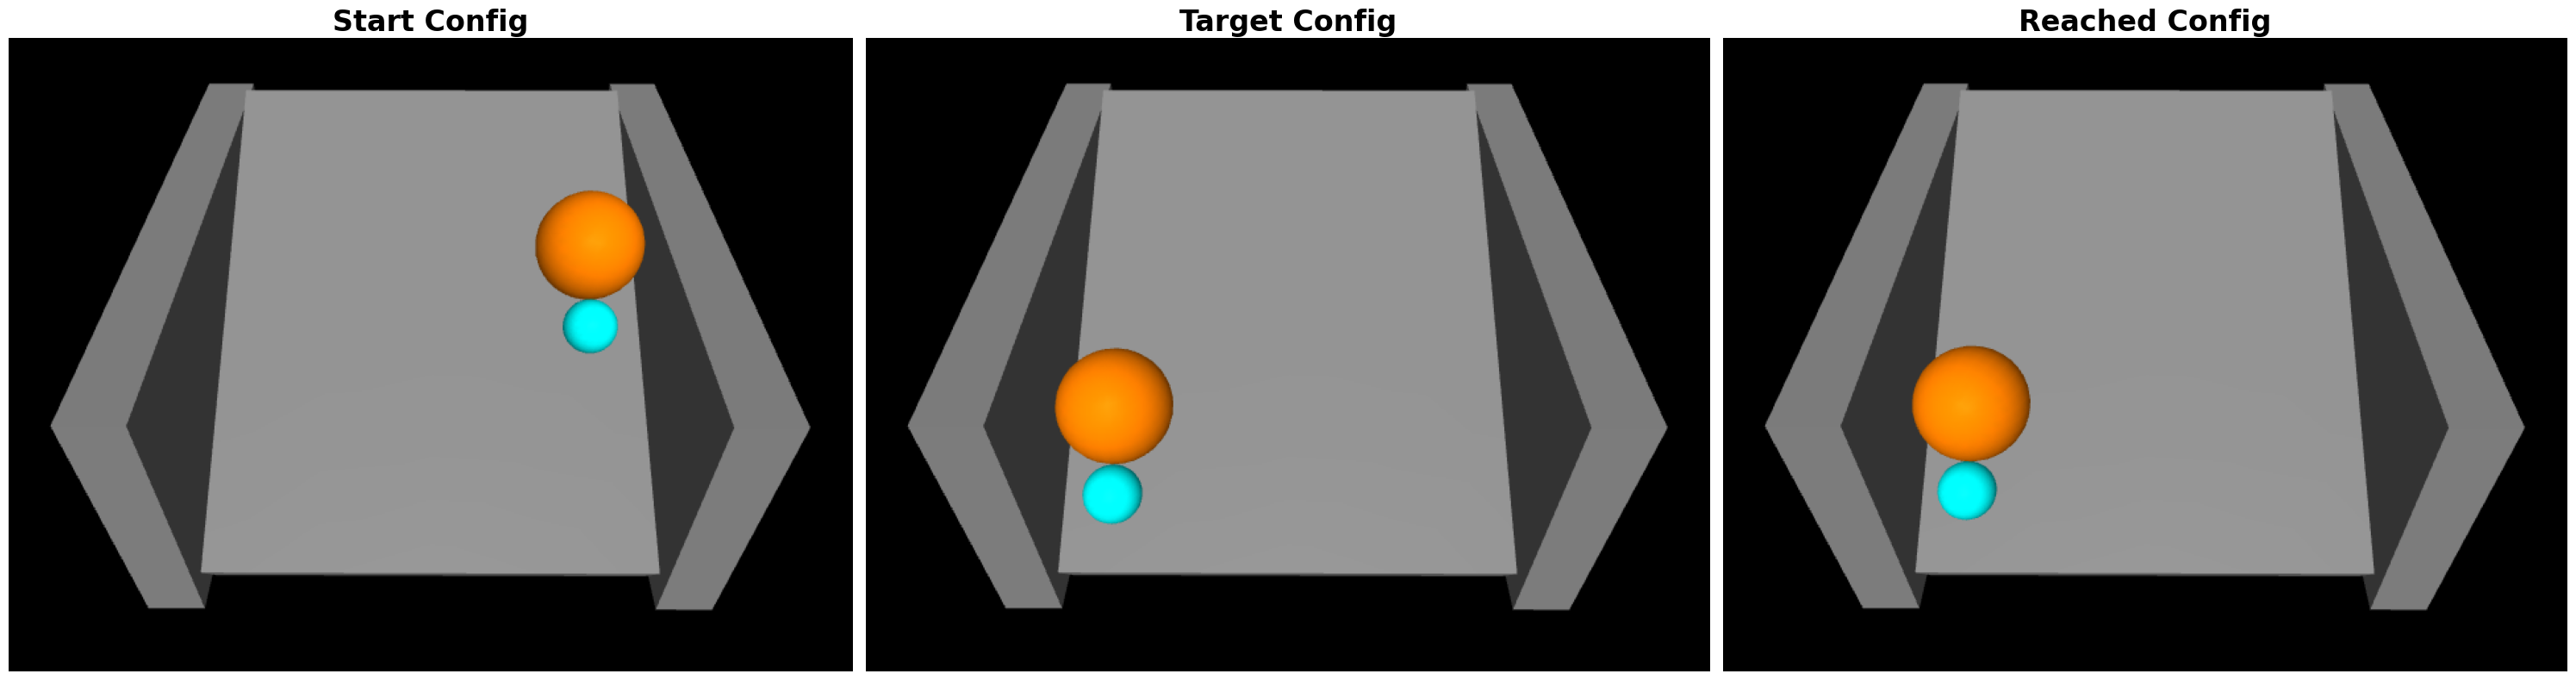

In [ ]:
if path:
    for i, path_idx in enumerate(valid_path_idxs):
        path = top_paths[path_idx]
        start_idx = top_paths_start[path_idx]
        end_idx = top_paths_goal[path_idx]
        e_vec = trees[end_idx][0]["state"][1] - path[-1]["state"][1]

        print("---- Sampled Path Data ----")
        print("Target config ids: ", [n["target_config_idx"] for n in path])
        print("Start idx: ", start_idx)
        print("End idx: ", end_idx)
        print("Cost: ", top_costs[path_idx])
        print("Error vec: ", e_vec)
        print("Error vec (with mask): ", e_vec * q_mask)
        print("Sampled Path Length: ", len(path))

        start_state = trees[start_idx][0]["state"][1]
        target_state = trees[end_idx][0]["state"][1]
        sim = MjSim(
            mujoco_xml, tau_sim=sim_cfg.tau_sim, interpolate=sim_cfg.interpolate_actions,
            joints_are_same_as_ctrl=sim_cfg.joints_are_same_as_ctrl, view=False, use_spline_ref=sim_cfg.use_spline_ref
        )
        play_path(path, sim, start_state, target_state, tau_action=sim_cfg.tau_action, camera=cfg.RRT.sim.camera, reset_state=True, save_intro_as=f"paths/intro{i}.png", save_as=f"paths/path{i}.gif")


In [ ]:
if path:
    fig, axes = plt.subplots(2, len(path), figsize=(60, 10))
    for i, node in enumerate(path):

        fig.suptitle("Sampled Configs During Trajectory", fontsize=48, fontweight="bold")

        sim.pushConfig(node["state"][1])
        im_state = sim.renderImg()

        axes[0, i].set_title(f"Node {i}", fontsize=32)
        axes[0, i].imshow(im_state)
        axes[0, i].axis("off")

        tci = node["target_config_idx"]
        axes[1, i].set_title(f"Sampled id {tci}", fontsize=32)
        axes[1, i].axis("off")
        if tci != -1:
            sim.pushConfig(trees[tci][0]["state"][1])
            im_target = sim.renderImg()
            
            if tci == end_idx:
                rect = patches.Rectangle(
                    (0, 0), 1, 1,
                    transform=axes[1, i].transAxes,
                    linewidth=10,
                    edgecolor="red",
                    facecolor="none"
                )
                axes[1, i].add_patch(rect)
        else:
            im_target = np.zeros_like(im_state)
        axes[1, i].imshow(im_target)
        
    plt.tight_layout()
    plt.show()

## Bi-directional analysis

In [ ]:
bidir = cfg.RRT.bidirectional and cfg.RRT.start_idx != -1 and cfg.RRT.start_idx != -1
if bidir:
    si = cfg.RRT.start_idx
    ei = cfg.RRT.end_idx
    bi_tree_tolerance = cfg.RRT.bi_tree_tolerance

    bi_tree_dataset = os.path.join(dataset, "bi_trees")
    bi_trees, bi_tree_count, bi_total_nodes_count = load_trees(bi_tree_dataset)

    print(f"Starting bi-directional analysis for trees with sizes {len(trees[si])} and {len(bi_trees[ei])}")

    # Find connections to target without the bi-tree
    found_direct_nodes_ids = []
    for id, node in enumerate(trees[si]):
        cost_to_target = cost_computation(node, trees[ei][0], q_mask, cost_max_method)
        if cost_to_target <= ERROR_THRESH:
            found_direct_nodes_ids.append(id)

    # Find connections using the bi-tree
    found_bi_nodes_ids = []
    min_cost_between_trees = 1e6
    for id, node in tqdm(enumerate(trees[si])):
        for bi_id, bi_node in enumerate(bi_trees[ei]):
            
            cost_to_target = cost_computation(node, bi_node, q_mask, cost_max_method)
            if cost_to_target <= bi_tree_tolerance:
                found_bi_nodes_ids.append((id, bi_id))
            
            if min_cost_between_trees > cost_to_target:
                min_cost_between_trees = cost_to_target

    print(f"------ Bi-Tree status for path from config {si} to {ei} ------")
    print(f"Node count in bi-tree: {len(bi_trees[ei])}")
    print(f"Found paths without bi-tree: {len(found_direct_nodes_ids)}")
    print(f"Found paths with bi-tree: {len(found_bi_nodes_ids)}")
    print(f"Minimum cost between trees: {min_cost_between_trees}")

In [ ]:
if bidir and found_bi_nodes_ids:
    # Build full trajectory
    connection_idx = np.random.randint(0, len(found_bi_nodes_ids))
    id = found_bi_nodes_ids[connection_idx][0]
    bi_id = found_bi_nodes_ids[connection_idx][1]
    path_to = build_path(trees[si], id)
    path_from = build_path(bi_trees[ei], bi_id, reverse=False)
    full_path = path_to + path_from
    print(f"Percentage forward tree: {len(path_to)/len(full_path)*100:.2f} ({len(path_to)}/{len(full_path)})")

    # Play trajectory
    start_state = trees[si][0]["state"][1]
    target_state = trees[ei][0]["state"][1]
    sim = MjSim(
        mujoco_xml, tau_sim=sim_cfg.tau_sim, interpolate=sim_cfg.interpolate_actions,
        joints_are_same_as_ctrl=sim_cfg.joints_are_same_as_ctrl, view=False
    )
    play_path(full_path, sim, start_state, target_state, tau_action=sim_cfg.tau_action,
              camera=cfg.RRT.sim.camera, save_as="bi_path.gif", reset_state=False)
    
    # TODO: Glue trajectory nodes with BBO